Trabalho de Inferência Estatística
Professor : Gustavo Mirapalheta.
MBA FGV - Big Data e Data Analytics.

## Objetivo
O Objetivo desse estudo é fazer uma avaliação do perfil dos Clientes do Banco Czech, fazendo inferências possibilitando ao banco um melhor posicionamento de seus produtos, além do que um melhor direcionamento ao time de vendas.

Primeiramente vamos importar os pacotes, para realização desse estudo utilizaremos o R Studio e os pacotes:

- dplyr
- tidyr
- corrplot
- lubridate
- ggplot
- treemap

In [2]:
library(dplyr)
library(tidyr)
library(lubridate)
library(tidyverse)
library(ggplot2)
library(treemap)

Agora vamos definir o nosso ambiente de trabalho.

In [4]:
getwd()
setwd("C:/Users/mathe/OneDrive - ESI Group/Matheus/MBA_Inf_Estatistica")

[1] "C:/Users/mathe/OneDrive - ESI Group/Matheus/MBA_Inf_Estatistica"

O Próximo passo é importar os datasets

In [34]:
df_account = read.table('account.asc',header=T,sep=";")
df_card = read.table('card.asc',header=T,sep=";")
df_client = read.table("client.asc",header=T,sep=";")
df_disp = read.table("disp.asc",header=T,sep=";")
df_district = read.table("district.asc",header=T,sep=";")
df_loan = read.table('loan.asc',header=T,sep=";")
df_order = read.table('order.asc',header=T,sep=";")
df_trans = read.table('trans.asc',header=T,sep=";")

Após o upload de todos os arquivos de dados, vamos definir a data do estudo.
Como o banco dedados continha dados até o último dia de 1999 nossa data de avaliação será dia 31/12/1998.

In [35]:
today = as.Date(ymd('1999-12-31'))
is.Date(today) 

[1] TRUE

Iremos Alterar os Labels que estão em Checo, para o inglês para facilitar o entendimento do dataset.

In [36]:
df_account = df_account %>% mutate('frequency' = case_when(df_account$frequency == 'POPLATEK MESICNE' ~ 'monthly issuance',
                                                             df_account$frequency == 'POPLATEK TYDNE'~ 'weekly issuance',
                                                             df_account$frequency == 'POPLATEK PO OBRATU' ~ 'issuance after transaction'))


In [37]:
head(df_account)

account_id,district_id,frequency,date
576,55,monthly issuance,930101
3818,74,monthly issuance,930101
704,55,monthly issuance,930101
2378,16,monthly issuance,930101
2632,24,monthly issuance,930102
1972,77,monthly issuance,930102


In [38]:
#transformar a coluna Date de int para Data
df_account$date = as.character(df_account$date)
df_account <- df_account %>% mutate('date' = ymd(df_account$date))

In [39]:
head(df_account)

account_id,district_id,frequency,date
576,55,monthly issuance,1993-01-01
3818,74,monthly issuance,1993-01-01
704,55,monthly issuance,1993-01-01
2378,16,monthly issuance,1993-01-01
2632,24,monthly issuance,1993-01-02
1972,77,monthly issuance,1993-01-02


In [40]:
#Organizar a tabela District
colnames(df_district) = c('district_id',
                          'district_name',
                          'region',
                          'no._of_habs',
                          'municipalities<499',
                          'municipalities<500-1999',
                          'municipalities<2000-9999',
                          'municipalities>10000',
                          'no._of_cities',
                          'ratio_of_urban habs',
                          'average_salary',
                          'unemploymant_rate_95',
                          'unemploymant_rate_96',
                          'enterpreneurs_per_1000 habs',
                          'crimes_95',
                          'crimes_96')

Agora vamos unir as tabelas district e as tabelas account para sabermos a localização de cada uma das contas, assim poderemos verificar os locais com maior número de contas, renda média entre outras.

In [41]:
#Substituindo o district_id pelo nome do distrito
df_account <- left_join(df_account, df_district, by = 'district_id')
df_account <- df_account %>% select(account_id:region,average_salary)
df_account$district_id = NULL

In [42]:
head(df_account)

account_id,frequency,date,district_name,region,average_salary
576,monthly issuance,1993-01-01,Brno - venkov,south Moravia,8743
3818,monthly issuance,1993-01-01,Ostrava - mesto,north Moravia,10673
704,monthly issuance,1993-01-01,Brno - venkov,south Moravia,8743
2378,monthly issuance,1993-01-01,Jindrichuv Hradec,south Bohemia,8427
2632,monthly issuance,1993-01-02,Karlovy Vary,west Bohemia,8991
1972,monthly issuance,1993-01-02,Vsetin,north Moravia,8909


Agora iremos criar uma coluna com a idade da conta, verificando a data de abertura como referência.

In [43]:
df_account <- df_account %>% mutate('account_age' = round((today - date)/360))

In [44]:
head(df_account)

account_id,frequency,date,district_name,region,average_salary,account_age
576,monthly issuance,1993-01-01,Brno - venkov,south Moravia,8743,7 days
3818,monthly issuance,1993-01-01,Ostrava - mesto,north Moravia,10673,7 days
704,monthly issuance,1993-01-01,Brno - venkov,south Moravia,8743,7 days
2378,monthly issuance,1993-01-01,Jindrichuv Hradec,south Bohemia,8427,7 days
2632,monthly issuance,1993-01-02,Karlovy Vary,west Bohemia,8991,7 days
1972,monthly issuance,1993-01-02,Vsetin,north Moravia,8909,7 days


In [47]:
#Definindo o tema dos gráficos.
my_theme = theme_light()+theme(axis.text.x = element_text(angle = 90), 
                                  axis.title = element_text(color="darkblue"),
                                  title = element_text(color = "darkblue"))

Iniciando a montagem dos gráficos.
Primeiro veremos a frequencia de retirada de extratos.

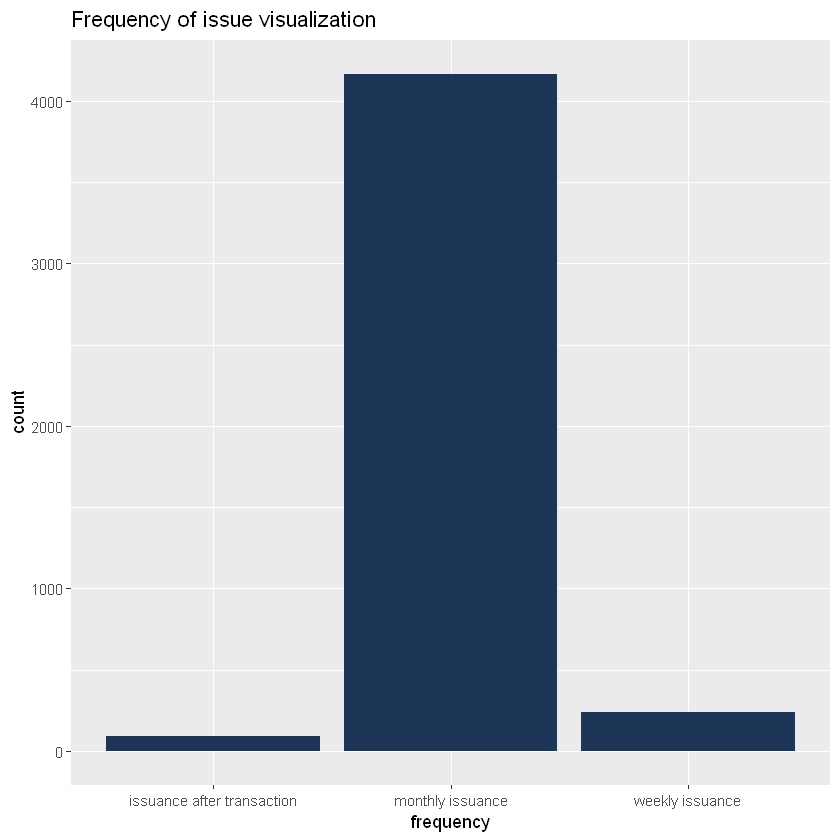

In [48]:
#freq issue
ggplot(df_account, aes(frequency))+
  geom_bar(fill = '#1d3557')+
  ggtitle('Frequency of issue visualization')

Podemos perceber que grande parte dos clientes retiram extratos mensais, isso pode-se se dar devido o fato de na década de 90 a existência de um custo para impressão do extrato.

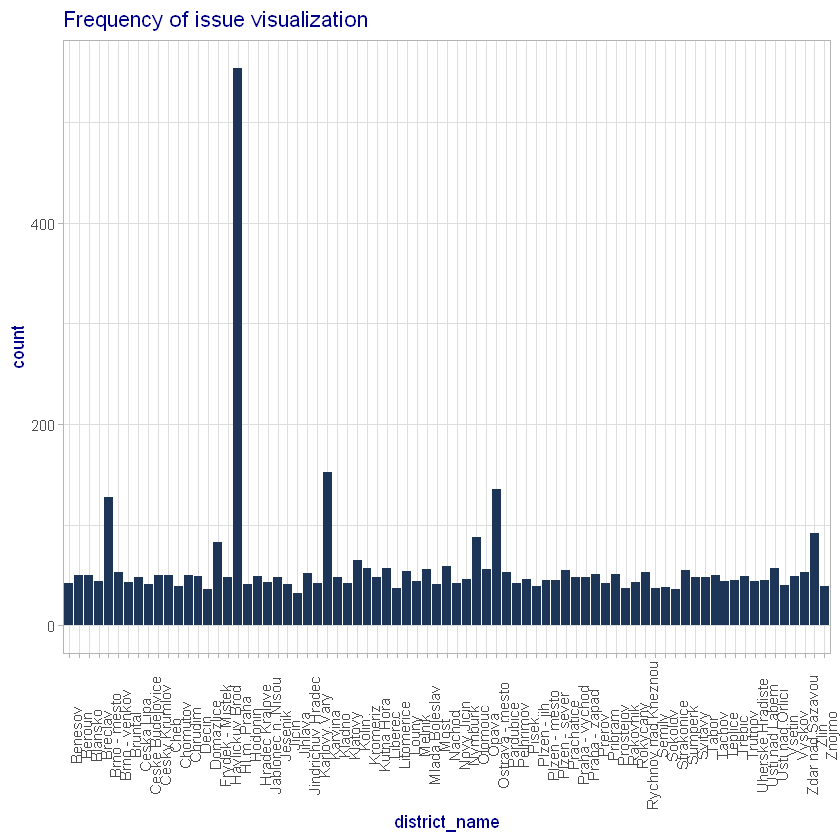

In [49]:
#Contas por Distrito
ggplot(df_account, aes(district_name))+
    geom_bar(fill = '#1d3557')+
    ggtitle('Frequency of issue visualization')+
    my_theme

Nesse gráfico podemos verificar a quantidade de contas abertas por cada distrito, a visualização não ficou muito legal então vamos alterar o tipo de gráfico e fazer um TreeMap com a visualização do número de contas por distrito.

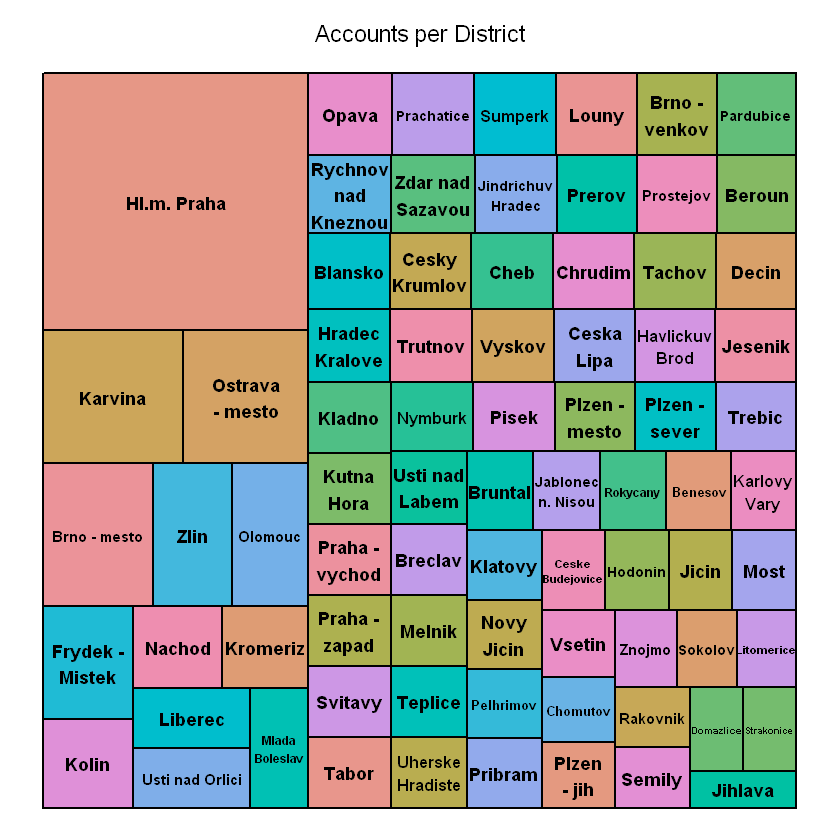

In [50]:
#Contas treemap por distrito
district_df = df_account %>% group_by(district_name) %>% summarise('count' = n())
group = district_df$district_name
value = district_df$count

data = data.frame(group,value)
treemap(data,index="group",vSize="value",type="index", 
        title.legend = "Accounts per District", 
        title = "Accounts per District")

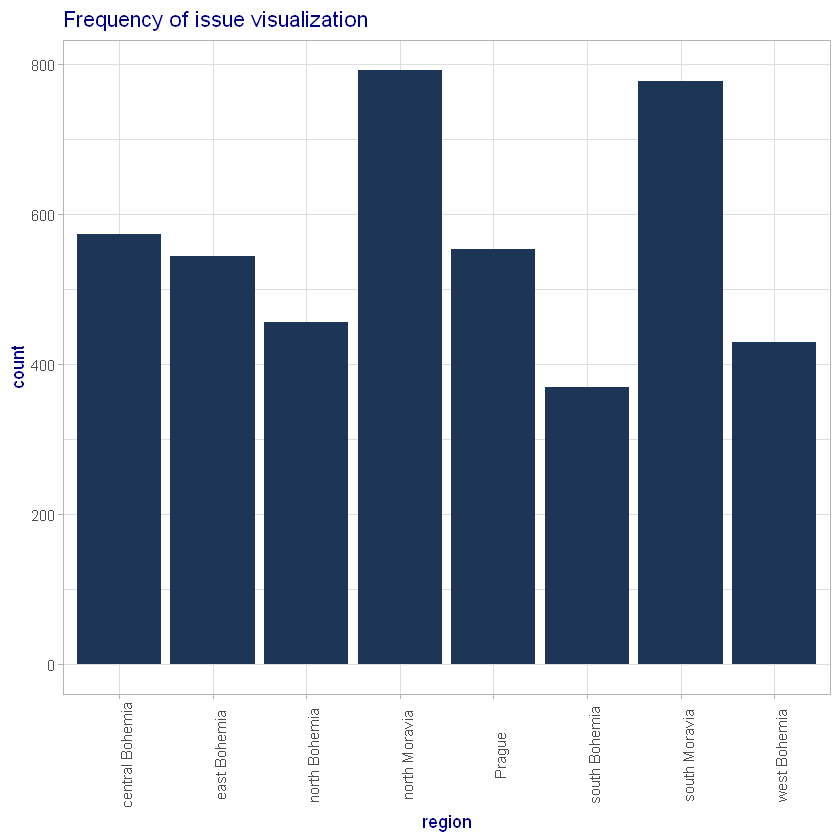

In [51]:
#Chart por region
ggplot(df_account, aes(region))+
  geom_bar(fill = '#1d3557')+
  ggtitle('Frequency of issue visualization')+
  my_theme

Descendo mais um nível na hierarquia do número de contas e vamos avaliar por região, faremos a visualização em barras e em também em Treemap.

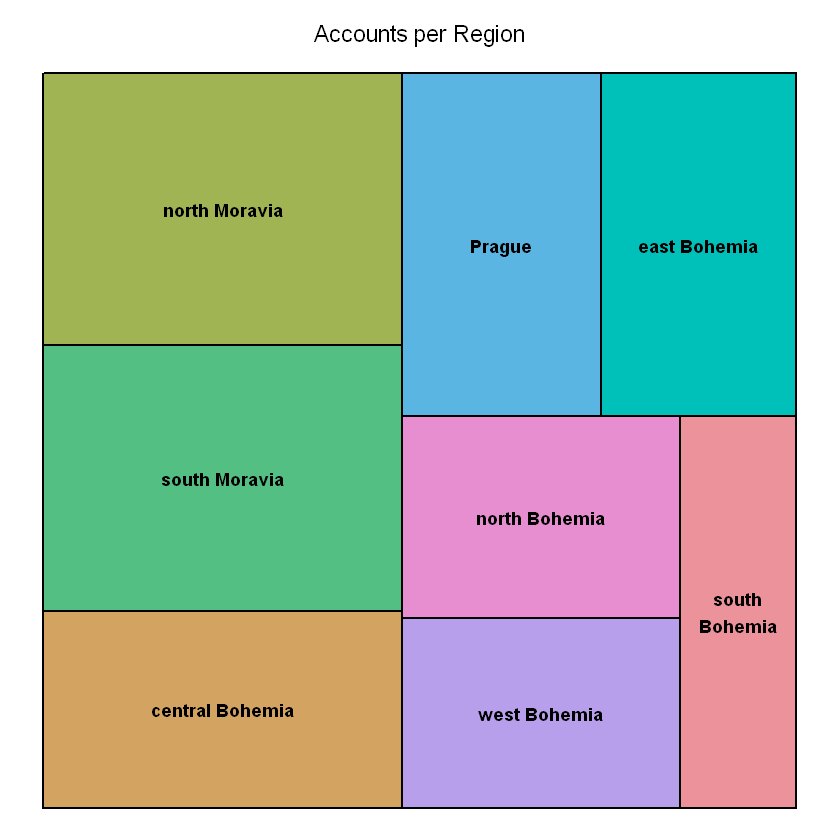

In [52]:
#treemap por região
df_region = df_account %>% group_by(region) %>% summarise('count' = n())
group = df_region$region
value = df_region$count
data = data.frame(group,value)
treemap(data,index="group",vSize="value",type="index", 
        title.legend = "Accounts per Region", 
        title = "Accounts per Region")

Com isso tivemos o resultado esperado, haja visto que as regiões mais urbanas apresentam um maior número de contas abertas. e a Região Central da República Checa Praga que demograficamente é menor que as outras regiões apreseta um número alto de contas.

Agora o Próximo passo é observar a quantidade de contas abertas, ao longo do tempo.

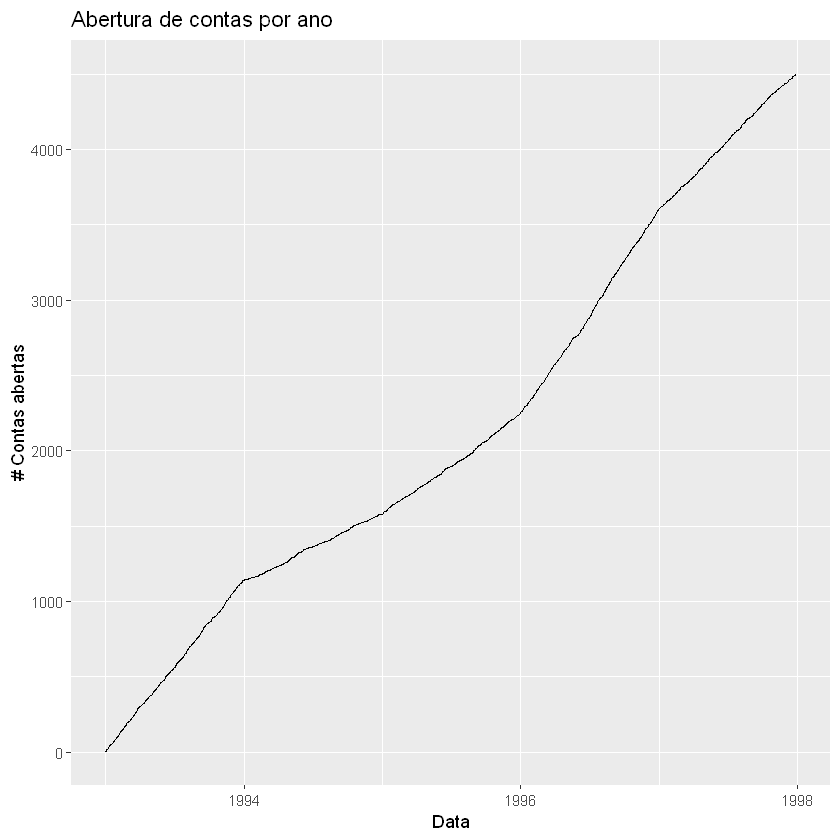

In [53]:
#Data de Abertura
df_date = df_account %>% group_by(date) %>% summarise('cont' = n())
df_date = df_date %>% mutate('accum' = cumsum(cont))

ggplot(df_date, aes(x = date, y = accum))+
  geom_line()+
  ggtitle('Abertura de contas por ano')+
  labs(x = 'Data', y= '# Contas abertas')

Com isso podemos ver um aumento substâncial no número de contas abertas ao longo dos anos, ao pesquisar sobre o fato, na década de 90 existiu uma "democaratização" bancária, redução de burocracias e aumentos dos benefícios além da segurança e disponibilidade de um maior número de agências e estações ATM.

## Agora vamos fazer uma análise mais profunda sobre os clientes.

In [67]:
#1) Convertemos para String (Caracteres) os valores da coluna birth_number.
df_client = read.table("client.asc",header=T,sep=";")

Agora vamos fazer a organização do dataset Clientes.

Assim nos facilitará a realização de algumas inferências.

In [68]:
#1) Convertemos para String (Caracteres) os valores da coluna birth_number.
df_client$birth_number = as.character(df_client$birth_number)

#2) Criamos a coluna mês com retirando os valores do centro da coluna, caracteres 3 e 4
df_client = df_client %>% mutate('mes' = str_sub(birth_number,3,4))

#3) Criamos a coluna 'sexo' fazendo com a lógica : Se o mês for maior que 12 é feminino caso contrário é masculino
df_client = df_client %>% mutate('sexo' = ifelse(mes > 12 , 'f', 'm'))

#4) Alteramos os valores da coluna mes para número
df_client$mes = as.numeric(df_client$mes)

#5) Retiramos o mês de aniversário da pessoa, com a formula : se mês > 12 , mes = mes - 50
df_client = df_client %>% mutate('mes' = ifelse(mes > 12 , mes - 50, mes))

#6) Criamos a coluna mês2 , para deixarmos todos valores com dois digitos de caracteres, por exemplo para o mês 2 : de 2 para 02
df_client = df_client %>% mutate('mes2' = ifelse(mes < 10, paste('0',mes,sep =''),mes))


#7) Concatenamos , dois primeiros dígitos da birth_number , mes2 (criado no passo acima), dois últimos dígitos da coluna birth_number, com separador vazio (")
df_client = df_client %>% mutate('birth' = paste('19',str_sub(birth_number,1,2),mes2,str_sub(birth_number,5,6), sep=''))

#8) Criamos a coluna birthdate transformando a string concatenada acima em tipo Date
df_client = df_client %>% mutate('birthdate' = ymd(df_client$birth))

#9) Retirmos todas as colunas intermediárias montadas nos passos acima.
df_client = df_client %>% select(client_id,district_id,sexo,birthdate)

#10) Alteramos o nome da coluna 'sexo' para 'gender' assim deixaremos todas em um padrão.
df_client = df_client %>% rename('gender' = sexo)

In [64]:
head(df_client)

client_id,district_id,gender,birthdate
1,18,f,1970-12-13
2,1,m,1945-02-04
3,1,f,1940-10-09
4,5,m,1956-12-01
5,5,f,1960-07-03
6,12,m,1919-09-22


In [69]:
# Fazendo o Join do dataset para trazer o distrito e região de cada cliente.
df_client = left_join(df_client, df_district, by = 'district_id')
df_client <- df_client %>% select(client_id:region)
df_client$district_id = NULL
df_client$mes = NULL
df_client$mes2 = NULL
df_client$birth_number = NULL
df_client$birth = NULL

### Vamos iniciar as análises no Dataset Clientes

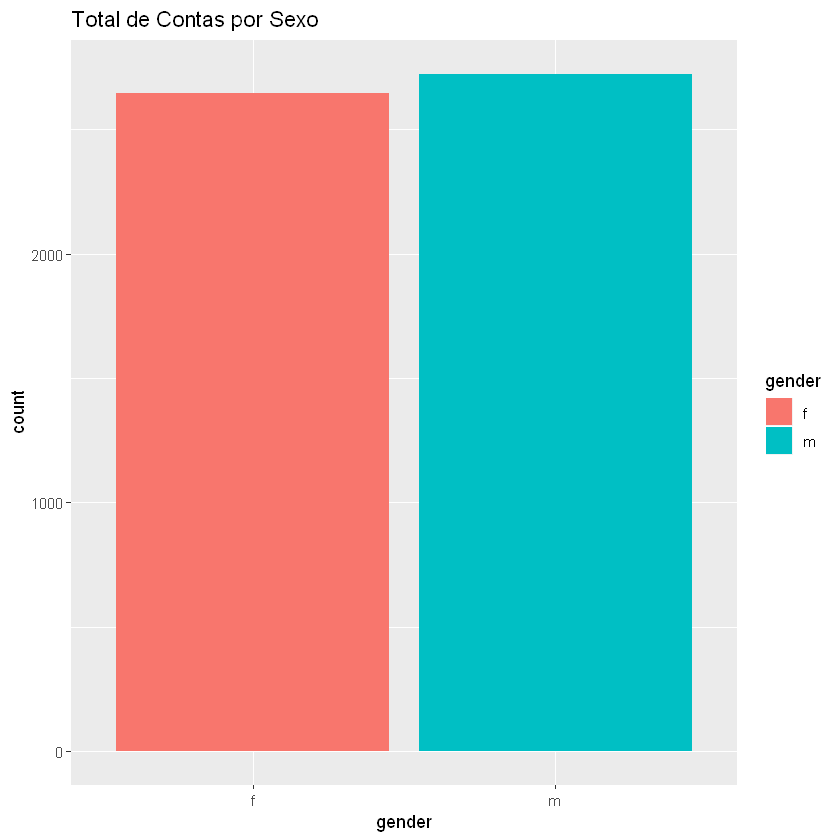

In [70]:
ggplot(df_client, aes(x=gender, fill = gender))+
  geom_bar()+
  ggtitle("Total de Contas por Sexo")

Para facilitar a nossa visualização vamos criar um gráfico de donut.

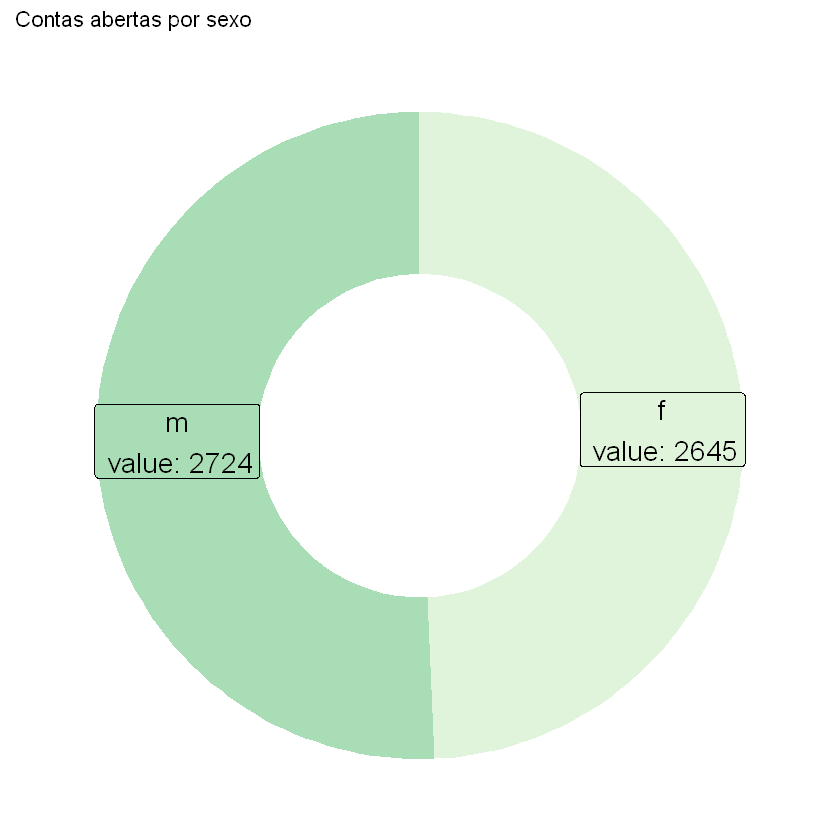

In [72]:
#Gráfico Donut para sexo
df_client_gender = df_client %>% group_by(gender) %>% summarise('cont' = n())

#Gráfico de Donut
category <- df_client_gender$gender
count = df_client_gender$cont
data = data.frame(category,count)

# Computando as porcentagens
data$fraction <- data$count / sum(data$count)
# Computando as porcentagens acumuladas (top of each rectangle)
data$ymax <- cumsum(data$fraction)
# Computando os limites superiores de cada "retângulo"
data$ymin <- c(0, head(data$ymax, n=-1))
# Computando os labels de posição
data$labelPosition <- (data$ymax + data$ymin) / 2
# Compute as categorias
data$label <- paste0(data$category, "\n value: ", data$count)
# Construindo o gráfico.

ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=category)) +
  geom_rect() +
  geom_label( x=3.5, aes(y=labelPosition, label=label), size=6) +
  scale_fill_brewer(palette=4) +
  coord_polar(theta="y") +
  xlim(c(2, 4)) +
  theme_void() +
  ggtitle("Contas abertas por sexo")+
  theme(legend.position = "none")

Apesar do gráfico de Donut trazer uma visualização simples e clara, ele possui uma série de steps para realização dessa maneira decidimos criar uma função para montarmos de maneira mais fácil nas próximas vezes que esse tipo de gráfico for necessário.

In [73]:
donut = function(category, count,title){
  data = data.frame(category,count)
  # Compute percentages
  data$fraction <- data$count / sum(data$count)
  # Compute the cumulative percentages (top of each rectangle)
  data$ymax <- cumsum(data$fraction)
  # Compute the bottom of each rectangle
  data$ymin <- c(0, head(data$ymax, n=-1))
  # Compute label position
  data$labelPosition <- (data$ymax + data$ymin) / 2
  # Compute a good label
  data$label <- paste(data$count)
  
  ggplot(data, aes(ymax=ymax, ymin=ymin, xmax=4, xmin=3, fill=category)) +
    geom_rect() +
    geom_label( x=3.5, aes(y=labelPosition, label=label), size=6) +
    scale_fill_brewer(palette=4) +
    coord_polar(theta="y") +
    xlim(c(2, 4)) +
    theme_void()+
    ggtitle(title)
}

Agora com uma simples passagem de parâmetros poderemos construir um gráfico de donut de maneira mais fácil.

In [74]:
df_client_gender = df_client %>% group_by(gender) %>% summarise('cont' = n())

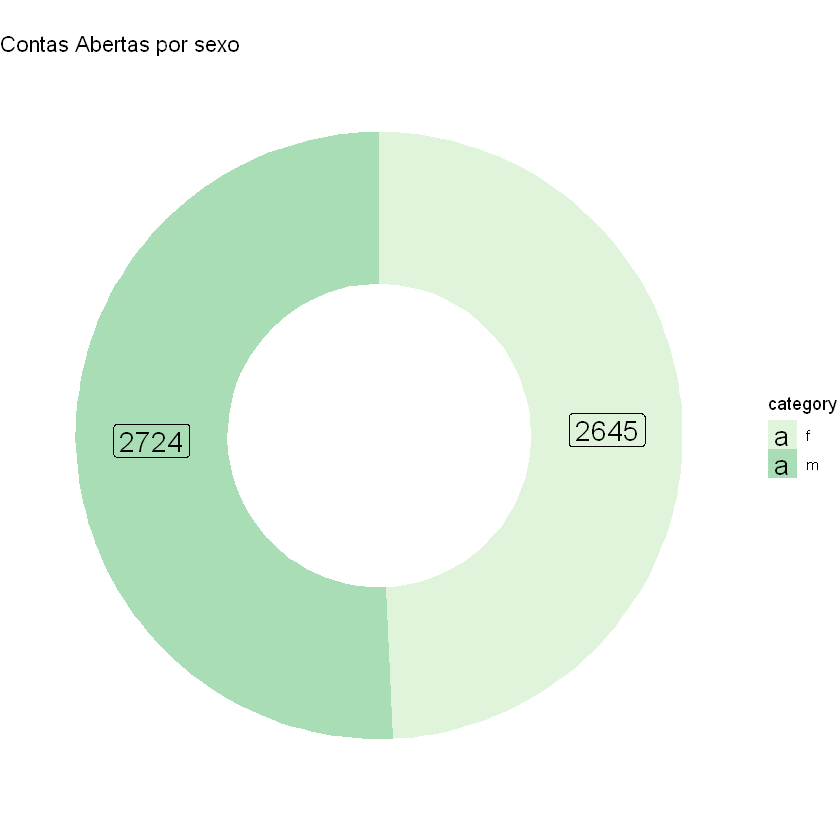

In [76]:
#Gráfico de Donut
category <- df_client_gender$gender
count = df_client_gender$cont
data = data.frame(category,count)
donut(category= category, count = count,"Contas Abertas por sexo")

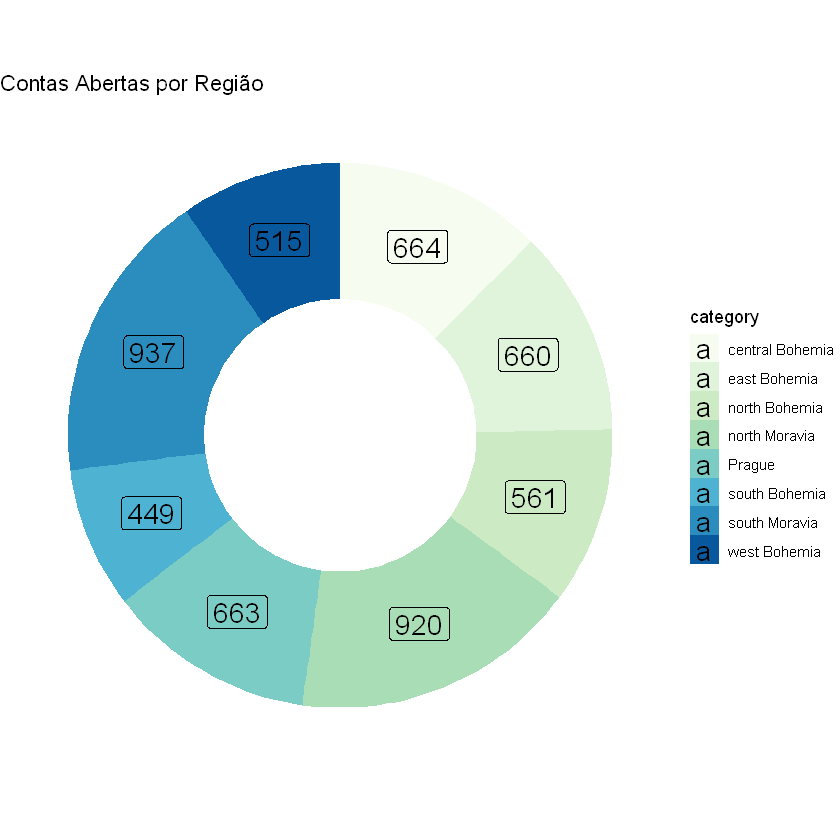

In [77]:
df_client_region = df_client %>% group_by(region) %>% summarise('count' = n())
category <- df_client_region$region
count <- df_client_region$count
data = data.frame(category,count)
donut(category, count,"Contas Abertas por Região")


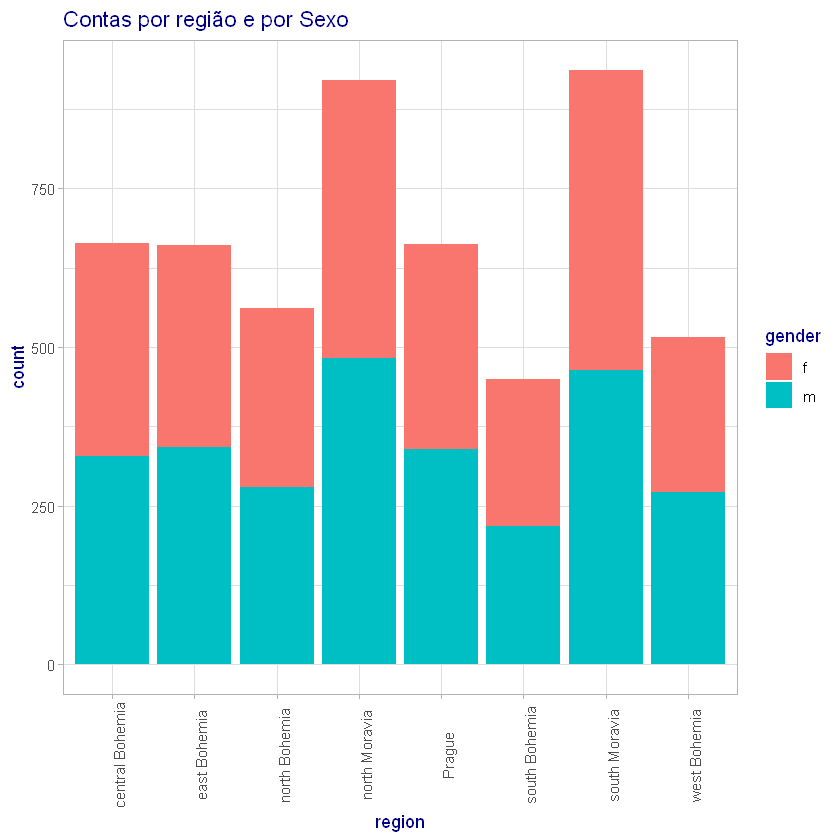

In [80]:
ggplot(df_client,aes(x = region, fill = gender))+
  geom_bar()+
    my_theme+
    ggtitle("Contas por região e por Sexo")


## Agora vamos avaliar o Dataset de transações

In [95]:
df_trans = read.table('trans.asc',header=T,sep=";")
unique(df_trans$type)

[1] PRIJEM VYDAJ  VYBER 
Levels: PRIJEM VYBER VYDAJ

In [96]:
#Avaliando uma conta apenas
c2378 <- df_trans %>% filter(account_id == '2378')

Para entender melhor o funcionamento desse dataset vamos avaliar uma conta apenas.

In [97]:
c2378

trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
695247,2378,930101,PRIJEM,VKLAD,700.0,700.0,,,NA
695250,2378,930122,PRIJEM,VKLAD,7268.0,7968.0,,,NA
695266,2378,930123,PRIJEM,VKLAD,14440.0,22408.0,,,NA
695262,2378,930124,PRIJEM,VKLAD,49752.0,72160.0,,,NA
695265,2378,930126,PRIJEM,VKLAD,21899.0,94059.0,,,NA
695560,2378,930131,VYDAJ,VYBER,34700.0,59453.7,,,NA
3608592,2378,930131,PRIJEM,,94.7,94153.7,UROK,,NA
695272,2378,930205,PRIJEM,VKLAD,30192.0,89645.7,,,NA
695340,2378,930207,VYDAJ,PREVOD NA UCET,9612.0,80033.7,SIPO,EF,1222903
695270,2378,930211,PRIJEM,VKLAD,31038.0,111071.7,,,NA


Nesse dataset temos o histórico de transaçõs realizados por cada uma das contas do banco CZECH, esse data set é muito importante pois dele conseguiremos traçar o padrão financeiro de cada um dos clientes, tanto como o histórico de com o banco

In [98]:
#Alterando as labels do tipo 
df_trans$date = ymd(df_trans$date)
df_trans = df_trans %>% mutate('type' = case_when(df_trans$type == 'PRIJEM' ~ 'credit',
                                                  df_trans$type == 'VYDAJ' ~'withdraw',
                                                  df_trans$type == 'VYBER' ~'withdraw in Cash'
                                                  ))

#Alterando as labels de Operation
df_trans = df_trans %>% mutate('operation' = case_when(df_trans$operation == 'VYBER KARTOU' ~ 'credit card withdrawal',
                                                       df_trans$operation == 'VKLAD' ~'credit in cash',
                                                       df_trans$operation == 'PREVOD Z UCTU' ~ 'collection from another bank',
                                                       df_trans$operation == 'VYBER' ~ 'withdrawal in cash',
                                                       df_trans$operation == 'REVOD NA UCET' ~ 'remittance to another bank'))

#alterando as labels de ksymbol
df_trans = df_trans %>% mutate('k_symbol' = case_when(df_trans$k_symbol == 'POJISTNE' ~ 'insurrance payment',
                                                      df_trans$k_symbol == 'SLUZBY' ~'payment for statement',
                                                      df_trans$k_symbol == 'UROK' ~ 'interest credited',
                                                      df_trans$k_symbol == 'SANKC. UROK' ~ 'sanction interest if negative balance',
                                                      df_trans$k_symbol == 'SIPO' ~ 'household',
                                                      df_trans$k_symbol == 'DUCHOD' ~ 'old age pension ',
                                                      df_trans$k_symbol == 'UVER' ~ 'loan payment'))

In [100]:
df_trans

trans_id,account_id,date,type,operation,amount,balance,k_symbol,bank,account
695247,2378,1993-01-01,credit,credit in cash,700,700,NA,,NA
171812,576,1993-01-01,credit,credit in cash,900,900,NA,,NA
207264,704,1993-01-01,credit,credit in cash,1000,1000,NA,,NA
1117247,3818,1993-01-01,credit,credit in cash,600,600,NA,,NA
579373,1972,1993-01-02,credit,credit in cash,400,400,NA,,NA
771035,2632,1993-01-02,credit,credit in cash,1100,1100,NA,,NA
452728,1539,1993-01-03,credit,credit in cash,600,600,NA,,NA
725751,2484,1993-01-03,credit,credit in cash,1100,1100,NA,,NA
497211,1695,1993-01-03,credit,credit in cash,200,200,NA,,NA
232960,793,1993-01-03,credit,credit in cash,800,800,NA,,NA


### Avaliando as contas Negativas

Agora seremos capazes de avaliar as contas que ficaram negativas, der ficado negativa em algum momento conta para uma classificação de crédito.

In [101]:
#criando um dataframe com os negativados 
negatives = df_trans %>% filter(balance < 0)

#criando uma coluna para as retiradas
df_trans = df_trans %>% mutate('withdraw' = ifelse(type == 'withdraw' | type == 'withdraw in Cash', amount, 0))

#criando uma coluna para os créditos
df_trans = df_trans %>% mutate('credit' = ifelse(type == 'credit',amount,0))

#criando uma coluna de avaliação do balanço / positivo de negativo
df_trans <- df_trans %>% mutate('negative' = ifelse(balance < 0, TRUE, FALSE))

#criando um filro 
df <- df_trans %>% filter (negative == TRUE)
df2 <- df %>% group_by (account_id) %>% summarise('firstNegativeDate' = min(date), 'LastNeagtiveDate' = max(date)) 

#criando um filtro
last_status = df_trans %>% group_by(account_id) %>% summarise (last_balance = last(balance), 
                                                               total_retiradas = sum(withdraw),
                                                               total_credit = sum(credit),
                                                               first_trans = min(date),
                                                               n_negatives = sum(negative))

In [102]:
last_status <- left_join(last_status, df2, by = "account_id")
c2 = df_trans %>% filter(account_id == 2)

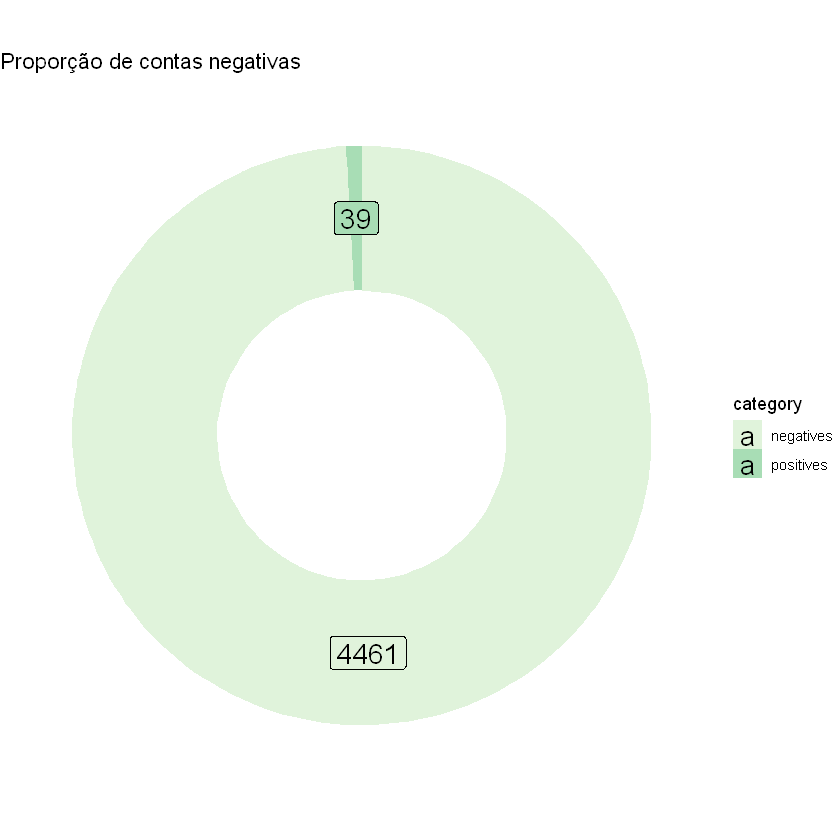

In [103]:
last_status = last_status %>% mutate('negative' = ifelse(last_balance < 0 , TRUE, FALSE))
negatives = last_status %>% group_by(negative) %>% summarise ('totals' = n())
category <- c('negatives', 'positives')
count <- negatives$totals
data = data.frame(category, count)
donut(category = category, count = count, "Proporção de contas negativas")                                             

Como podemos ver o banco possui uma pequena porcentagem de contas negativas, apenas 0,87%. Isso na data atual (31/12/1998).

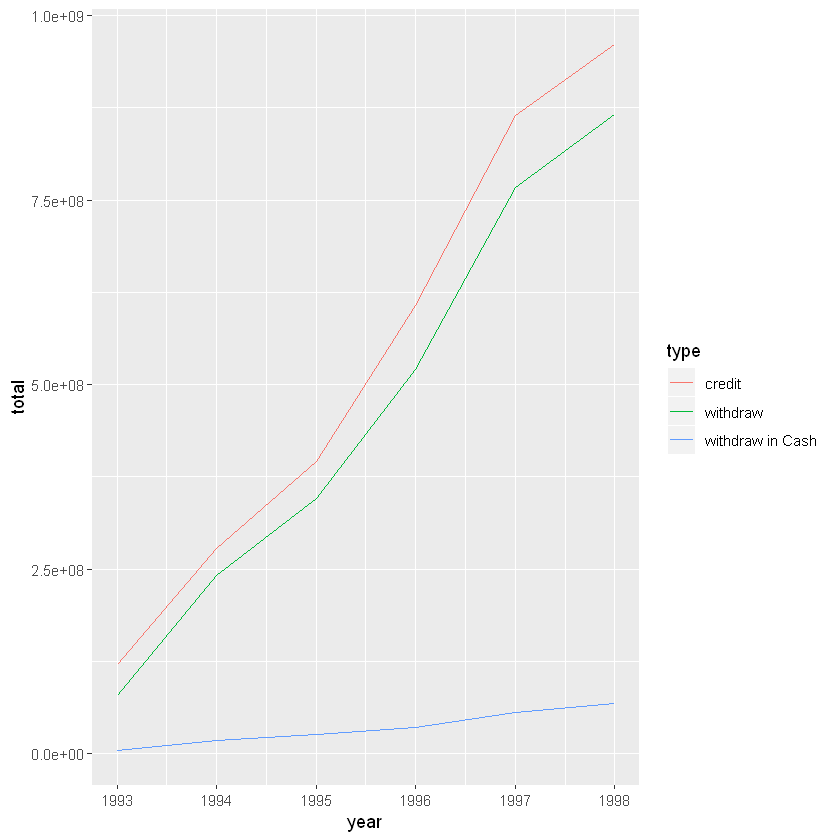

In [104]:
df_trans = df_trans %>% mutate(year = year(date))
new_df = df_trans %>% group_by(type, year) %>% summarise('total' = sum(amount))

ggplot(new_df, aes(year, y = total, color = type))+
  geom_line()

Voltando ao dataset de transações de (saídas) podemos perceber a evolução das transações realizadas pelos clientes do banco Czech

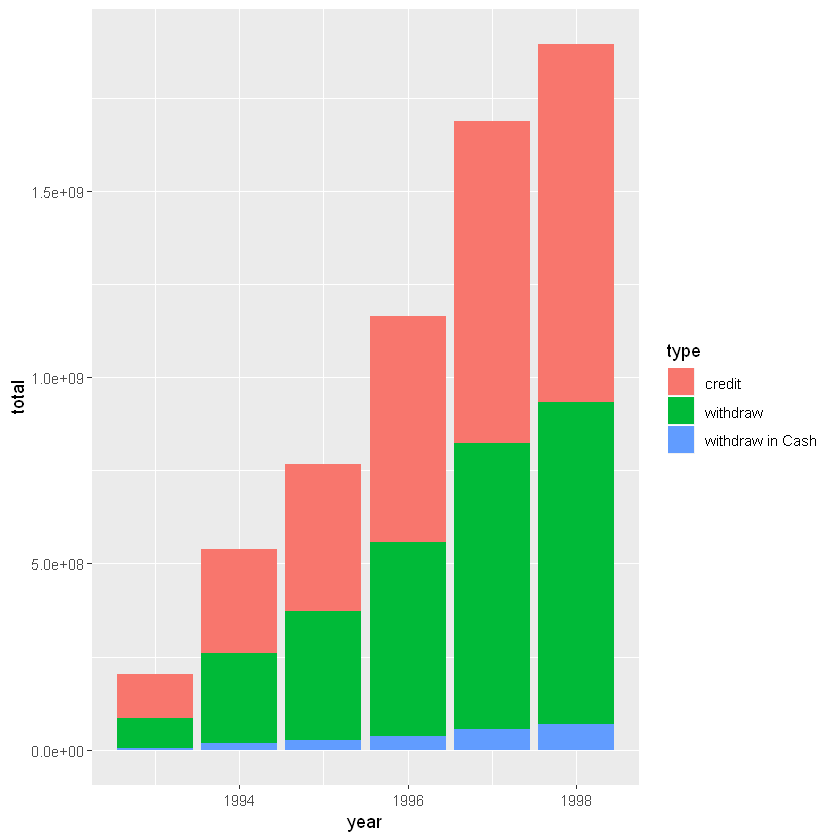

In [105]:
#Saídas
ggplot(new_df, aes(year, y = total, fill = type))+geom_col()

Agora é possível avaliarmos o montante total movimentado pelos clientes no banco.

Agora que criamos uma segmentação do que é crédito e o que é débito podemos avaliar as transações com mais detalhes

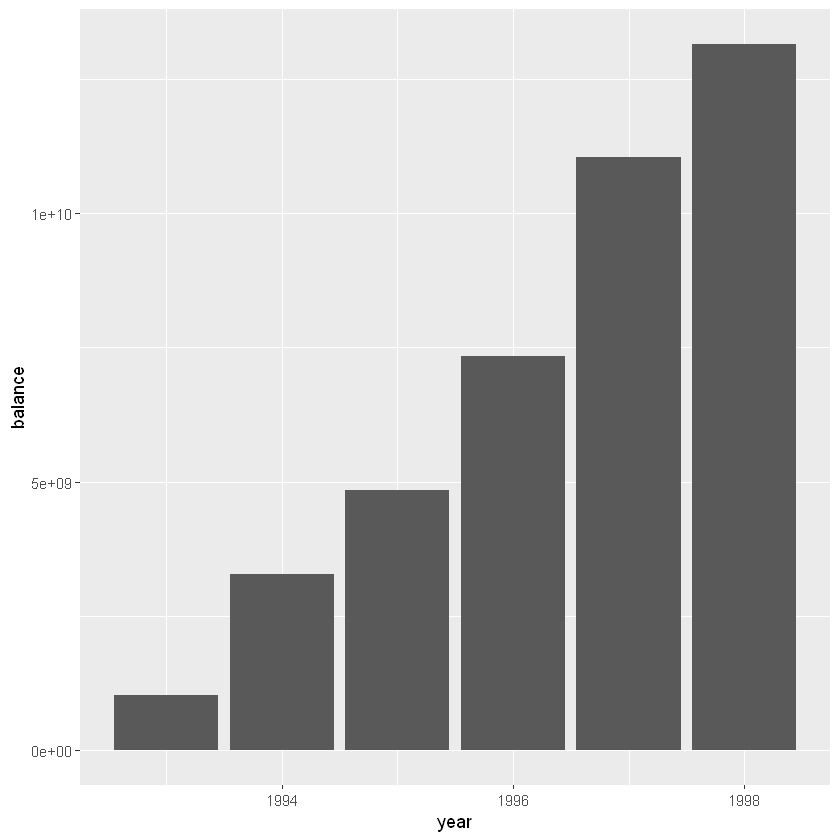

In [111]:
#balanço
balance = df_trans %>% group_by(year) %>% summarise('balance' = sum(balance))
  ggplot(balance, aes(year, y = balance))+geom_col()

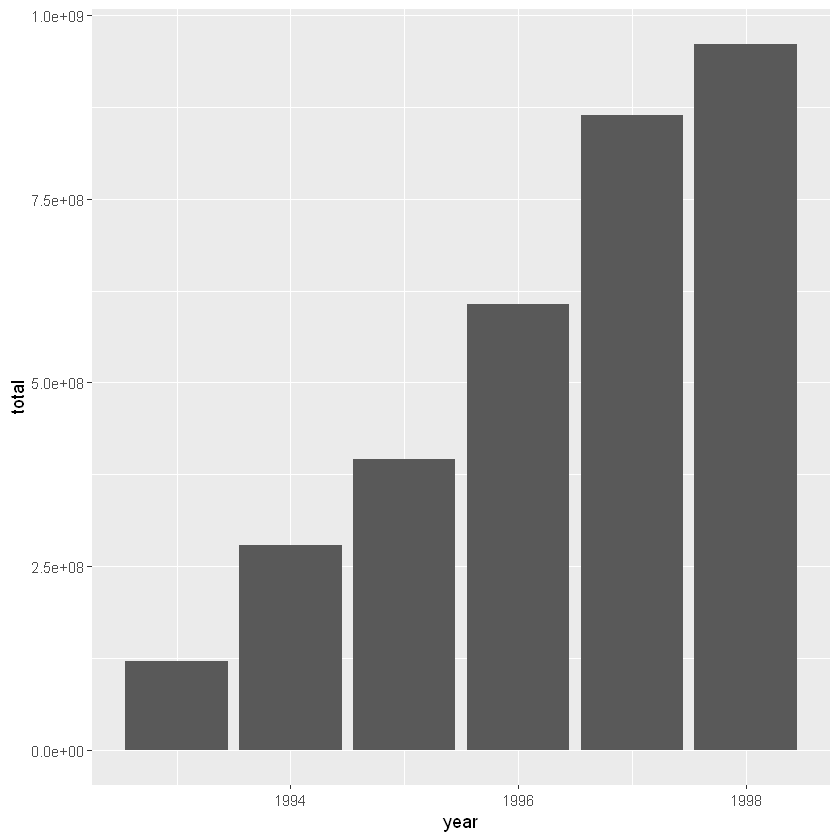

In [112]:
credit = new_df %>% filter(type == 'credit')
ggplot(credit, aes(x = year, y=total))+geom_col()

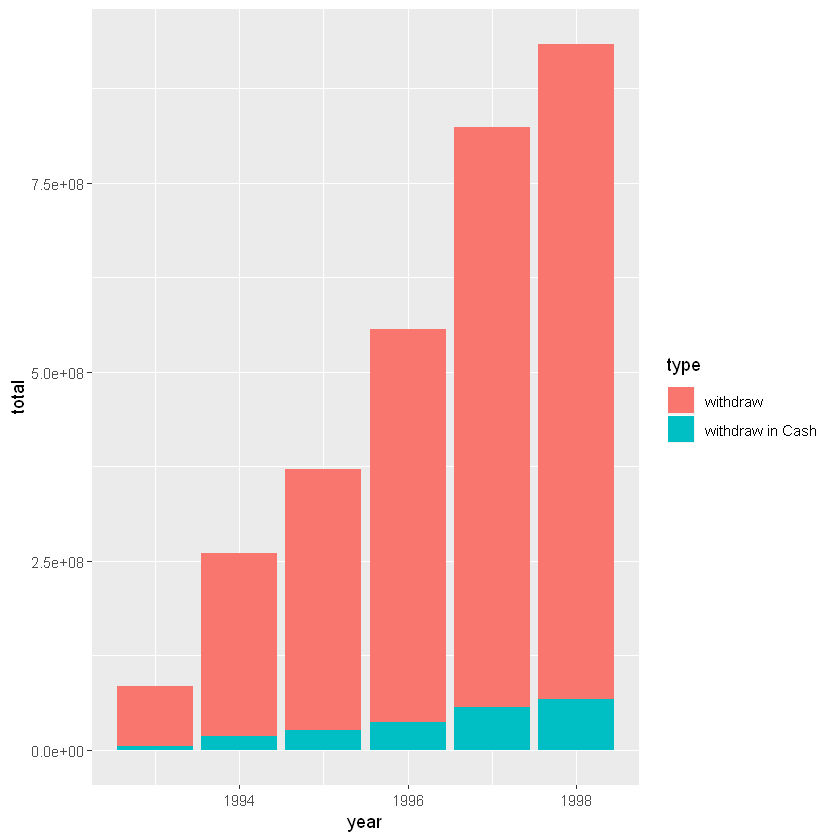

In [110]:
withdraw = new_df %>% filter(type == 'withdraw' | type=="withdraw in Cash")
ggplot(withdraw, aes(x = year, y=total, fill = type))+geom_col()

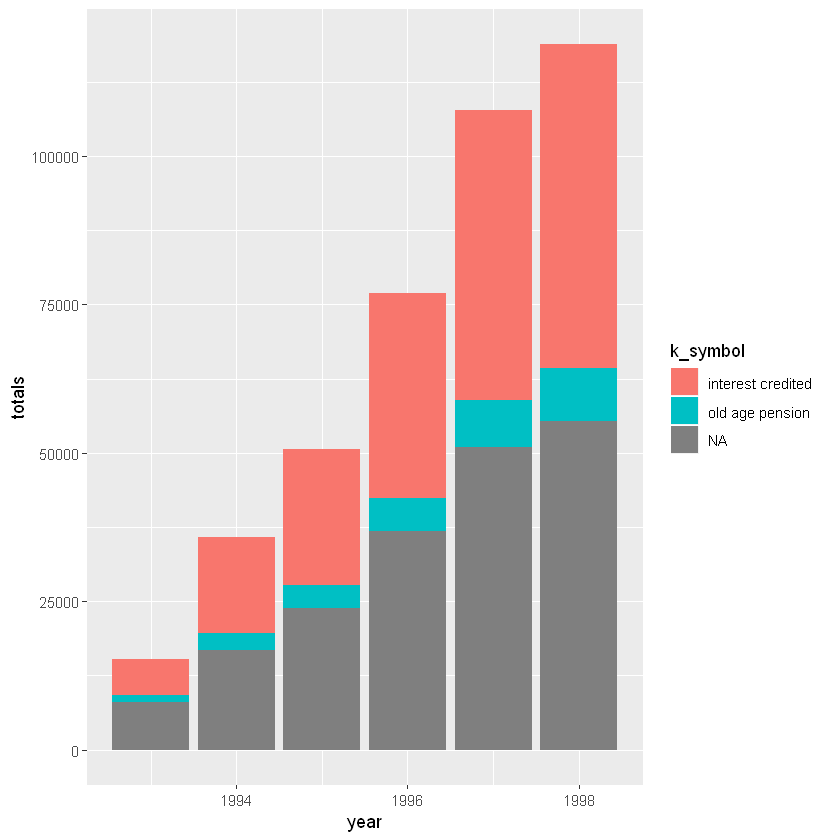

In [114]:
#filtrando e fazendo um df de crédito
df_ksymbol %>% filter(type == 'credit') %>% ggplot(aes(x = year, y = totals, fill = k_symbol))+
  geom_col()

In [116]:
#Avaliação do Ksymbol e pelo ano
df_ksymbol = df_trans %>% group_by(type, year, k_symbol) %>% summarise('totals' =  n())

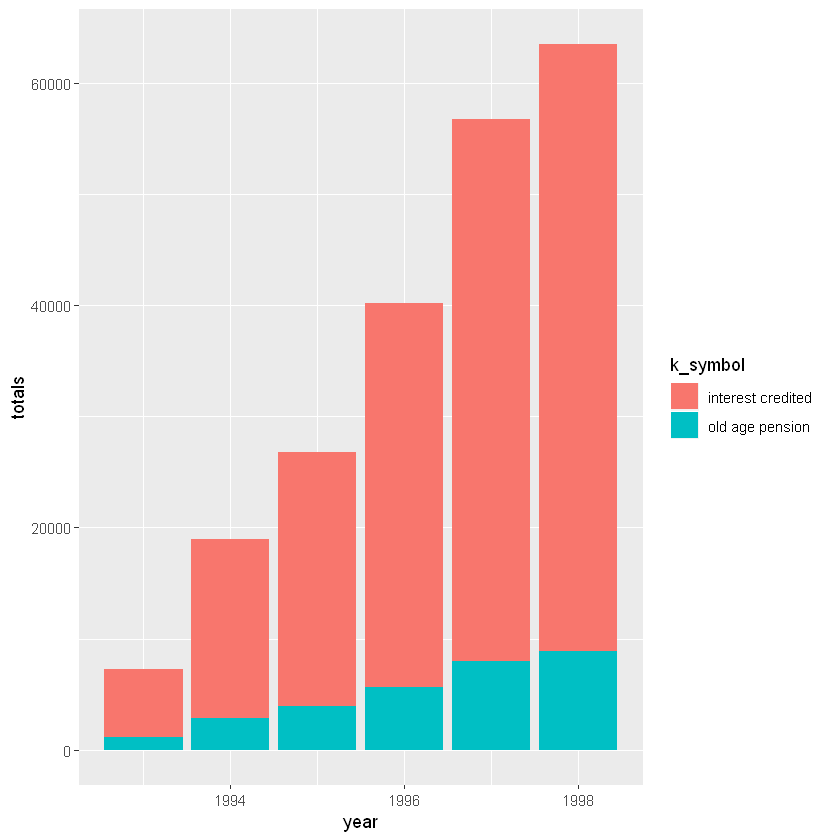

In [117]:
df_ksymbol %>% drop_na() %>% filter(type == 'credit') %>% ggplot(aes(x = year, y = totals, fill = k_symbol))+
  geom_col()

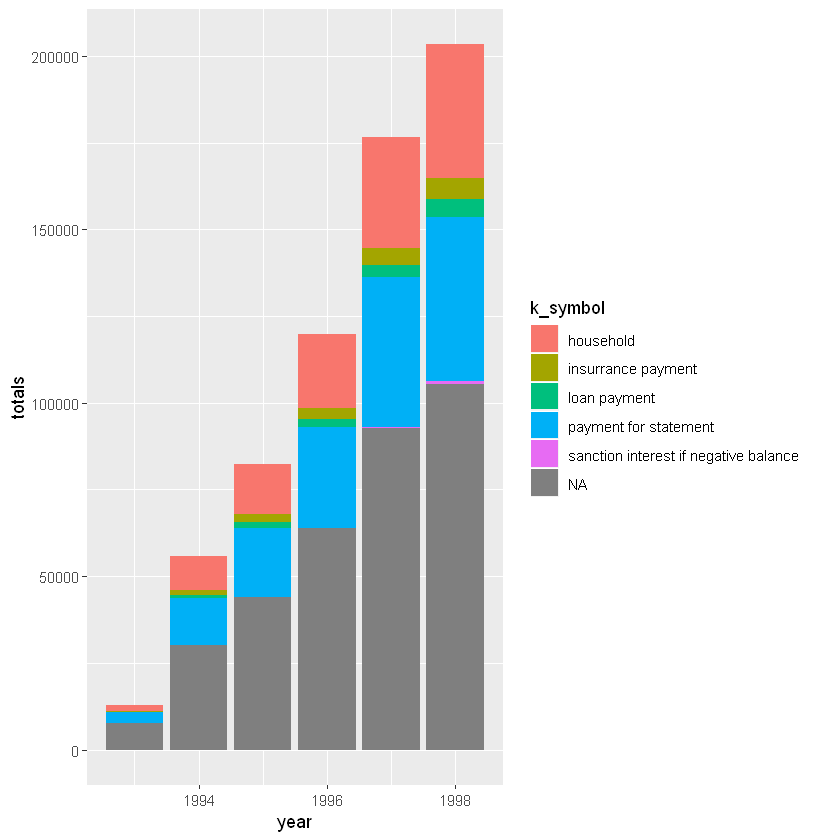

In [118]:
df_ksymbol %>% filter(type == 'withdraw' | type == 'withdraw in Cash') %>% ggplot(aes(x = year, y = totals, fill = k_symbol))+
  geom_col()

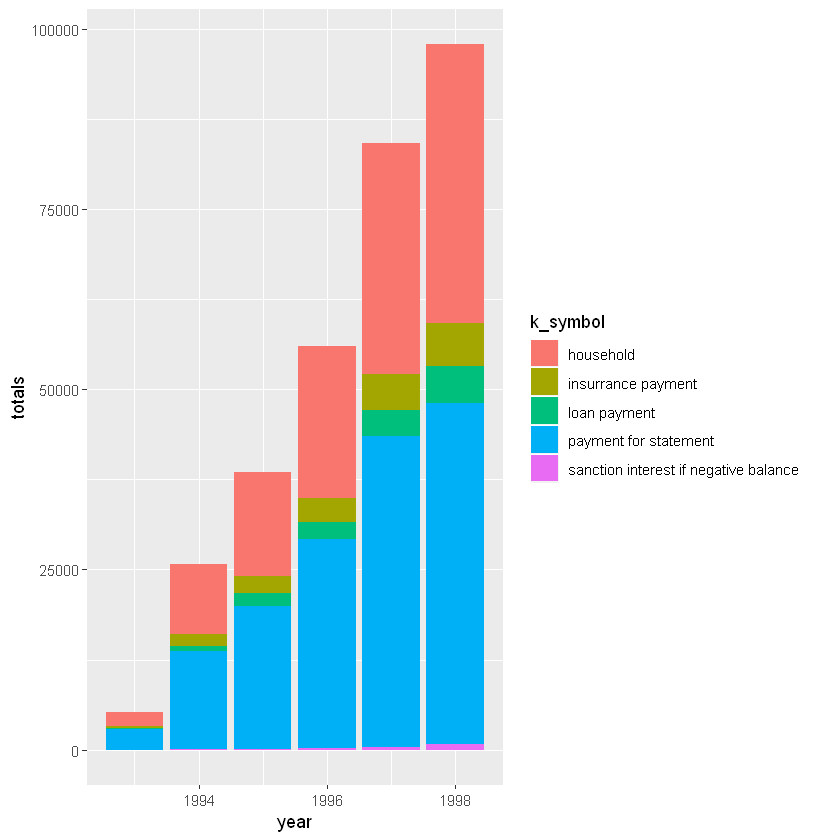

In [119]:
df_ksymbol %>% drop_na() %>% filter(type == 'withdraw' | type == 'withdraw in Cash') %>% ggplot(aes(x = year, y = totals, fill = k_symbol))+
  geom_col()

Avaliando mais detalhadamente o montante das transações, tivemos que retirar algumas transações não identificadas.

Dentro das transações identificadas percebemos que houve um aumento ano a ano de pagamento por contas negativas, é possível peerceber um aumento substancial em pagamentos de contas utilizando o banco e ainda um aumento de despesas de Household.

Enquanto o aumento de pagamento de empréstimos e seguros não teve um aumento tão substancial da mesma maneira que os outros.

Uma das possíveis recomendações é a diversificação de produtos para empréstimos e também para seguros fazendo assim um maior número de clientes movimentar a conta.

## Avaliando a tabela de Cartões de Crédito

In [213]:
# --- Analisando a tabela Credit Card
df_card = read.table('card.asc',header=T,sep=";")
df_card$issued = as.character(df_card$issued)
df_card$issued = ymd_hms(df_card$issued)
df_disp$disp_id == df_disp$client_id
num_clientes = (unique(df_disp$client_id))
length(num_clientes)
length(df_disp$client_id)
length(df_disp$account_id)
length(unique(df_disp$account_id))
#Como o Account ID se repete, existem clientes com mais de uma conta.
#Cada cliente tem um único , disp_id e um único client_id
length(df_disp$disp_id)
length(unique(df_disp$disp_id))

#Trazendo o client_id de cada cliente com base no disp
df <- left_join(df_card, df_disp, by="disp_id")
df <- df %>% rename('card_type' = type.x)
df <- df %>% rename('disp_type' = type.y)
df <- left_join(df, df_client, by ='client_id')
df <- left_join(df, df_account, by = c("account_id" = "account_id", 'region' = 'region', 'district_name' = 'district_name'))
df <- left_join(df, last_status, by = "account_id")

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [37]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [49]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [61]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [73]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [85]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
  [97]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [109]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [121]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [133]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [145]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [157]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [169]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [181]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [193]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [205]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [217]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [229]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [241]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [253]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [265]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [277]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [289]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [301]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [313]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [325]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [337]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [349]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [361]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [373]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [385]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [397]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [409]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [421]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [433]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [445]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [457]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [469]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [481]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [493]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [505]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [517]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [529]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [541]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [553]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [565]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [577]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [589]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [601]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRU

[1] 5369

[1] 5369

[1] 5369

[1] 4500

[1] 5369

[1] 5369

Como o Account ID se repete existem clientes com mais de uma conta , cada cliente único tem um únido disp_id e um único client_id

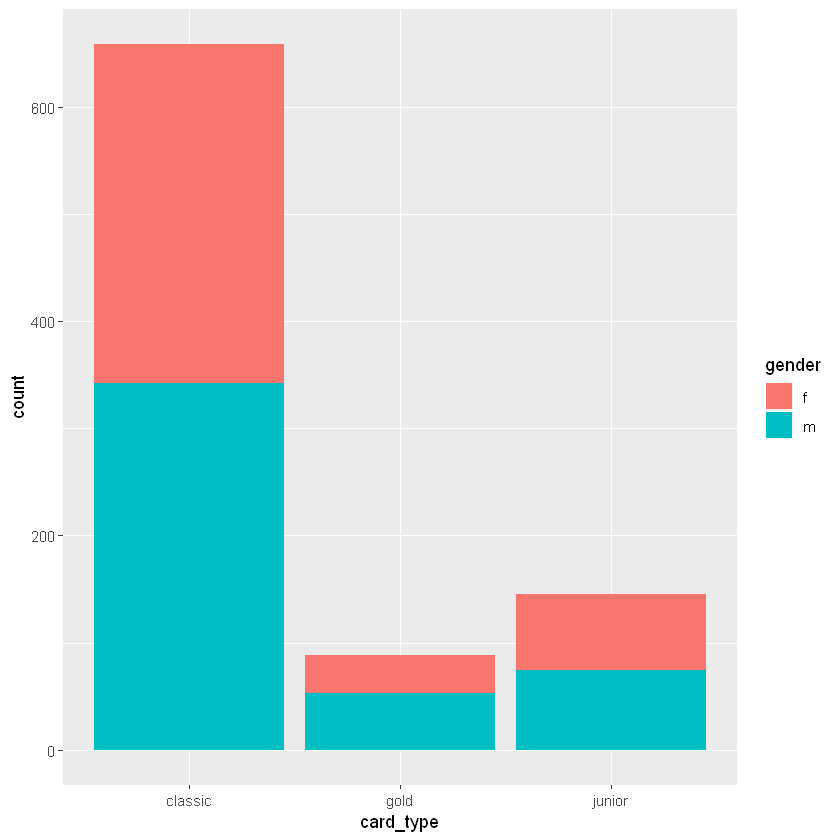

In [214]:
df_card_final <- df
ggplot(df_card_final, aes(x = card_type, fill = gender))+geom_bar()

Avaliando os cartões emitidos por sexo não existe uma distinção muito clara referente ao sexo.

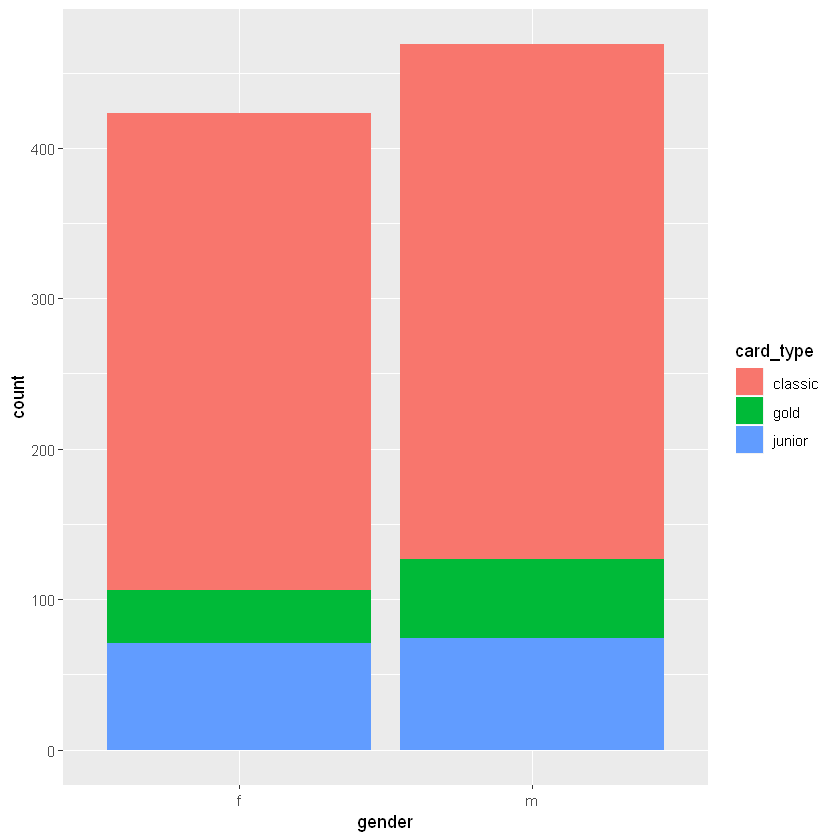

In [215]:
ggplot(df_card_final, aes(x=gender, fill = card_type))+geom_bar()

A Mesma situação ocorre quando relacionamos os tipos de cartão com o sexo. Não podemos através desses gráficos inferir que o sexo influência na emissão do cartão e/ou é fator determinante na decisão do tipo de cartão.

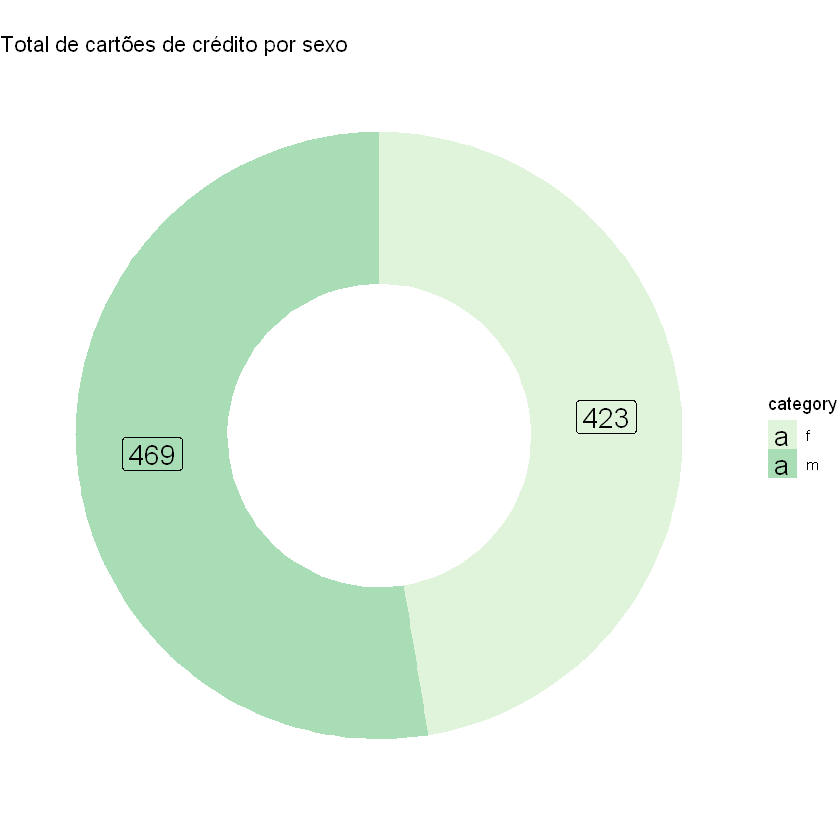

In [216]:
#gráfico de donut
df_gender_card <- df_card_final %>% group_by(gender) %>% summarise('totals' = n())
category <- df_gender_card$gender
count <- df_gender_card$totals
data = data.frame(category, count)
donut(category = category, count = count,"Total de cartões de crédito por sexo")

In [217]:
head(df_client)
df_client_gender = df_client %>% group_by(gender) %>% summarise ("Total" = n())

client_id,gender,birthdate,district_name,region
1,f,1970-12-13,Pisek,south Bohemia
2,m,1945-02-04,Hl.m. Praha,Prague
3,f,1940-10-09,Hl.m. Praha,Prague
4,m,1956-12-01,Kolin,central Bohemia
5,f,1960-07-03,Kolin,central Bohemia
6,m,1919-09-22,Pribram,central Bohemia


In [218]:
df_client_gender

gender,Total
f,2645
m,2724


Como o banco tem mais clientes homens que mulheres é natural que mais homens tenham cartões de crédito apesar disso a proporção  de cartões emitidos é : 

- 17,2% dos homens que possuem conta, possuem cartão de crédito do banco
- 18,0% das mulheres que posseum conta possuem cartão de crédito.

Portanto, apesar do maior número de cartões serem de homens, as mulheres apresentam leve tendência a possuir mais cartões que homens, ainda que o número de cartões emitidos a mulheres seja menor que os emitidos aos homens.

In [219]:
#Gráfico Treemap de cartões por região
df_tree_card = df_card_final %>% group_by(region) %>% summarise ('total' = n())

In [220]:
#Criando função para facilitar criação de chart Treemap.
tree_chart = function(group,values,chart_title, type = 1){
  data = data.frame(group,values)
  data$label = paste(data$group, ',', data$values)
  if(type == 0){
    treemap(data, index = c('label'), vSize = 'values', type = 'index',
            title = chart_title)
  }else{
    treemap(data, index = 'group', vSize = 'values', type = 'index',
            title = chart_title)
  }
  
}

Como fizemos para a função donut, criamos uma função para facilitar a geração de gráficos treemap.

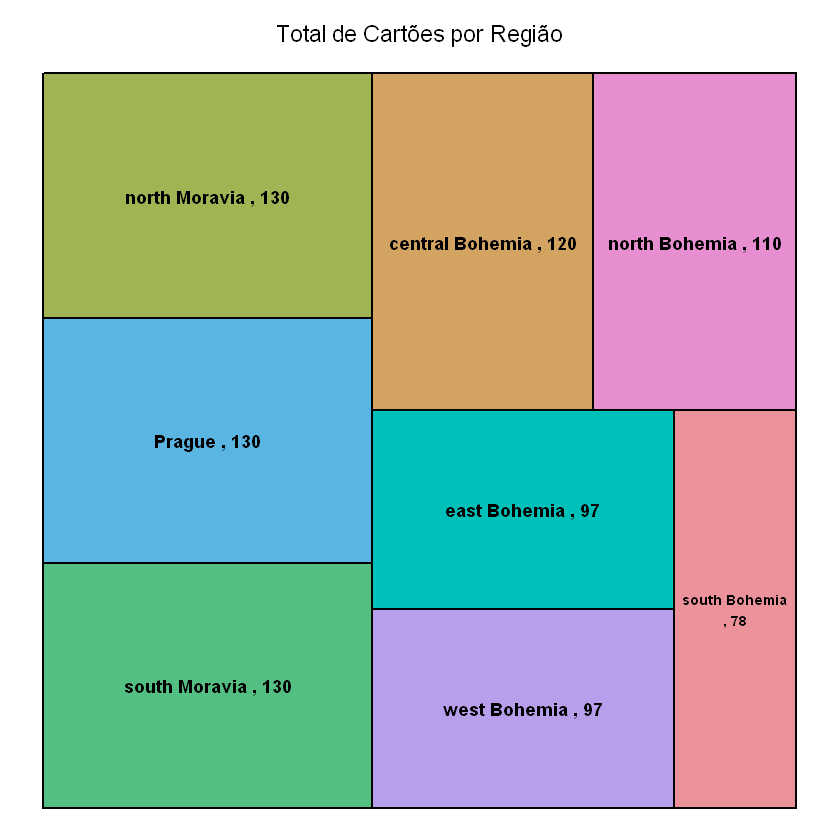

In [221]:
tree_chart(df_tree_card$region,df_tree_card$total,"Total de Cartões por Região",0)

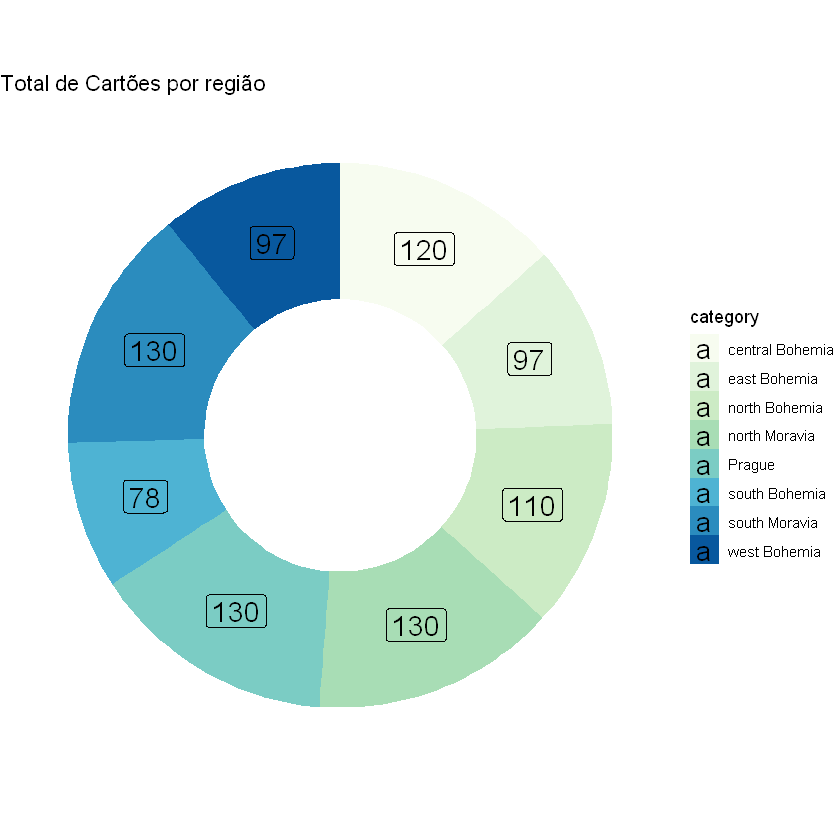

In [222]:
#Fazendo um gráfico de donut para visualizar a distribuição de cartões nas regiões.
category <- df_tree_card$region
count <- df_tree_card$total
data = data.frame(category, count)
donut(category, count,'Total de Cartões por região')

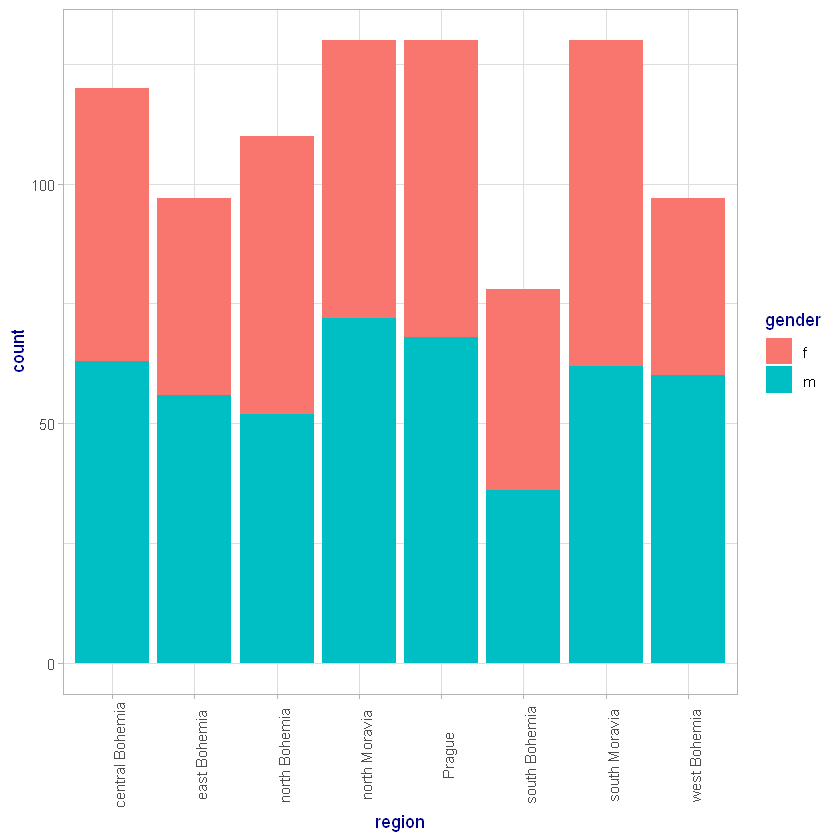

In [223]:
#Gráfico de Cartões por região e sexo
ggplot(df_card_final, aes(x = region, fill = gender))+
  geom_bar()+
  my_theme

In [224]:
#Verificando a quantidade de cartões emitidos ao longo do tempo
summary(df_card_final)
card_issued <- df_card_final %>% group_by(issued) %>% summarise('total' = n(), 'accum') %>% mutate('accum' = cumsum(total)) 

    card_id          disp_id        card_type       issued                   
 Min.   :   1.0   Min.   :    9   classic:659   Min.   :1993-11-07 00:00:00  
 1st Qu.: 229.8   1st Qu.: 1387   gold   : 88   1st Qu.:1997-01-25 12:00:00  
 Median : 456.5   Median : 2938   junior :145   Median :1998-01-06 00:00:00  
 Mean   : 480.9   Mean   : 3512                 Mean   :1997-09-19 05:19:38  
 3rd Qu.: 684.2   3rd Qu.: 4460                 3rd Qu.:1998-08-05 06:00:00  
 Max.   :1247.0   Max.   :13660                 Max.   :1998-12-29 00:00:00  
                                                                             
   client_id       account_id        disp_type      gender         
 Min.   :    9   Min.   :    7   DISPONENT:  0   Length:892        
 1st Qu.: 1387   1st Qu.: 1153   OWNER    :892   Class :character  
 Median : 2938   Median : 2432                   Mode  :character  
 Mean   : 3538   Mean   : 2913                                     
 3rd Qu.: 4460   3rd Qu.: 3698      

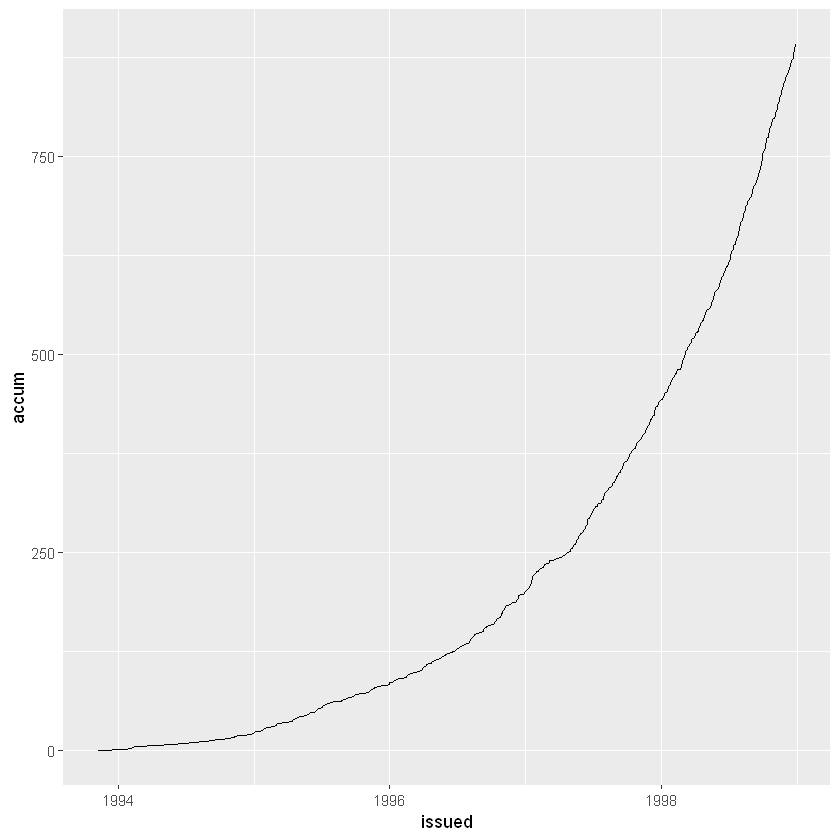

In [225]:
#Observando a tendência de emissão de cartão de crédito.
ggplot(card_issued, aes(x = issued, y=accum))+
  geom_line()

In [226]:
card_issued <- df_card_final %>% group_by(gender,issued) %>% summarise('total' = n()) %>% mutate('accum' = cumsum(total)) 
card_issued$issued = as.character(card_issued$issued)
card_issued$issued

[1] "1993-11-07" "1994-01-19" "1994-02-08" "1994-04-05" "1994-06-01"
  [6] "1994-06-29" "1994-07-21" "1994-09-15" "1994-10-09" "1994-10-21"
 [11] "1994-11-10" "1994-12-04" "1994-12-30" "1995-01-07" "1995-01-16"
 [16] "1995-01-27" "1995-02-11" "1995-02-21" "1995-03-03" "1995-03-05"
 [21] "1995-03-30" "1995-04-14" "1995-04-24" "1995-05-09" "1995-05-21"
 [26] "1995-06-16" "1995-06-17" "1995-06-27" "1995-07-03" "1995-08-24"
 [31] "1995-08-25" "1995-11-04" "1995-11-06" "1995-12-25" "1995-12-30"
 [36] "1996-01-25" "1996-02-04" "1996-02-21" "1996-03-09" "1996-03-19"
 [41] "1996-03-30" "1996-04-05" "1996-04-10" "1996-04-20" "1996-04-21"
 [46] "1996-04-24" "1996-05-08" "1996-05-17" "1996-05-30" "1996-06-08"
 [51] "1996-06-26" "1996-06-28" "1996-07-24" "1996-08-03" "1996-08-05"
 [56] "1996-08-08" "1996-08-10" "1996-08-12" "1996-08-17" "1996-08-31"
 [61] "1996-09-02" "1996-09-11" "1996-10-08" "1996-10-13" "1996-10-14"
 [66] "1996-10-19" "1996-10-21" "1996-10-25" "1996-10-28" "1996-11-02"
 [71] "1996-11-04" "1996-11-07" "1996-11-14" "1996-11-20" "1996-11-23"
 [76] "1996-12-07" "1996-12-10" "1996-12-11" "1996-12-27" "1996-12-31"
 [81] "1997-01-09" "1997-01-11" "1997-01-13" "1997-01-14" "1997-01-16"
 [86] "1997-01-17" "1997-01-20" "1997-01-22" "1997-01-26" "1997-02-03"
 [91] "1997-02-16" "1997-02-17" "1997-02-19" "1997-02-21" "1997-03-04"
 [96] "1997-03-05" "1997-03-15" "1997-03-24" "1997-04-11" "1997-04-18"
[101] "1997-04-20" "1997-04-23" "1997-05-01" "1997-05-02" "1997-05-06"
[106] "1997-05-08" "1997-05-09" "1997-05-12" "1997-05-17" "1997-05-22"
[111] "1997-05-23" "1997-05-26" "1997-05-28" "1997-06-06" "1997-06-10"
[116] "1997-06-11" "1997-06-14" "1997-06-15" "1997-06-16" "1997-06-17"
[121] "1997-06-22" "1997-06-28" "1997-06-29" "1997-07-03" "1997-07-07"
[126] "1997-07-08" "1997-07-20" "1997-07-24" "1997-07-28" "1997-07-29"
[131] "1997-07-30" "1997-07-31" "1997-08-01" "1997-08-06" "1997-08-12"
[136] "1997-08-17" "1997-08-21" "1997-08-22" "1997-08-28" "1997-08-31"
[141] "1997-09-02" "1997-09-05" "1997-09-07" "1997-09-17" "1997-09-21"
[146] "1997-09-22" "1997-09-23" "1997-10-01" "1997-10-07" "1997-10-08"
[151] "1997-10-13" "1997-10-22" "1997-10-25" "1997-10-26" "1997-10-29"
[156] "1997-11-06" "1997-11-08" "1997-11-11" "1997-11-18" "1997-11-19"
[161] "1997-11-21" "1997-11-24" "1997-11-28" "1997-11-30" "1997-12-02"
[166] "1997-12-03" "1997-12-05" "1997-12-06" "1997-12-09" "1997-12-12"
[171] "1997-12-13" "1997-12-15" "1997-12-17" "1997-12-20" "1997-12-22"
[176] "1997-12-23" "1997-12-25" "1997-12-28" "1997-12-29" "1998-01-06"
[181] "1998-01-07" "1998-01-08" "1998-01-13" "1998-01-21" "1998-01-24"
[186] "1998-01-25" "1998-01-28" "1998-01-31" "1998-02-02" "1998-02-04"
[191] "1998-02-08" "1998-02-09" "1998-02-13" "1998-02-21" "1998-02-24"
[196] "1998-02-25" "1998-02-26" "1998-02-27" "1998-03-01" "1998-03-02"
[201] "1998-03-03" "1998-03-04" "1998-03-07" "1998-03-09" "1998-03-11"
[206] "1998-03-13" "1998-03-15" "1998-03-23" "1998-03-24" "1998-03-30"
[211] "1998-04-01" "1998-04-02" "1998-04-10" "1998-04-11" "1998-04-16"
[216] "1998-04-17" "1998-04-18" "1998-04-21" "1998-04-25" "1998-04-26"
[221] "1998-04-27" "1998-04-29" "1998-04-30" "1998-05-02" "1998-05-09"
[226] "1998-05-12" "1998-05-14" "1998-05-15" "1998-05-18" "1998-05-19"
[231] "1998-05-25" "1998-05-31" "1998-06-04" "1998-06-05" "1998-06-07"
[236] "1998-06-08" "1998-06-10" "1998-06-15" "1998-06-16" "1998-06-17"
[241] "1998-06-19" "1998-06-21" "1998-06-23" "1998-06-30" "1998-07-01"
[246] "1998-07-02" "1998-07-05" "1998-07-06" "1998-07-07" "1998-07-08"
[251] "1998-07-09" "1998-07-12" "1998-07-13" "1998-07-14" "1998-07-15"
[256] "1998-07-18" "1998-07-19" "1998-07-20" "1998-07-23" "1998-07-25"
[261] "1998-07-26" "1998-07-27" "1998-07-29" "1998-07-30" "1998-08-01"
[266] "1998-08-02" "1998-08-05" "1998-08-06" "1998-08-08" "1998-08-09"
[271] "1998-08-10" "1998-08-13" "1998-08-14" "1998-08-16" "1998-08-19"
[276] "1998-08-20" "1998-08-21" "1998-08-24" "1998-08-25" "1998-08-30"
[281] "1998-09-01" "1998-0

In [227]:
card_by_year <- card_issued %>% mutate('year' = year(issued)) %>% group_by(year) %>% summarise('Total'=sum(accum))

In [228]:
card_by_year

year,Total
1993,1
1994,135
1995,1695
1996,7703
1997,33116
1998,107306


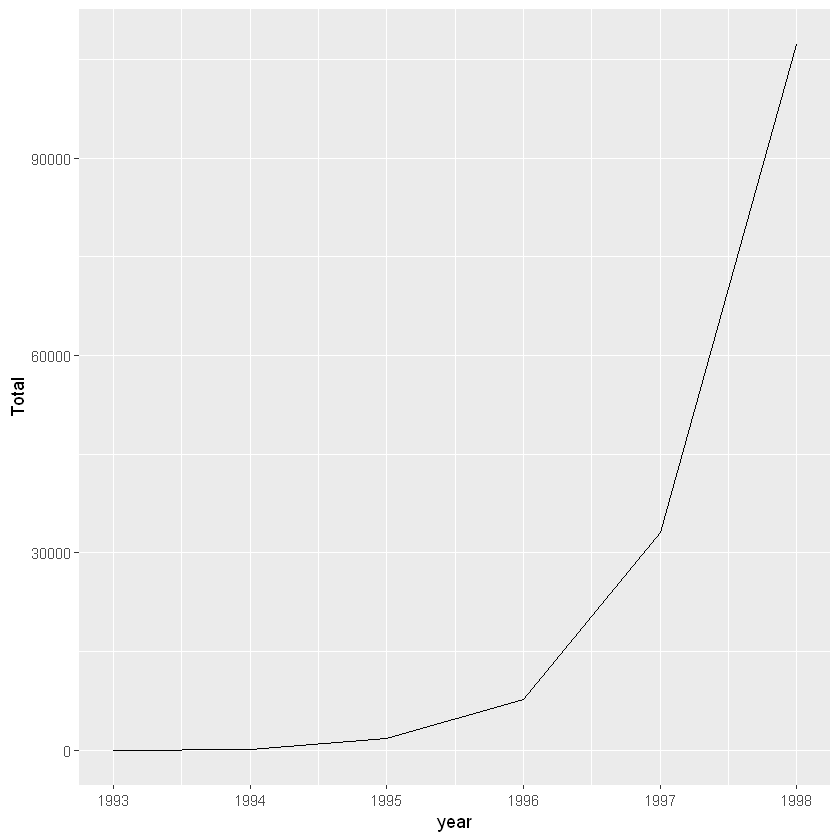

In [229]:
#Podemos perceber a evolução da emissão de cartões de créditos por genero é quase que proporcional.
ggplot(card_by_year, aes(x = year, y=Total))+
  geom_line()

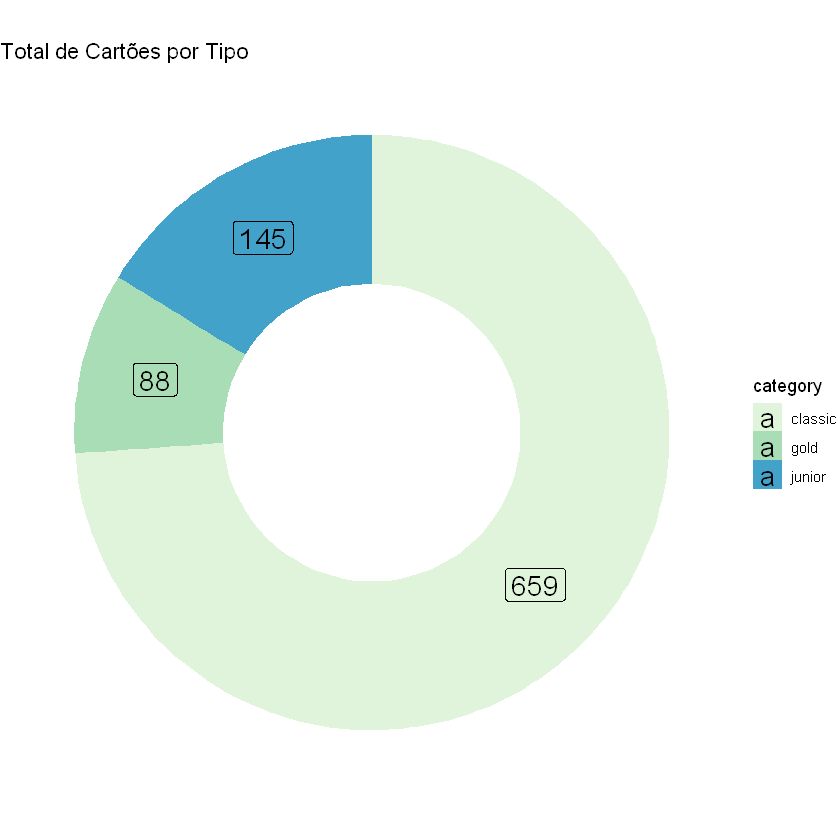

In [230]:
#vamos verificar os tipos de cartão
card_type <-  df_card_final %>% group_by(card_type) %>% summarise('total' = n())
category <- card_type$card_type
count <- card_type$total
data = data.frame(category, count)
donut(category,count,'Total de Cartões por Tipo')

In [231]:
#vamos verificar a influencia da balanço no tipo de cartão
today = as.Date(ymd('1999-01-01')) #Considerado o última dia de 1999
is.Date(today) 

[1] TRUE

In [232]:
df_card_final

card_id,disp_id,card_type,issued,client_id,account_id,disp_type,gender,birthdate,district_name,...,average_salary,account_age,last_balance,total_retiradas,total_credit,first_trans,n_negatives,firstNegativeDate,LastNeagtiveDate,negative
1005,9285,classic,1993-11-07,9593,7753,OWNER,f,1968-01-28,Ostrava - mesto,...,10673,7 days,60100.6,3143260.8,3203362.4,1993-02-08,0,NA,NA,FALSE
104,588,classic,1994-01-19,588,489,OWNER,f,1960-10-20,Trebic,...,NA,NA days,43313.2,1161981.2,1205294.3,1993-05-17,0,NA,NA,FALSE
747,4915,classic,1994-02-05,4915,4078,OWNER,m,1963-07-19,Teplice,...,9317,7 days,117561.4,1731363.6,1848925.2,1993-01-30,0,NA,NA,FALSE
70,439,classic,1994-02-08,439,361,OWNER,f,1968-09-12,Trutnov,...,8541,7 days,34971.3,1777963.0,1812934.7,1993-02-27,0,NA,NA,FALSE
577,3687,classic,1994-02-15,3687,3050,OWNER,m,1972-02-06,Semily,...,NA,NA days,55904.2,3011686.2,3067590.6,1993-05-08,0,NA,NA,FALSE
377,2429,classic,1994-03-03,2429,1999,OWNER,m,1973-11-22,Karvina,...,10177,7 days,41082.9,1670540.6,1711623.8,1993-06-06,0,NA,NA,FALSE
721,4680,junior,1994-04-05,4680,3883,OWNER,f,1979-05-24,Olomouc,...,8994,7 days,46451.1,454778.2,501229.5,1993-03-15,0,NA,NA,FALSE
437,2762,classic,1994-06-01,2762,2282,OWNER,f,1953-04-23,Rokycany,...,8843,6 days,104051.3,3143832.0,3247883.5,1993-09-17,0,NA,NA,FALSE
188,1146,classic,1994-06-19,1146,950,OWNER,m,1965-11-14,Brno - mesto,...,NA,NA days,85923.1,1426691.4,1512615.0,1993-08-26,0,NA,NA,FALSE
13,87,classic,1994-06-29,87,73,OWNER,f,1946-11-17,Olomouc,...,8994,6 days,61919.5,1251330.2,1313249.9,1993-11-08,0,NA,NA,FALSE


In [233]:
df_card_final$issued = as.character(df_card_final$issued)
df_card_final$issued = as.Date(df_card_final$issued)
df_card_final <- df_card_final %>% mutate('age' = round((today - birthdate)/360), 'card_age' = (today-issued))
df <- df_card_final
df <- df %>% mutate ('age2' = today - birthdate)
df_card_final$card_age2 = NULL

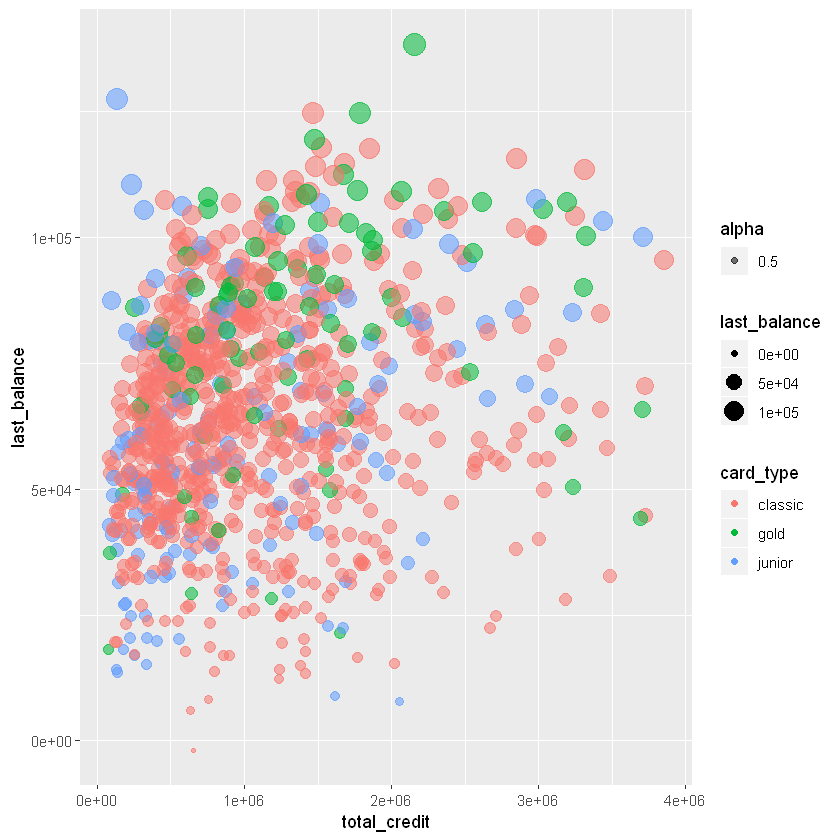

In [234]:
ggplot(df_card_final, aes(x = total_credit, y=last_balance, color = card_type, size = last_balance, alpha = 0.5))+
  geom_point()

Nesse gráfico podemos avaliar a distribuição de cartões pelo balanço (último saldo) do cliente e o total de valores que ele creditou durante o seu histórico de conta ainda podemos ver qual o tipo de cartão.

Com isso podemos avaliar os clientes que apresentam um balanço alto e um cartão clássico ou junior , oferece-los diferentes tipos de produtos.

Percebe-se também que a quantidade de cartões gold é pequena haja visto a quantidade de pessoas que possuem um alto balanço, ou altos valores de movimentação

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


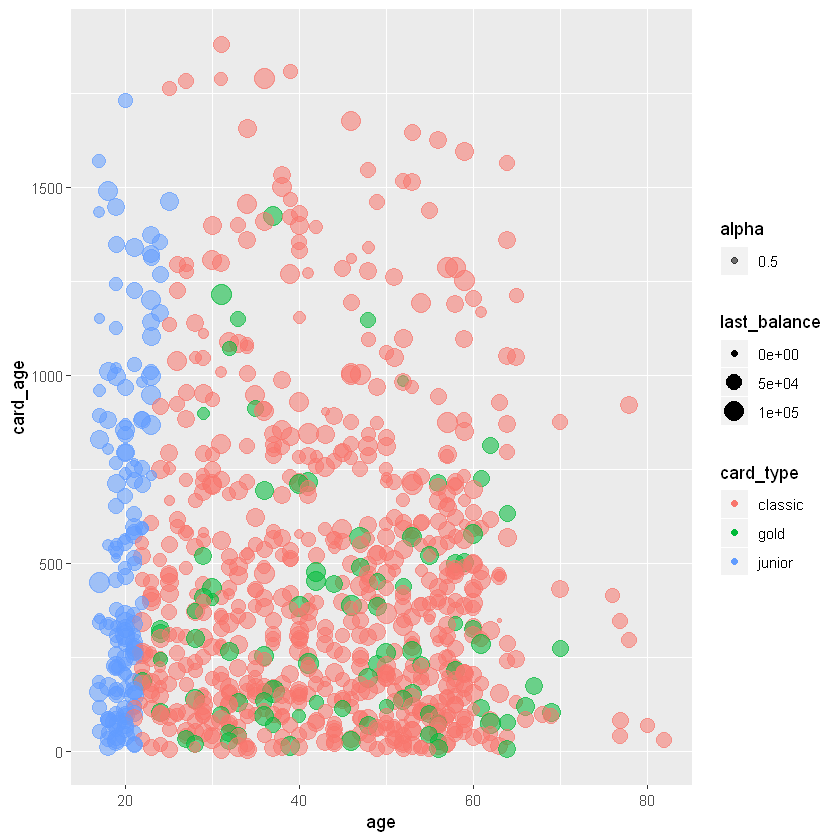

In [235]:
ggplot(df_card_final, aes(x = age, y = card_age, color = card_type, size = last_balance, alpha = 0.5))+
  geom_point()

Com essa avaliação podemos perceber que os cartões Junior são cartões para pessoas na faixa de 20 anos de idade e os cartões classic e gold não tem relevancia com a idade. Porém podemos perceber que existem cartões jr. com muito tempo de uso e esse cartão pode ser migrado para uma faixa acima dependendo da renda do cliente.

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


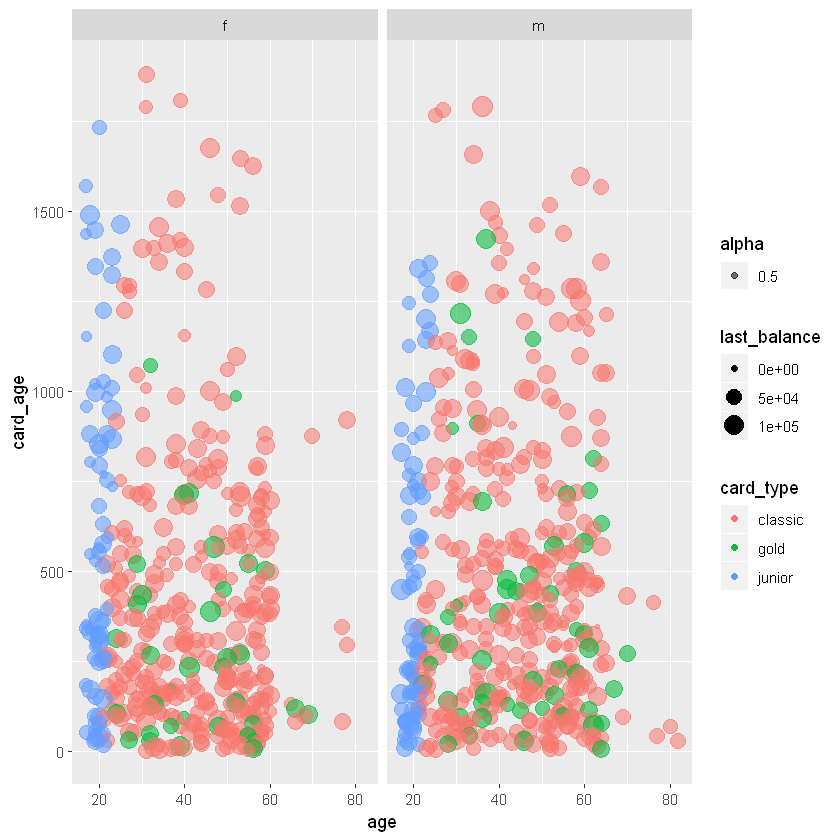

In [236]:
ggplot(df_card_final, aes(x = age, y = card_age, color = card_type, size = last_balance, alpha = 0.5))+
  geom_point()+
  facet_wrap(~ gender)

Mais uma vez avaliando as referências com sexo pudemos perceber que não o sexo não é um fator determinante na escolha do tipo de cartão

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.
`geom_smooth()` using method = 'loess' and formula 'y ~ x'


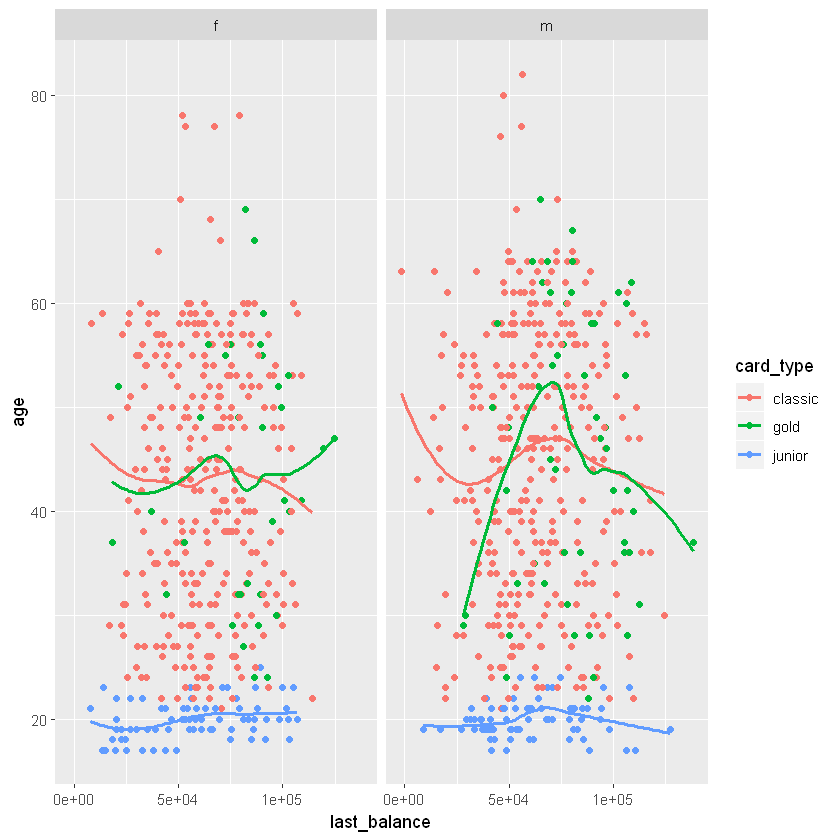

In [237]:
ggplot(df_card_final, aes(x = last_balance, y = age, color = card_type))+
  geom_point()+
  geom_smooth(se = FALSE)+
  facet_wrap(~ gender)

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


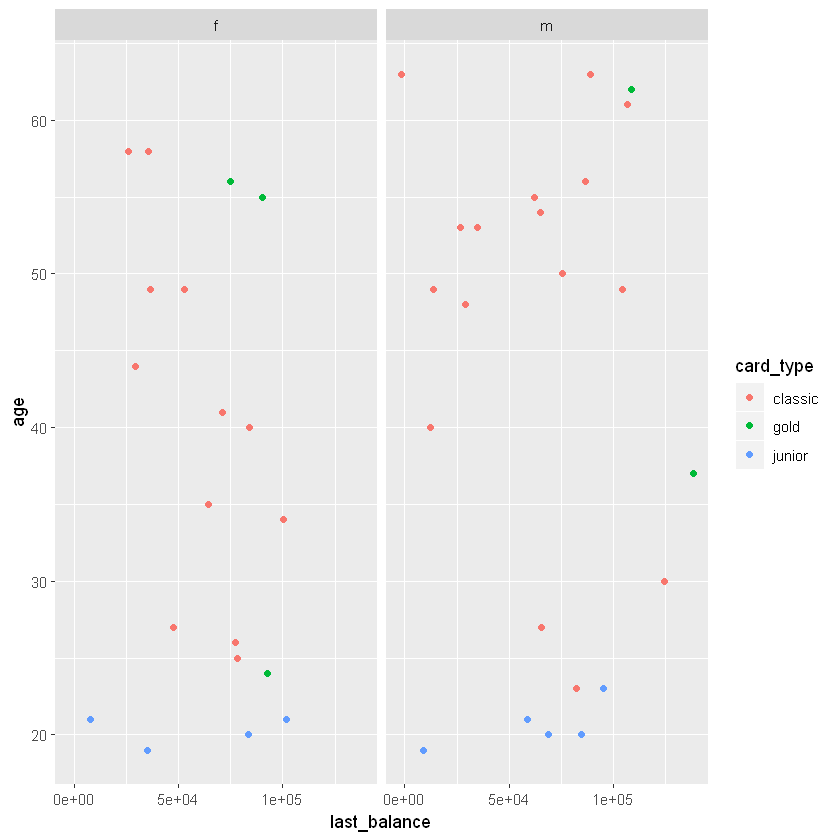

In [238]:
df_card_final %>% filter(n_negatives > 0) %>%
ggplot(aes(x = last_balance, y = age, color = card_type))+
  geom_point()+
  facet_wrap(~ gender)

Avalinado os cartões de possuídos por contas que ja tiveram o saldo negativado, não foi possível encontrar nenhuma referência relevante nesse tipo de análise. Parecendo ser então que a idade não é um fator relevante se o cliente será um devedor. Mais para frente no nosso estudo testaremos essa hipotese com inferências.

In [239]:
#Tivemos 42 pessoas que ficaram negativas e possuem cartões de créditos
df_card_negatives = df_card_final %>% filter(n_negatives > 0)

Com a série de gráficos abaixo, poderemos visualizar a relação entre os possuidores de cartão de crédito que ja tem histórico negativo com o banco (Ficaram com saldo negativo) por região, sexo e tipo de cartão.

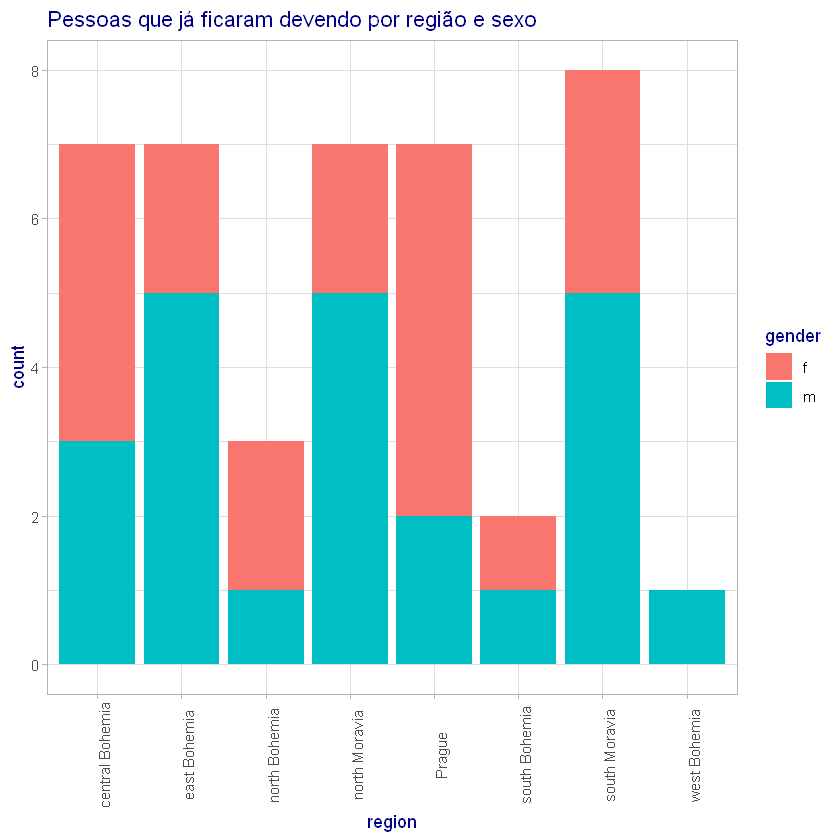

In [240]:
ggplot(df_card_negatives,aes(x = region, fill = gender))+
  geom_bar()+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

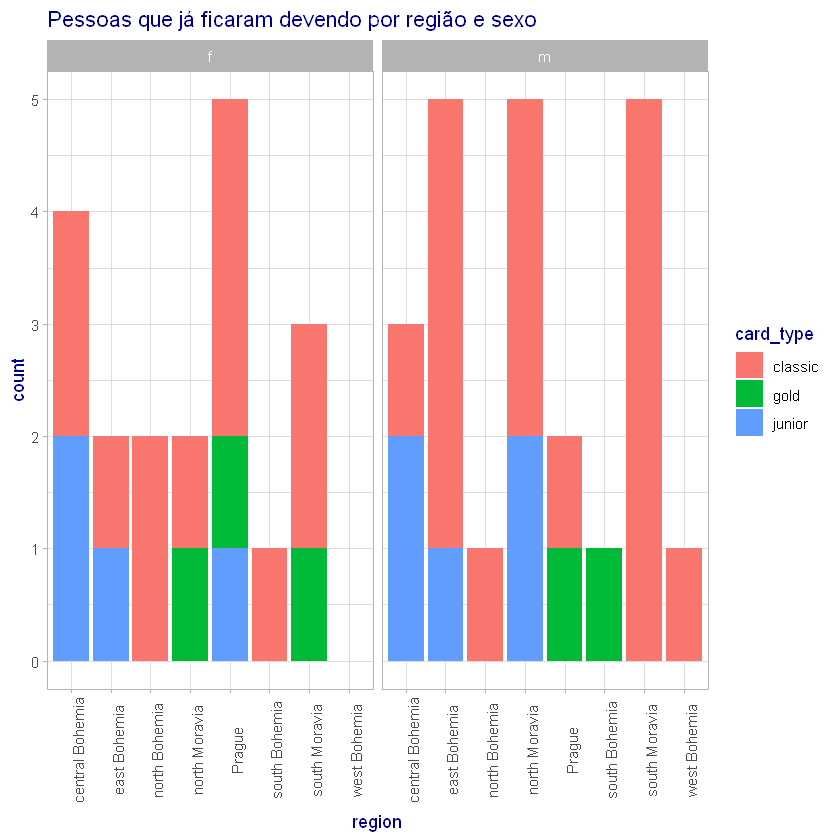

In [241]:
ggplot(df_card_negatives,aes(x = region, fill = card_type))+
    geom_bar()+
    facet_wrap(~ gender)+
    ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

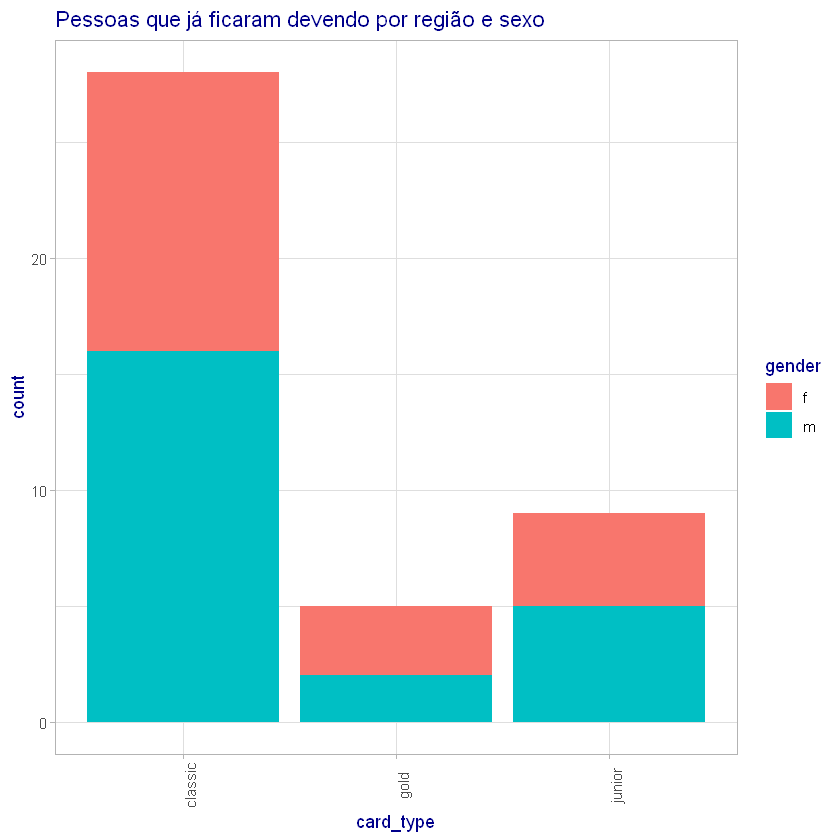

In [242]:
ggplot(df_card_negatives,aes(x = card_type, fill = gender))+
  geom_bar()+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

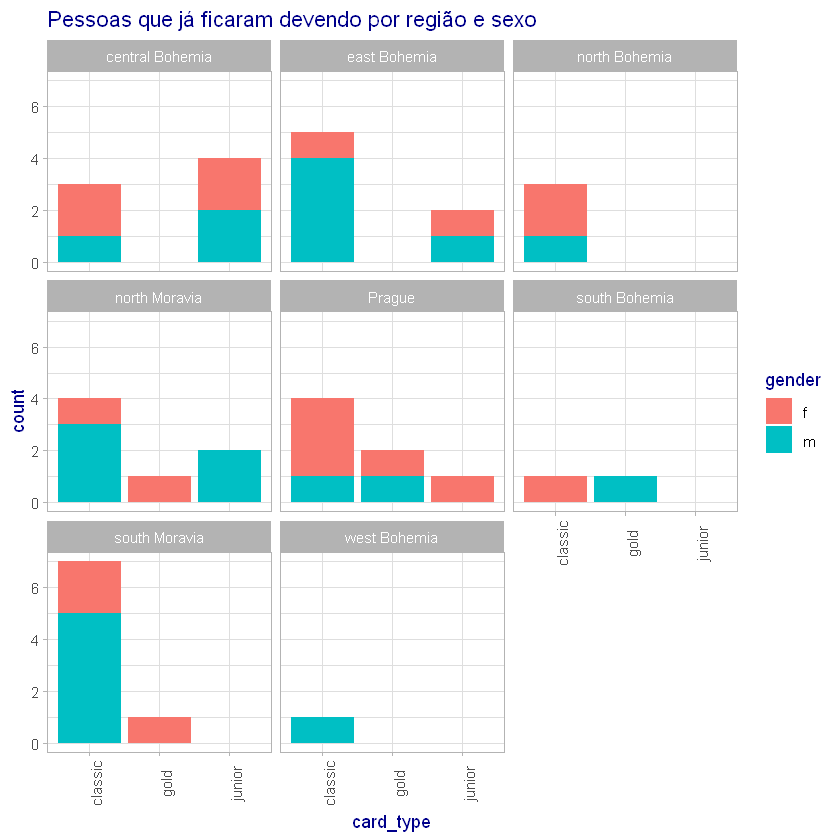

In [244]:
ggplot(df_card_negatives,aes(x = card_type, fill = gender))+
  geom_bar()+
  facet_wrap(~region)+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

In [245]:
df <- df_trans %>% group_by(account_id, year) %>% summarise('year_credit' = sum(credit), 'montly_issue' = sum(credit)/12)
df <- df %>% group_by(account_id) %>% summarise('yearlyprofits' = mean(year_credit), 'montly_revenue' = mean(montly_issue))

In [246]:
account_revenue <- df
df_card_final <- left_join(df_card_final, account_revenue, by = 'account_id')

Com a tabela Revenue , conseguimos avaliar o total de entradas durante o período e calcular a renda média de cada um dos clientes.

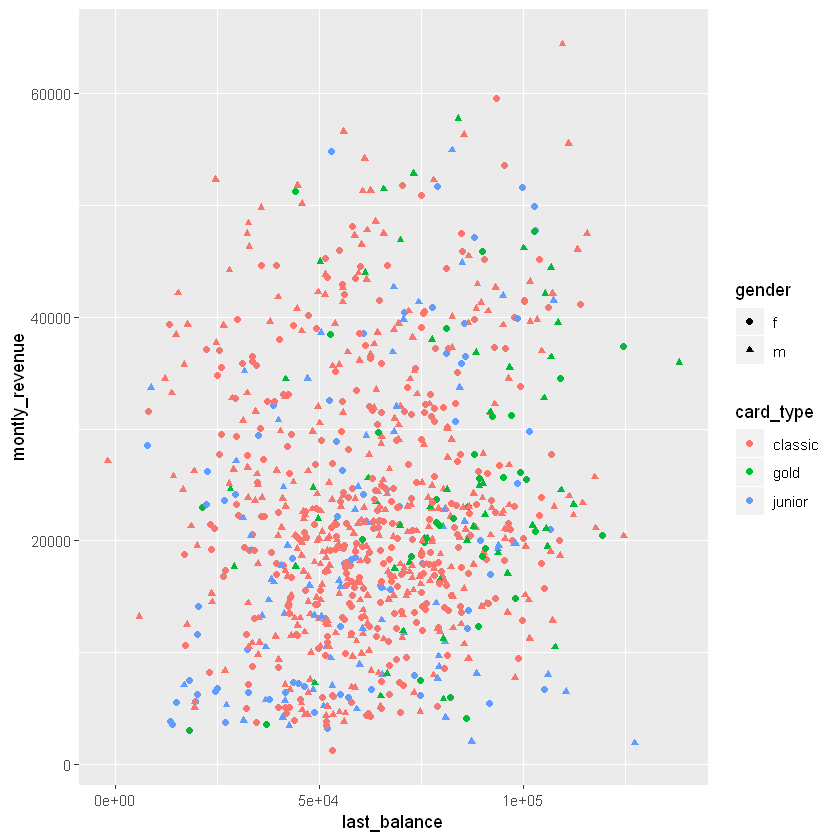

In [247]:
ggplot(df_card_final)+
  geom_point(aes(x = last_balance, y = montly_revenue, color = card_type, shape = gender))

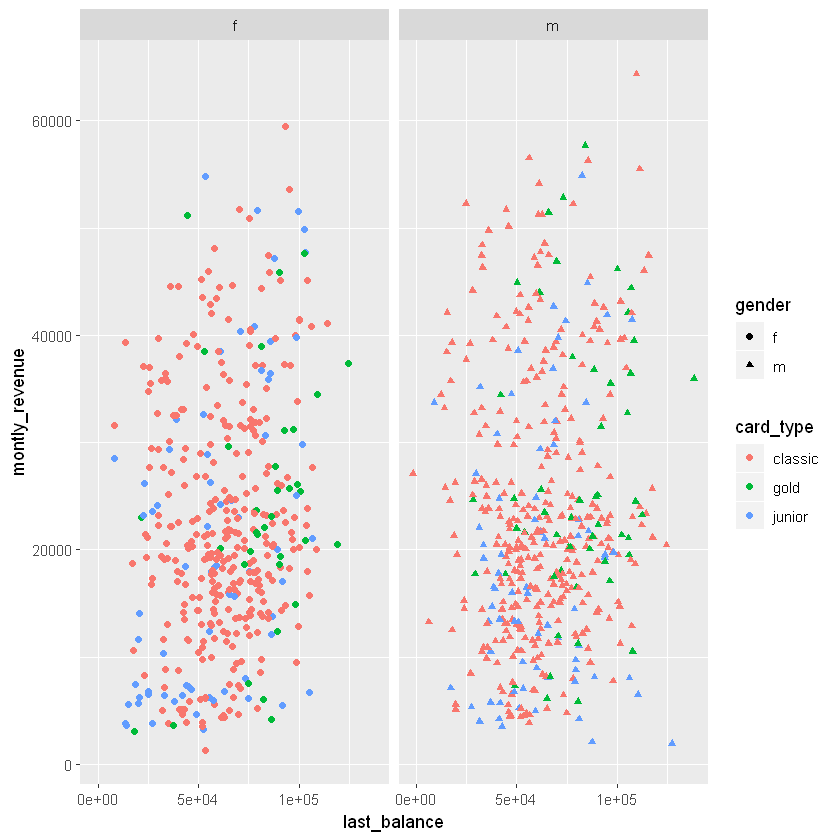

In [248]:
ggplot(df_card_final)+
  geom_point(aes(x = last_balance, y = montly_revenue, color = card_type, shape = gender ))+
  facet_wrap(~gender)

Com o gráfico acima podemos perceber que existe uma linha de corte de contas as quais podem-se realizar um upgrade do cartão de crédito e oferecer produtos mais "premium" pois possuem alta receita mensal e também possuem um saldo de conta positivo . O que diminui substancialmente o risco de inadimplência. Testaremos essa hipótese mais para frente.

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


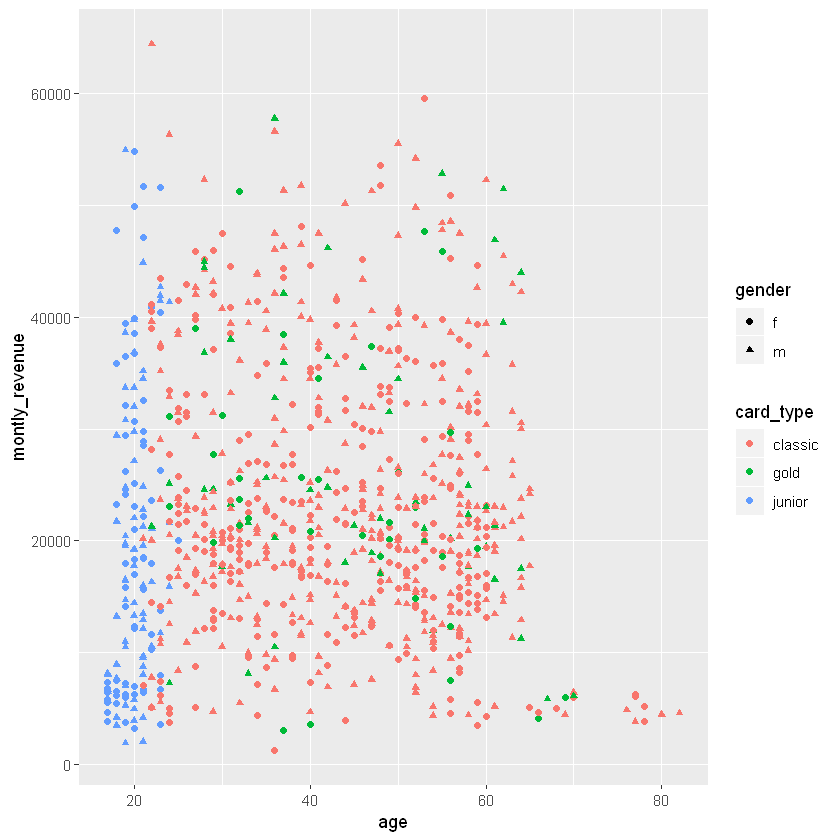

In [249]:
ggplot(df_card_final, aes(x = age, y = montly_revenue, color = card_type, shape = gender ))+
  geom_point()

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


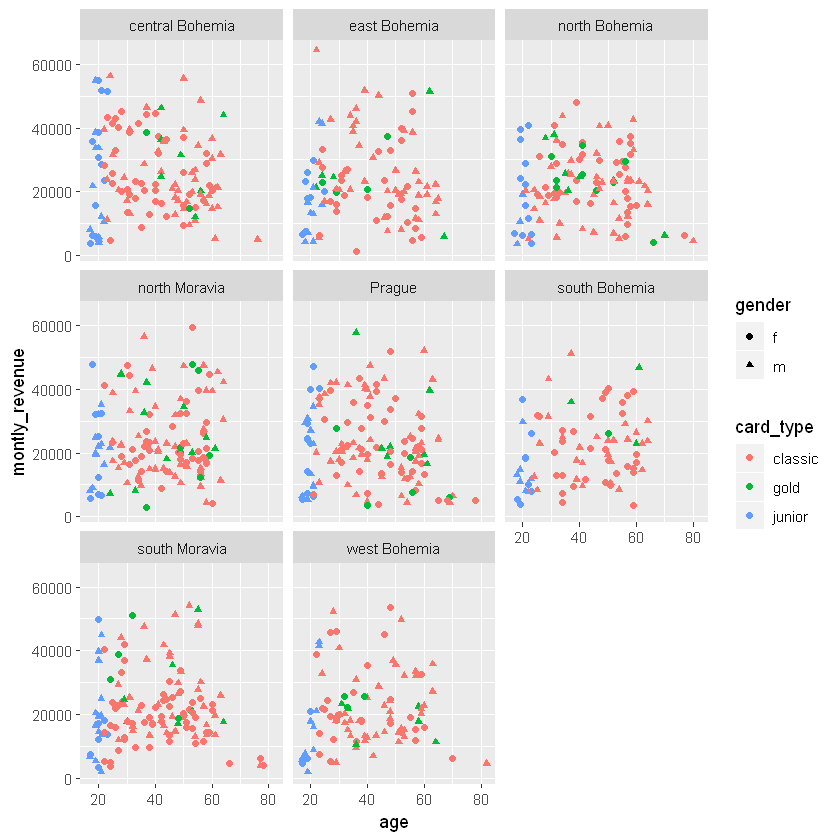

In [250]:
ggplot(df_card_final, aes(x = age, y = montly_revenue, color = card_type, shape = gender))+
  geom_point()+
  facet_wrap(~region)

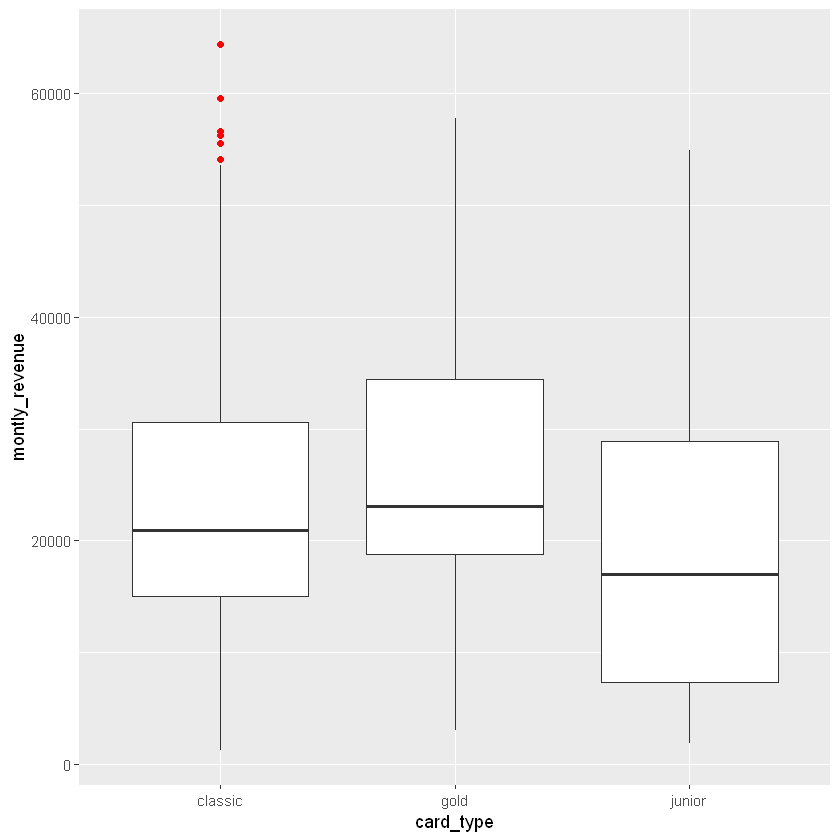

In [251]:
#avaliando o tipo do cartão pela receita mensal
ggplot(df_card_final, aes(x = card_type, y = montly_revenue))+
  geom_boxplot(outlier.colour = 'red')

Com o boxplot fica claro que existem clientes com receita muito maior que a média. Esses clientes são potênciais alvos para receberem ofertas de produtos diferenciados devido a sua receita e maior capacidade de gastos.

Avaliando a receita pela região.

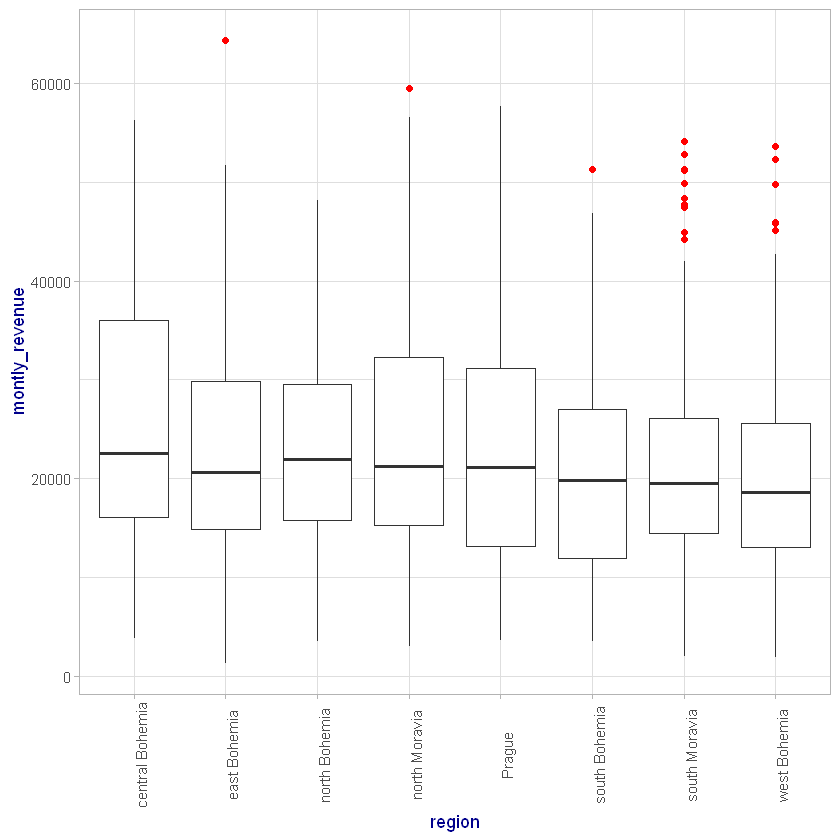

In [252]:
#avaliando o tipo do cartão pela receita mensal
ggplot(df_card_final, aes(x = region, y = montly_revenue))+
  geom_boxplot(outlier.colour = 'red')+
  my_theme

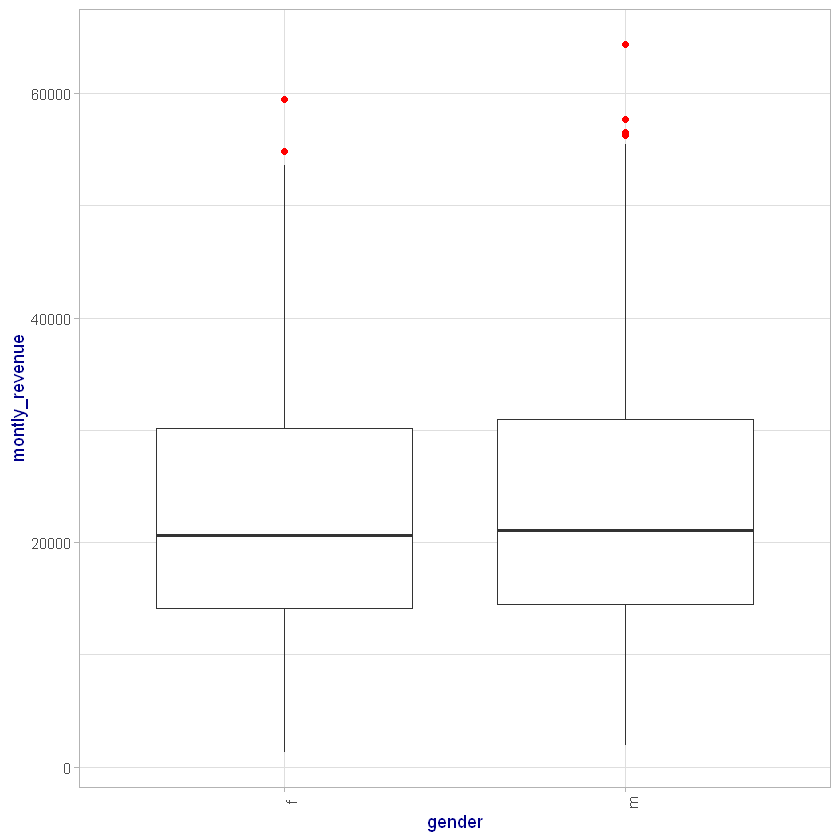

In [253]:
#avaliando o tipo do cartão pelo sexo
ggplot(df_card_final, aes(x = gender, y = montly_revenue))+
  geom_boxplot(outlier.colour = 'red')+
  my_theme

Através desse gráfico é possível avaliar que não existe uma diferença muito grande entre as receitas médias de homens e mulheres no que diz respeito aos clientes do banco.

## Agora avaliaremos as pessoas que ja ficaram devendo para o banco ao menos uma vez

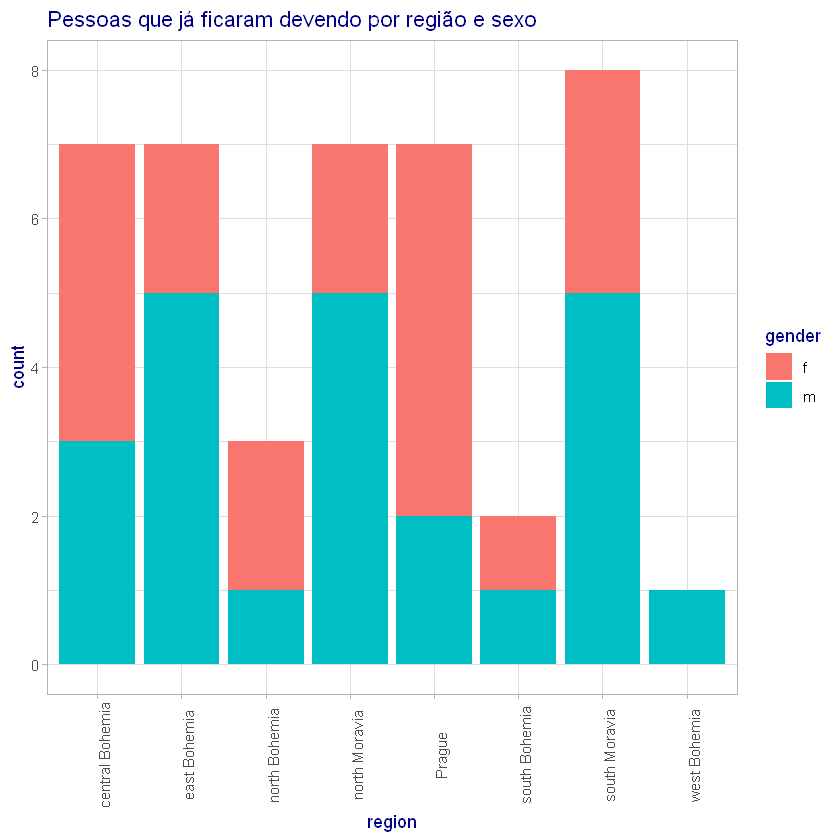

In [254]:
##Vamos avaliar as pessoas que ja ficaram devendo alguma vez para o banco e o tipo de cartão que elas têm.
#Tivemos 42 pessoas que ficaram negativas e possuem cartões de créditos
df_card_negatives = df_card_final %>% filter(n_negatives > 0)

ggplot(df_card_negatives,aes(x = region, fill = gender))+
  geom_bar()+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

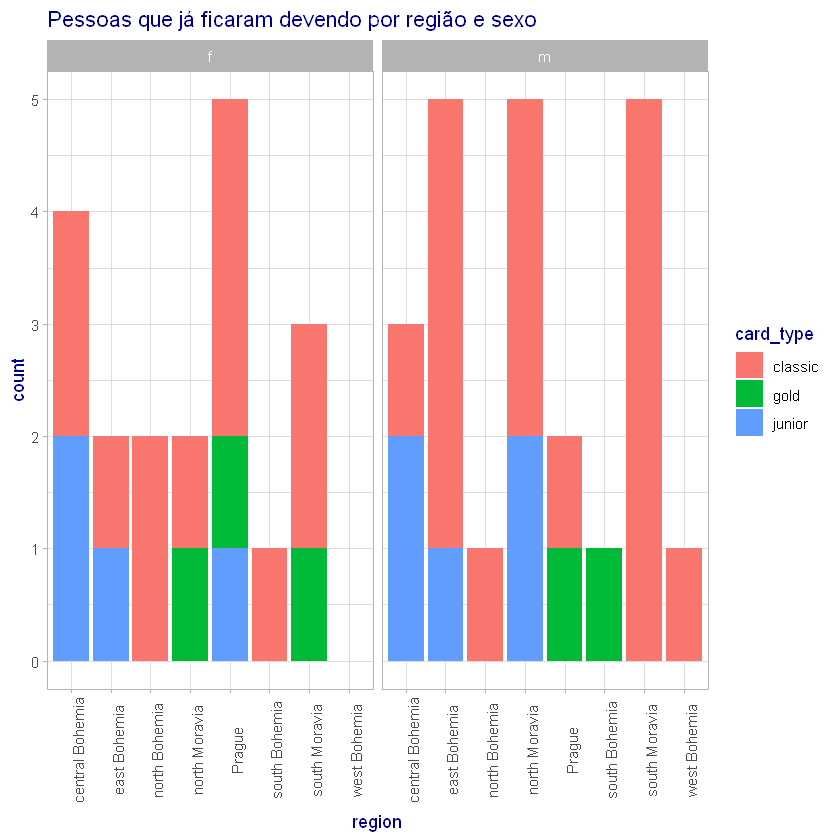

In [255]:
ggplot(df_card_negatives,aes(x = region, fill = card_type))+
  geom_bar()+
  facet_wrap(~ gender)+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

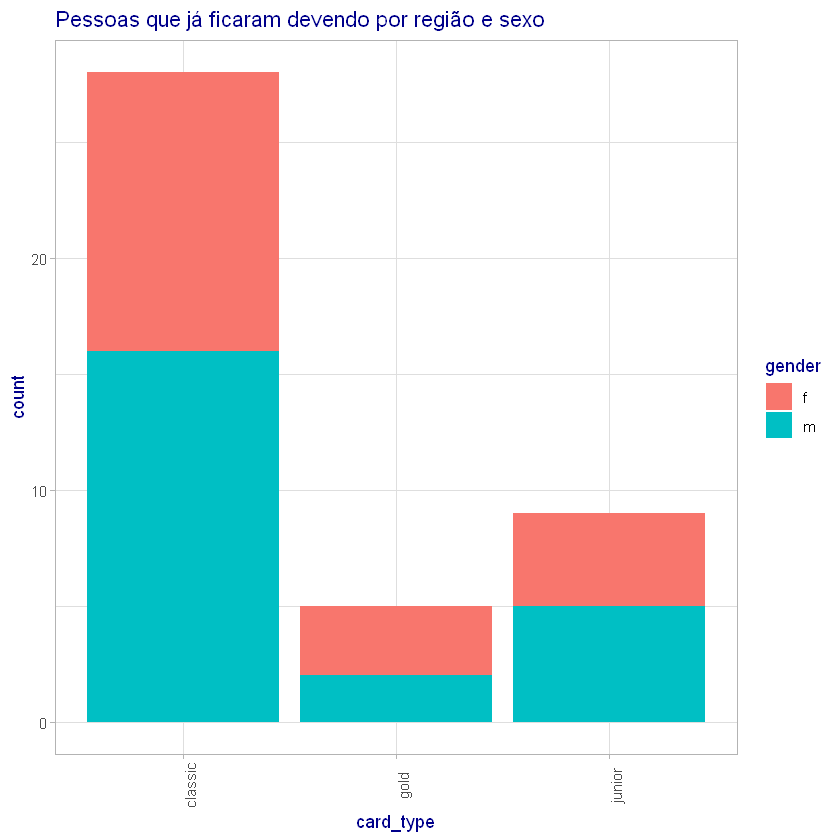

In [256]:
ggplot(df_card_negatives,aes(x = card_type, fill = gender))+
  geom_bar()+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

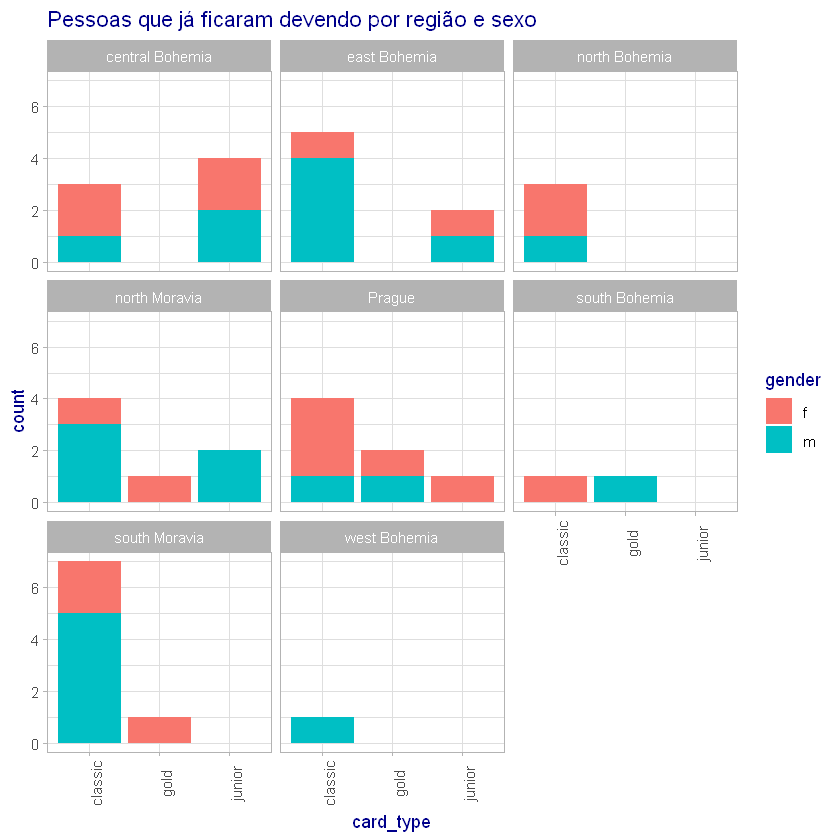

In [257]:
ggplot(df_card_negatives,aes(x = card_type, fill = gender))+
  geom_bar()+
  facet_wrap(~region)+
  ggtitle('Pessoas que já ficaram devendo por região e sexo')+
  my_theme

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


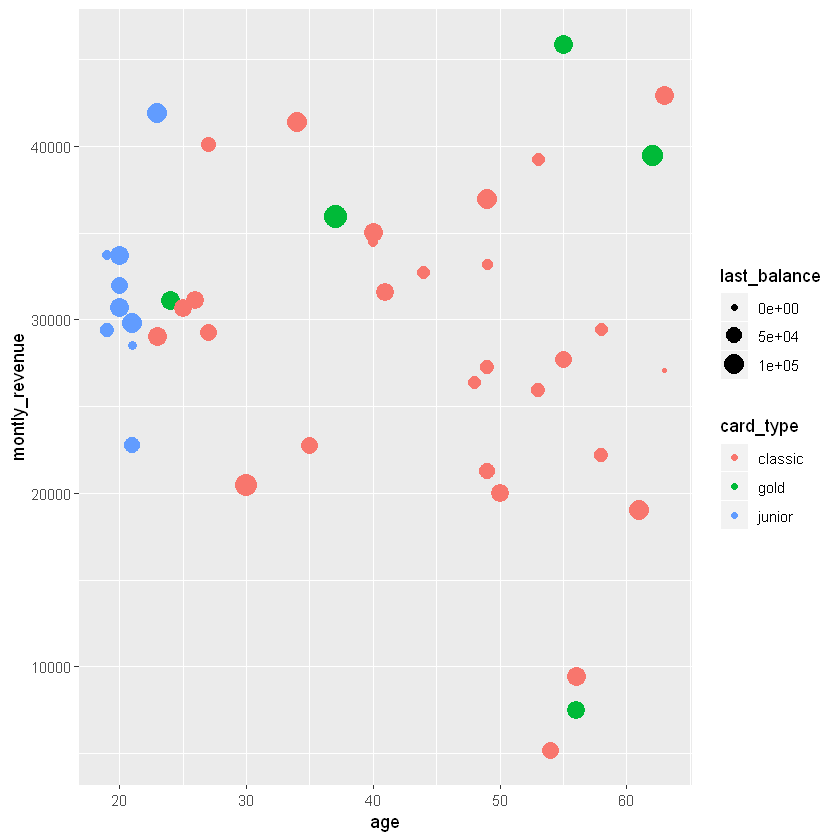

In [258]:
ggplot(df_card_negatives, aes(x = age, y = montly_revenue, color = card_type, size = last_balance))+
  geom_point()

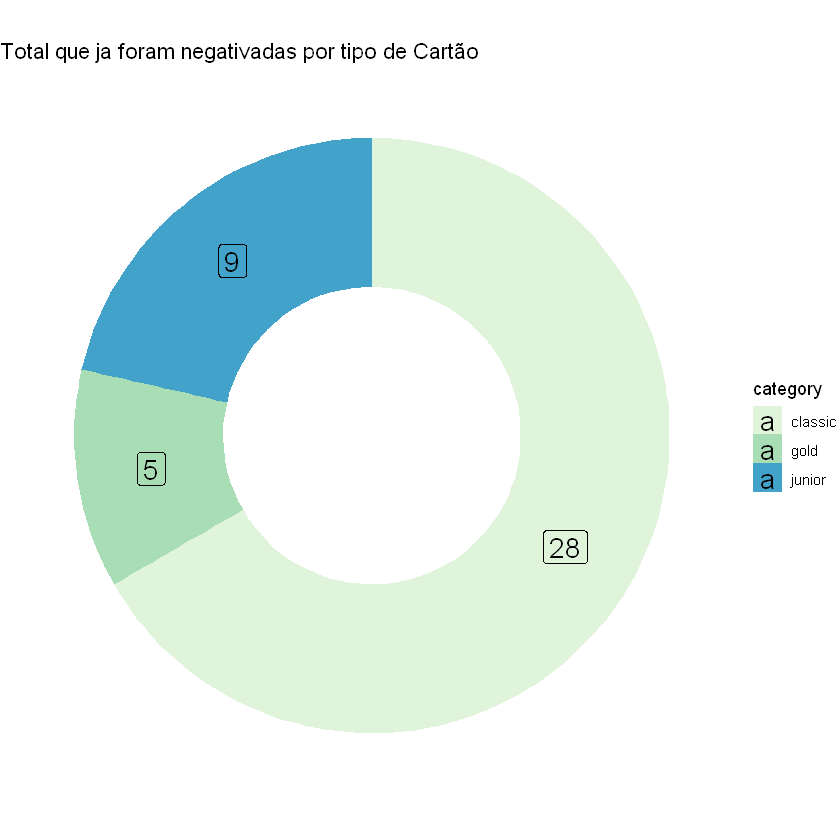

In [259]:
df_negatives_card_type = df_card_negatives %>% group_by(card_type) %>% summarise('total' = n())
category <- df_negatives_card_type$card_type
count <- df_negatives_card_type$total
data = data.frame(category, count)
donut(category, count,'Total que ja foram negativadas por tipo de Cartão')

## Vamos fazer uma avaliação da tabela Order

In [260]:
df_order = read.table('order.asc',header=T,sep=";")

Uma avaliação importante para fazer uma avaliação de concorrentes ja que consiste em um conjunto de avaliações referente a depósitos e pagamentos em outros bancos.

In [261]:
#Organizando o dataFrame
df_order <- df_order %>% left_join(df_account, by = 'account_id')
df <- df_order
df_order <- df_order %>% mutate('k_symbol' =  case_when(df_order$k_symbol == 'POJISTNE' ~ 'insurance payment',
                                                        df_order$k_symbol == 'SIPO' ~ 'household payment',
                                                        df_order$k_symbol == 'LEASING' ~ 'leasing',
                                                        df_order$k_symbol == 'UVER' ~ 'loan payment'))


In [262]:
#Primeiro vamos verificar os bancos que mais vezes recebem transferências
df_order_banks <- df_order %>% group_by(bank_to) %>% summarise('number_transatios' = n(), 'value_transation' = sum(amount))

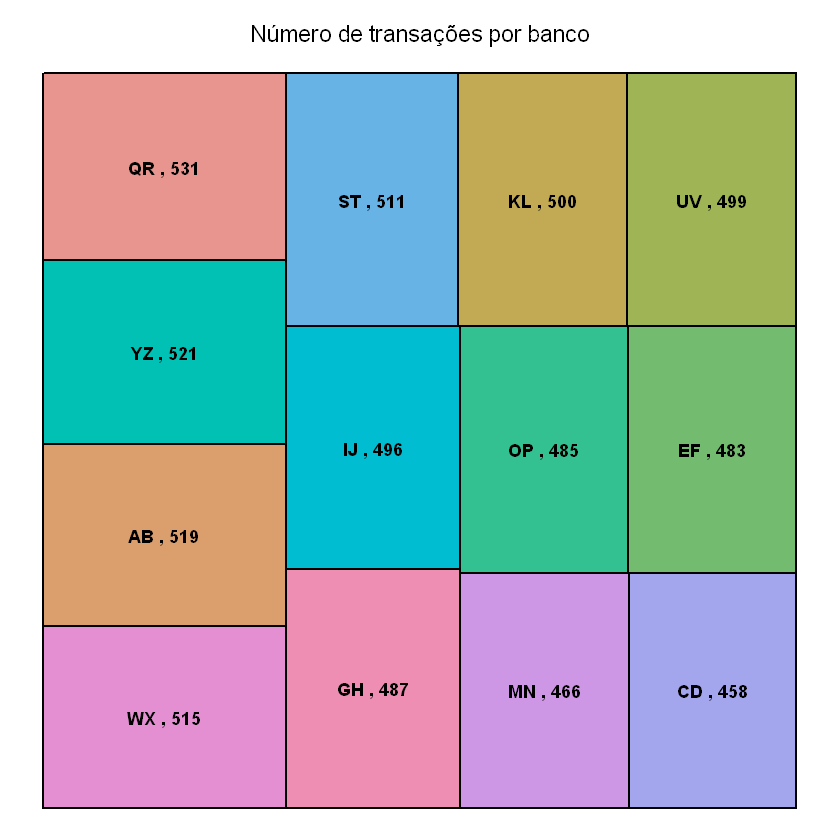

In [263]:
tree_chart(df_order_banks$bank_to, df_order_banks$number_transatios,'Número de transações por banco',type = 0)

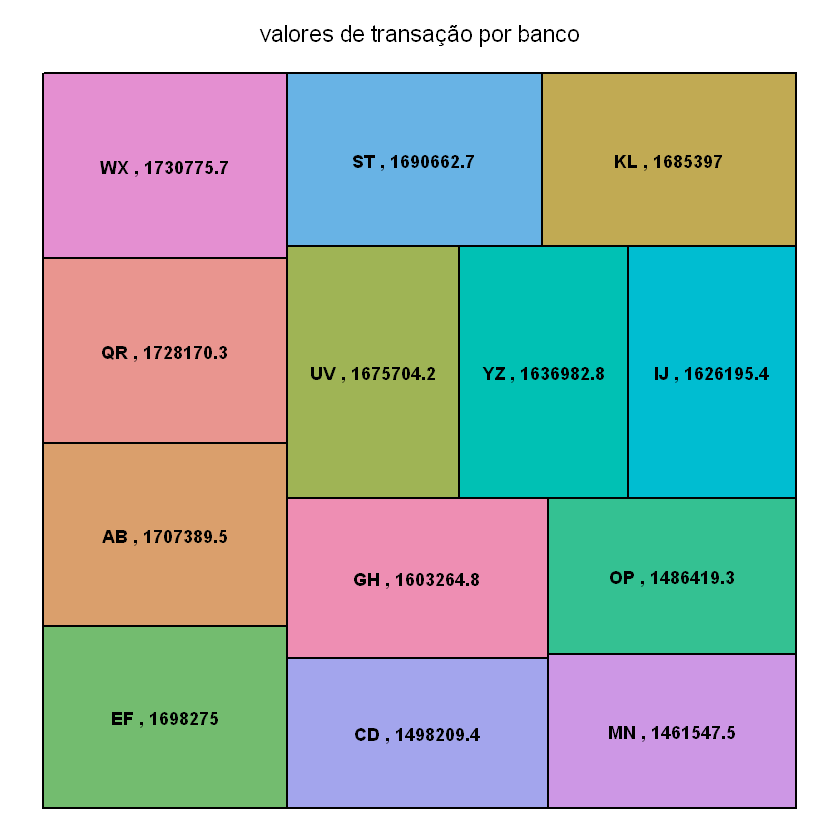

In [264]:
tree_chart(df_order_banks$bank_to, df_order_banks$value_transation,'valores de transação por banco',type = 0)

Com a avaliação dos gráficos acima podemos verificar que o banco EF apesar de não figurar entre o banco que possui os maiores números absolutos de transações aparece como um dos que possuem maior valor absoluto isso se deve possivelmente ao valor agregado dos títulos possuídos pelo banco.

Nos gráficos abaixo iremos detalhar um pouco mais as transações recebidas por cada unidade bancária.

In [265]:
#Vamos avaliar os tipos de transação
df_order_ksymbol <- df_order %>% group_by(bank_to, k_symbol) %>% summarise('n_vezes' = n(), 'ammount_total' = sum(amount))

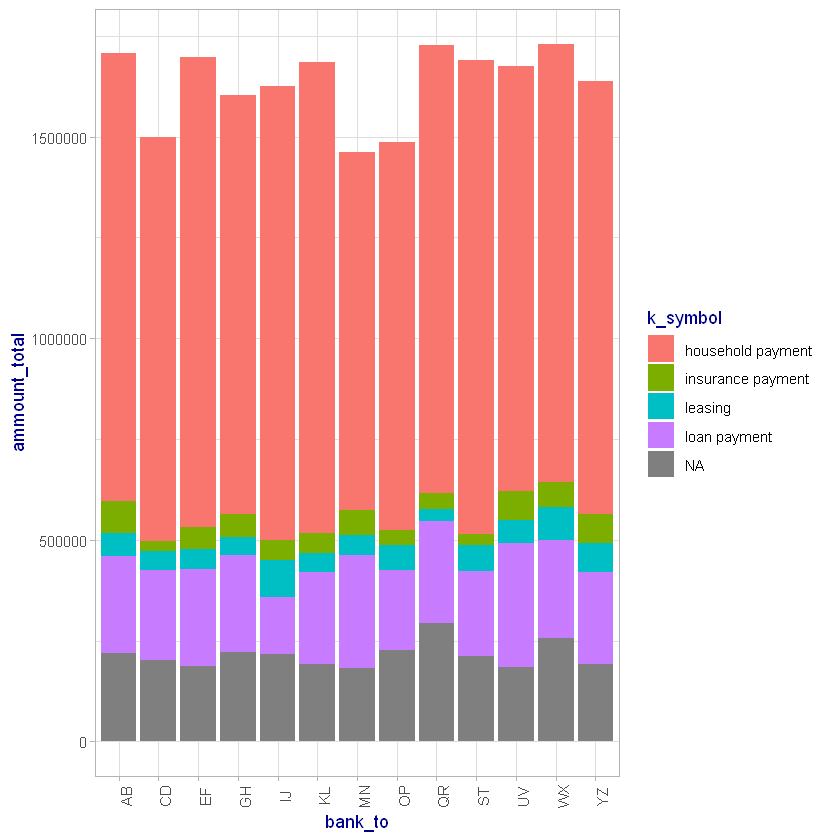

In [266]:
ggplot(df_order_ksymbol, aes(x = bank_to, y = ammount_total, fill = k_symbol))+
         geom_col()+
         my_theme

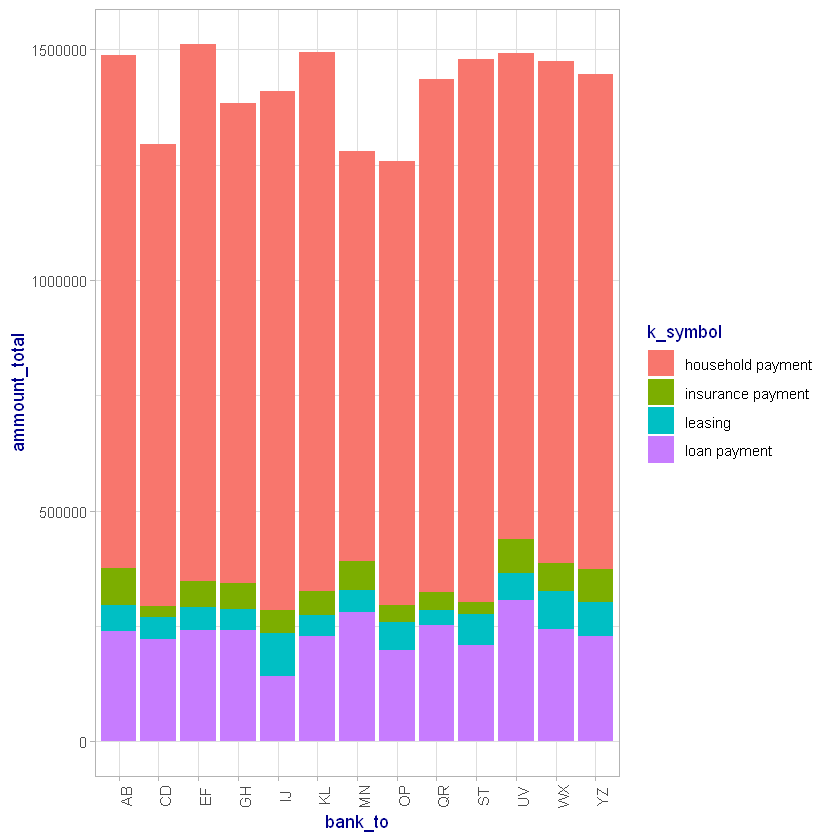

In [267]:
df_order_ksymbol %>% drop_na()%>% ggplot(aes(x = bank_to, y = ammount_total, fill = k_symbol))+
  geom_col()+
  my_theme

In [269]:
df_order_date_total <- df_order %>% group_by(date) %>% summarise('total_amount' = sum(amount)) %>%
  mutate('cumsum' = cumsum(total_amount))

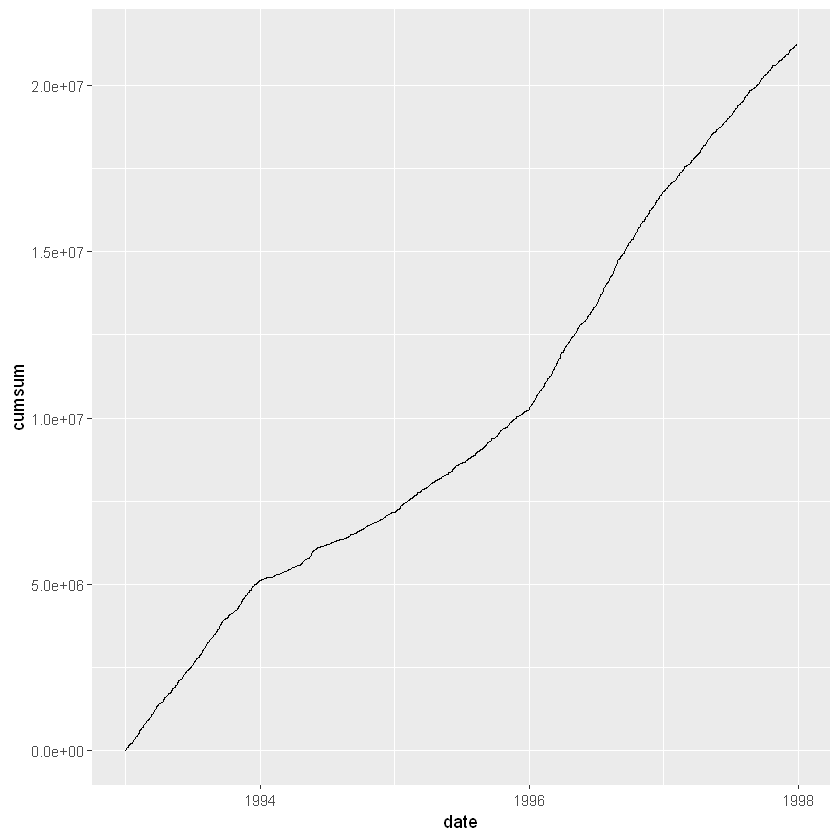

In [270]:
df_order_date_total %>% ggplot(aes(x = date, y = cumsum))+
  geom_line()

In [271]:
df_order <- df_order %>% mutate('year' = year(df_order$date))
df_order_date <- df_order %>% group_by(year,k_symbol,bank_to,date) %>% summarise('total_amount' = sum(amount))

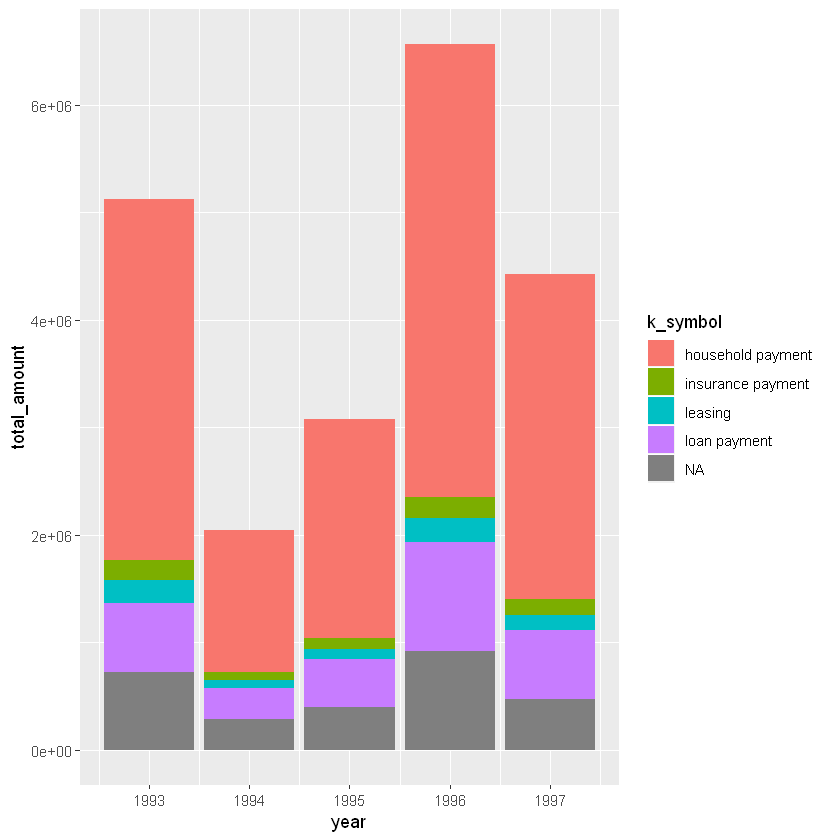

In [272]:
ggplot(df_order_date, aes(x = year, y = total_amount, fill = k_symbol))+
  geom_col()

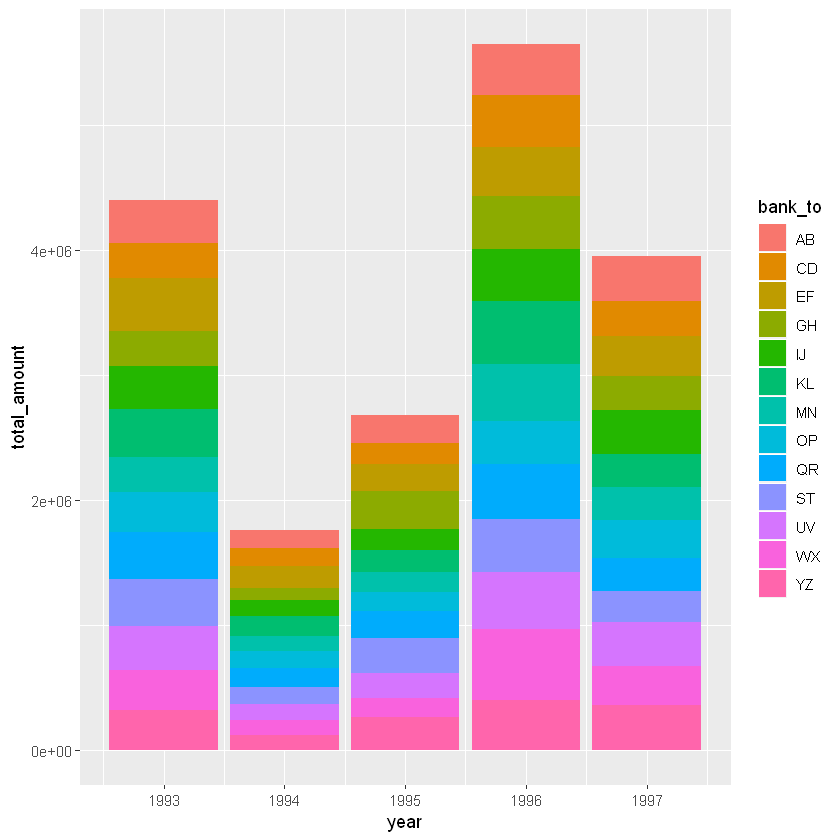

In [274]:
df_order_date %>% drop_na() %>% ggplot(aes(x = year, y = total_amount, fill = bank_to))+
  geom_col()

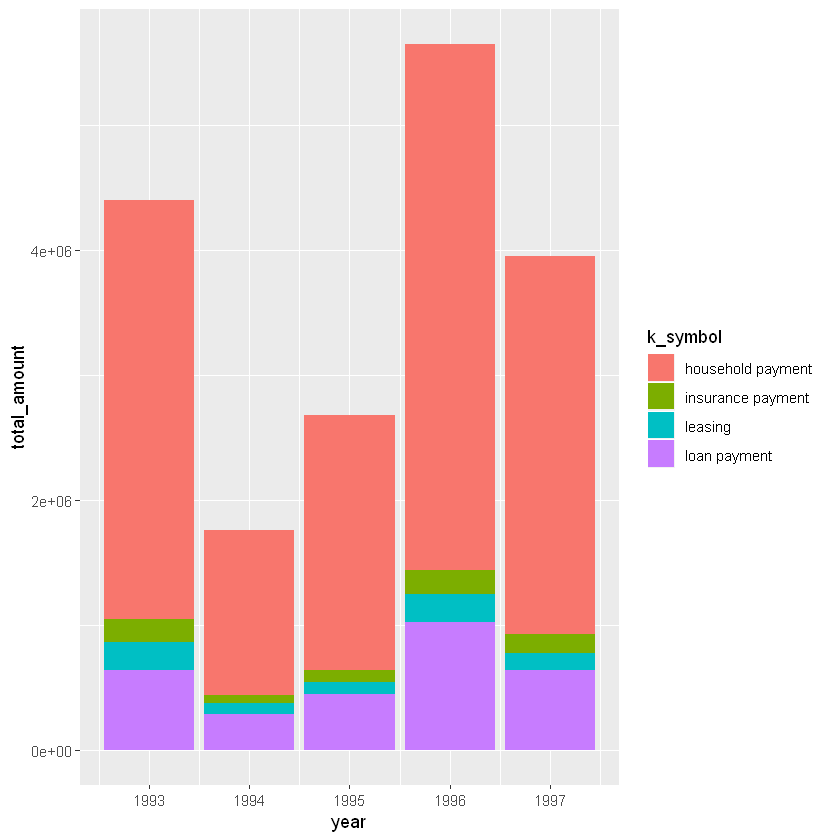

In [273]:
df_order_date %>% drop_na() %>% ggplot(aes(x = year, y = total_amount, fill = k_symbol))+
  geom_col()

É possível notar que a grande quantidade de valores transferidos para outros bancos foi para o pagamento de household. Seria importante para a unidade bancária aumentar a quantidade de títulos de household possuídos pelo próprio banco, assim garantiriamos uma maior quantidade de dinheiro circulando internamente.

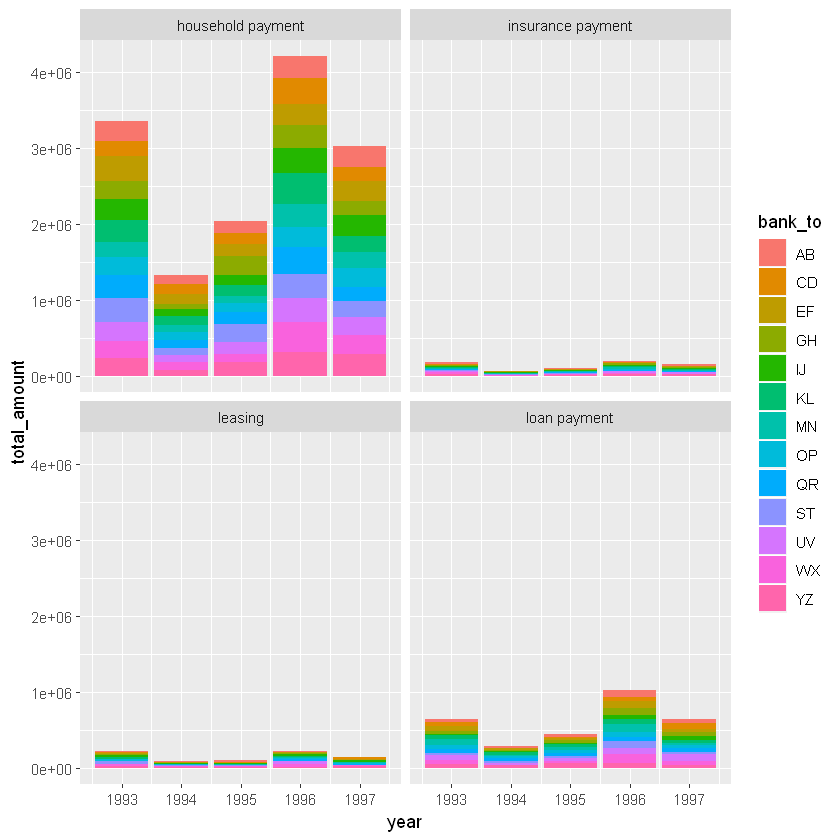

In [275]:
df_order_date %>% drop_na() %>% ggplot(aes(x = year, y = total_amount, fill = bank_to))+
  geom_col()+
  facet_wrap(~k_symbol)

## Avaliando a tabela Loan

In [278]:
df_loan = read.table('loan.asc',header=T,sep=";")

In [279]:
df_loan$date = as.Date(ymd(df_loan$date))
df_loan = left_join(df_loan, df_account, by = 'account_id')
df_loan = left_join(df_loan, df_disp, by = 'account_id')
df_loan = left_join(df_loan, df_client, by='client_id')
df_loan = left_join(df_loan, account_revenue, by = 'account_id')
df_loan = left_join(df_loan, last_status, by = 'account_id')


In [282]:
head(df_loan)

loan_id,account_id,date.x,amount,duration,payments,status,frequency,region.x,average_salary,...,montly_revenue,last_balance,total_retiradas,total_credit,first_trans,n_negatives,firstNegativeDate,LastNeagtiveDate,negative,client_age
5314,1787,1993-07-05,96396,12,8033,cancelled,weekly issuance,west Bohemia,9650,...,28574.96,5903.1,2051495,2057397.3,1993-03-22,8,1997-03-12,1997-09-03,FALSE,52 days
5316,1801,1993-07-11,165960,36,4610,paid,monthly issuance,east Bohemia,8369,...,33648.94,93628.6,2329095,2422723.7,1993-02-13,0,NA,NA,FALSE,31 days
6863,9188,1993-07-28,127080,60,2118,paid,monthly issuance,east Bohemia,8390,...,13864.02,34453.6,963753,998209.3,1993-02-08,0,NA,NA,FALSE,63 days
5325,1843,1993-08-03,105804,36,2939,paid,monthly issuance,central Bohemia,8754,...,19416.75,31576.9,1366431,1398006.1,1993-01-30,0,NA,NA,FALSE,60 days
7240,11013,1993-09-06,274740,60,4579,paid,weekly issuance,Prague,12541,...,44870.94,85131.6,3145576,3230707.8,1993-02-14,0,NA,NA,FALSE,21 days
6687,8261,1993-09-13,87840,24,3660,paid,monthly issuance,central Bohemia,8598,...,22951.96,63161.2,1589378,1652541.1,1993-05-12,0,NA,NA,FALSE,19 days


In [281]:
df_loan = df_loan %>% select(-date.y,-district_name.y,-region.y,-district_name.x,-date.y,-disp_id,-client_id,-type)
df_loan = df_loan %>% mutate('client_age' = round((today - birthdate)/360)) %>% select(-birthdate)

df_loan = df_loan %>% mutate('status' = case_when(df_loan$status == 'A'~'paid',
                                                  df_loan$status == 'B'~ 'cancelled',
                                                  df_loan$status == 'C'~ 'running OK',
                                                  df_loan$status == 'D'~ 'in debit'))


In [284]:
df_canceled = df_loan %>% filter(status == 'cancelled')
##Todos que tiveram o contrato cancelado tiveram a conta negativada ao menos uma vez.

In [285]:
df_canceled

loan_id,account_id,date.x,amount,duration,payments,status,frequency,region.x,average_salary,...,montly_revenue,last_balance,total_retiradas,total_credit,first_trans,n_negatives,firstNegativeDate,LastNeagtiveDate,negative,client_age
5314,1787,1993-07-05,96396,12,8033,cancelled,weekly issuance,west Bohemia,9650,...,28574.963,5903.1,2051494.6,2057397.3,1993-03-22,8,1997-03-12,1997-09-03,FALSE,52 days
6111,5428,1993-09-24,174744,24,7281,cancelled,monthly issuance,west Bohemia,8991,...,33030.369,94419.9,2283766.0,2378186.6,1993-04-14,1,1996-04-01,1996-04-01,FALSE,51 days
6228,6034,1993-12-01,464520,60,7742,cancelled,weekly issuance,central Bohemia,8546,...,31476.396,63892.0,2202406.9,2266300.5,1993-03-19,8,1998-07-21,1998-11-18,FALSE,59 days
7097,10266,1993-12-23,75624,24,3151,cancelled,monthly issuance,south Moravia,9897,...,30679.960,17123.9,2191832.1,2208957.1,1993-06-10,6,1994-02-12,1994-02-28,FALSE,41 days
6650,8073,1994-02-17,49320,12,4110,cancelled,issuance after transaction,west Bohemia,8991,...,36667.988,90064.4,2550030.4,2640095.1,1993-09-03,5,1994-04-14,1994-07-31,FALSE,54 days
7066,10131,1994-05-02,215388,36,5983,cancelled,monthly issuance,Prague,12541,...,20182.912,12250.0,1440877.8,1453169.7,1993-11-27,8,1995-01-24,1996-07-02,FALSE,40 days
6316,6473,1994-05-26,76908,12,6409,cancelled,monthly issuance,central Bohemia,8754,...,38230.031,29843.3,2722718.4,2752562.2,1993-01-26,4,1994-06-08,1996-09-16,FALSE,54 days
6210,5927,1994-06-06,87216,48,1817,cancelled,monthly issuance,south Bohemia,9045,...,13541.174,30124.0,944839.3,974964.5,1993-11-26,29,1995-01-06,1998-01-31,FALSE,35 days
6112,5442,1994-06-17,174744,24,7281,cancelled,monthly issuance,north Bohemia,9675,...,30709.144,83369.0,2127689.0,2211058.4,1993-03-22,39,1993-12-13,1997-07-31,FALSE,20 days
6232,6051,1994-07-08,276660,36,7685,cancelled,monthly issuance,south Moravia,8772,...,9897.197,10932.7,701665.5,712598.2,1993-08-28,7,1997-07-05,1998-01-04,FALSE,50 days


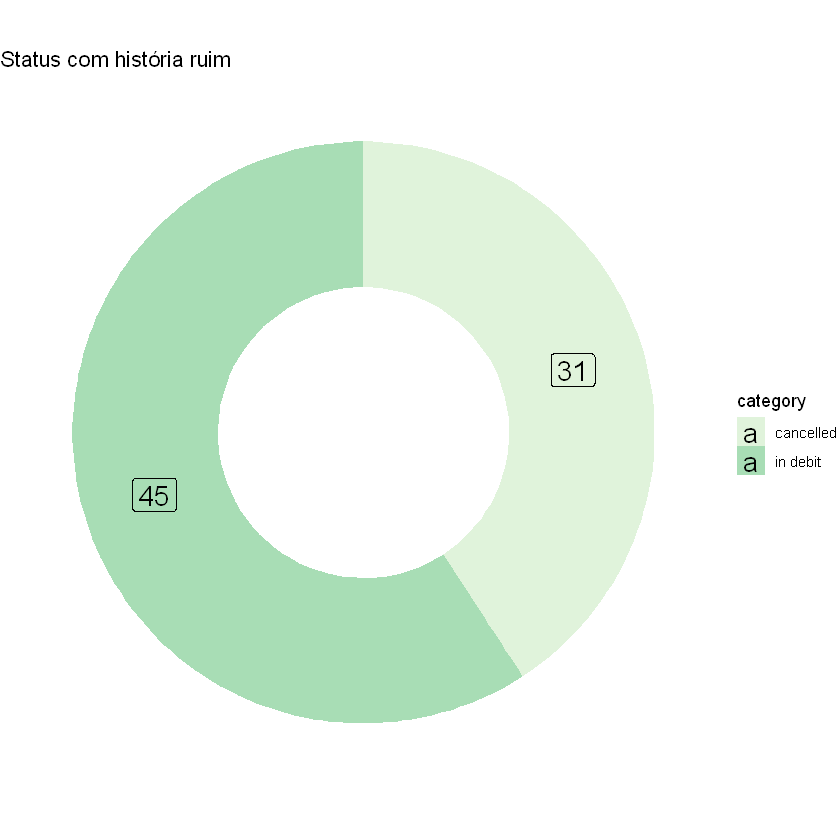

In [286]:
df_neg = df_loan %>% filter(n_negatives > 0)
df_neg_data = df_neg %>% group_by(status) %>% summarise('n_total' = n())
donut(df_neg_data$status,df_neg_data$n_total,'Status com história ruim')
## Nenhum dos clientes que esteve negativo ao menos uma vez está com contrato em dia, ou o contrato está atrasado ou cancelado.

Com o conjunto de dados atual é possível fazer uma avaliação importante. Nenhum dos clientes que ja ficou devendo ao menos uma vez está com o contrato em dia, esse pode ser o fator determinando para novos empréstimos. Mostrando uma tendência clara a inadimplência recorrente de alguns clientes do banco.

In [287]:
df_loan %>% filter(status == 'cancelled' | status == 'in debit') %>% view()


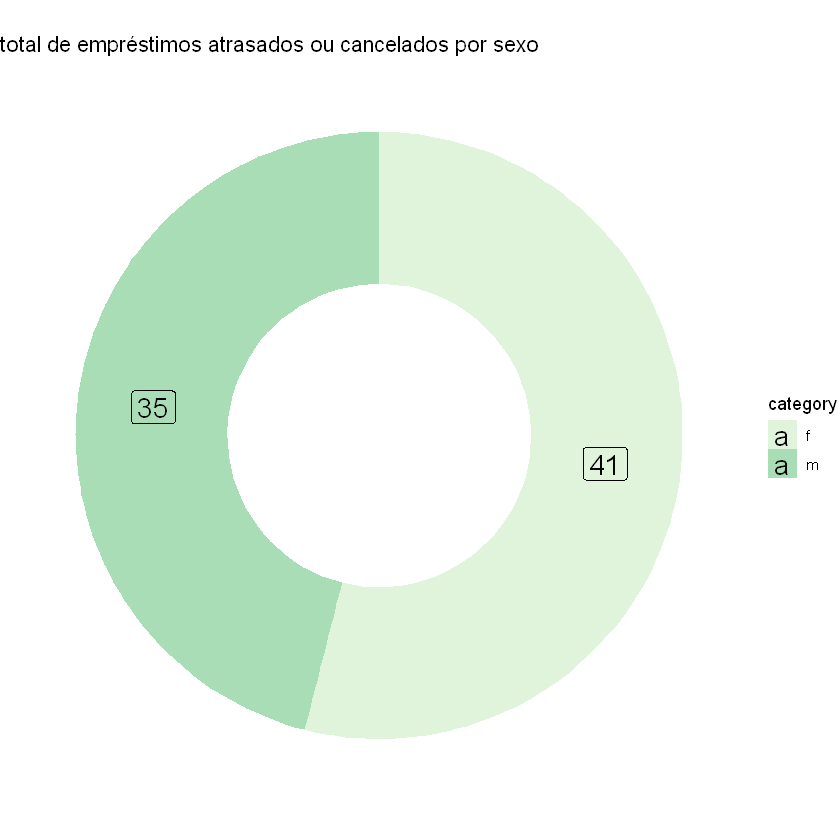

In [288]:
##Vamos entrar mais a fundo nos que tem histórico negativo
data = df_neg %>% group_by(gender) %>% summarise('total' = n())
donut(data$gender,data$total,'total de empréstimos atrasados ou cancelados por sexo')

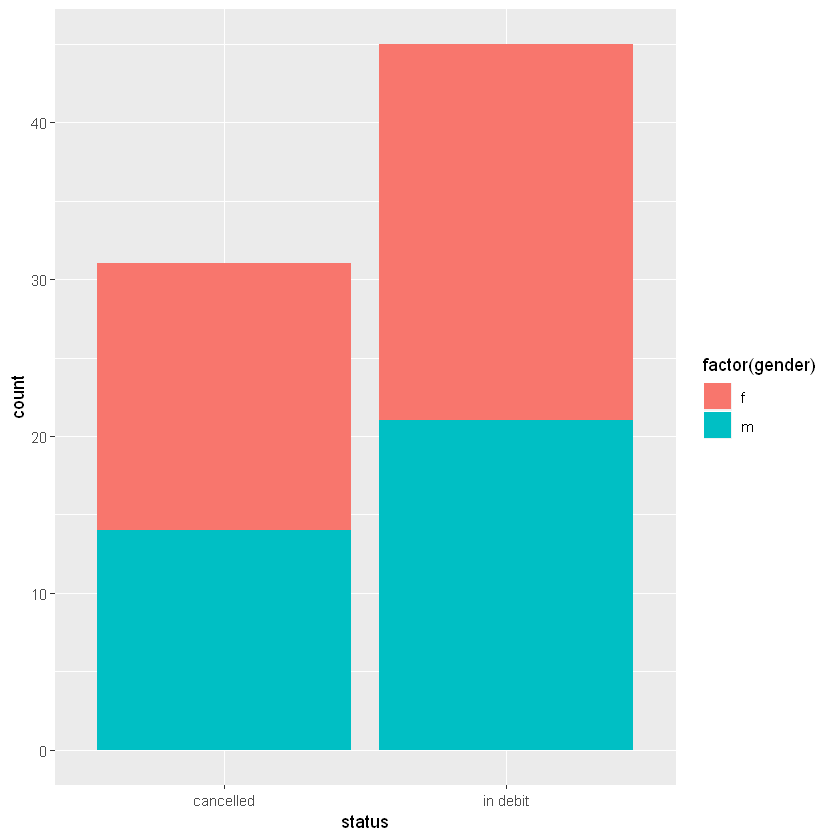

In [289]:
ggplot(df_neg,aes(x = status, fill = factor(gender)))+
  geom_bar()

Mais uma vez não é possível verificar relação entre o status da dívida e o sexo.

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


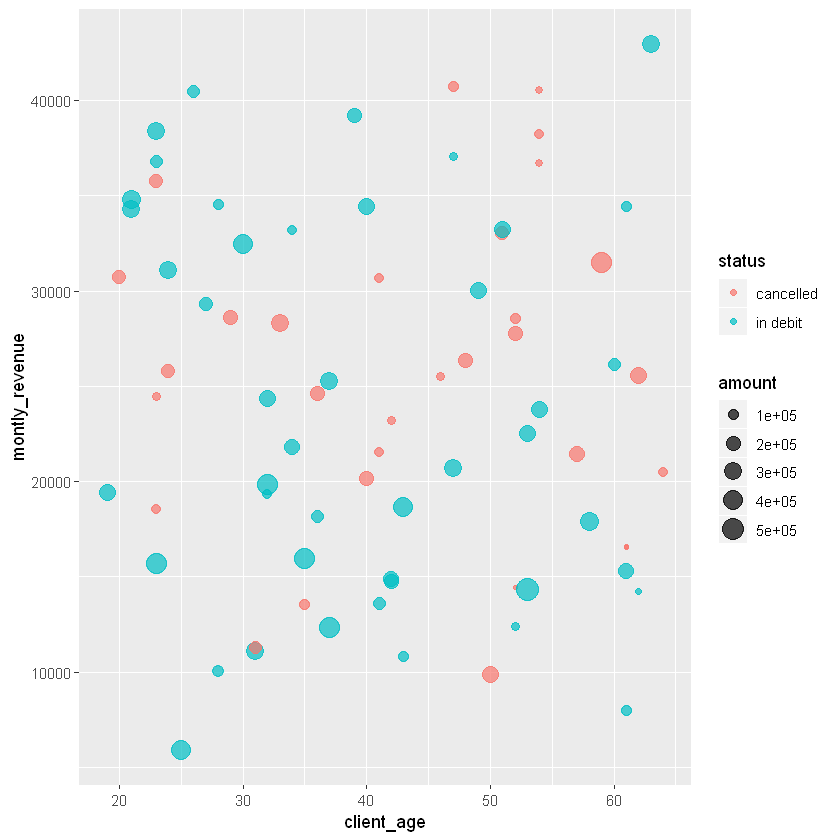

In [290]:
ggplot(df_neg,aes(x = client_age, y = montly_revenue, color = status, size = amount))+
  geom_point(alpha = 0.7)

Através desse gráfico, não é possível também verificar relação clara entre o tamanho da dívida, idade e o rendimento mensal dos clientes, o que se pode perceber é que quanto maior o valor da dívida maior a tendência de não pagamento. Verificaremos essa hipótese nas próximas análises.}

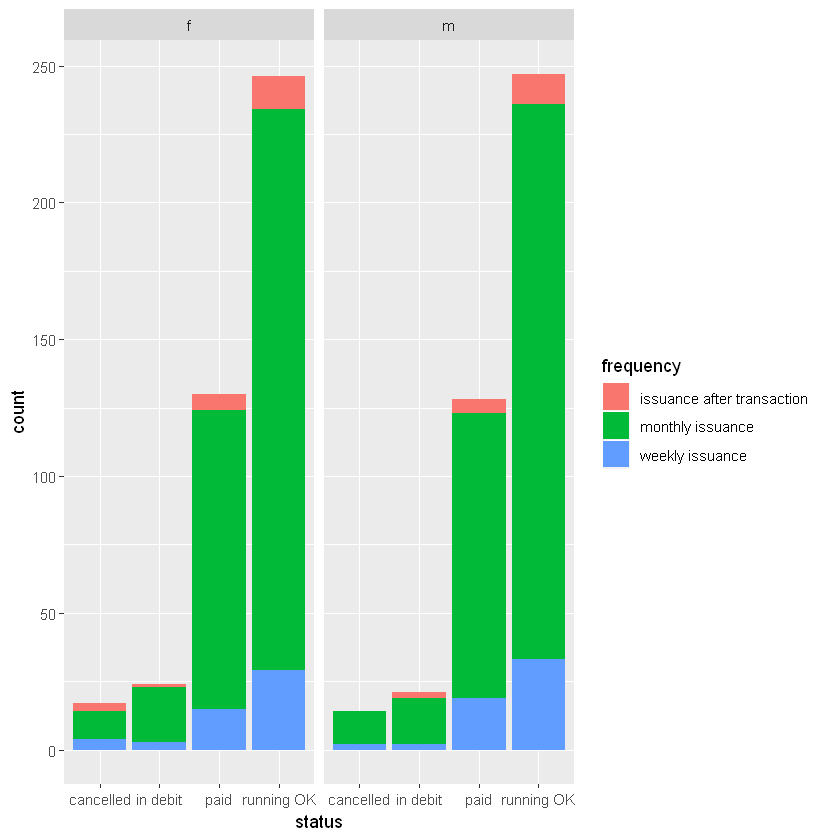

In [291]:
##-- Avaliando o cenário geral
ggplot(df_loan,aes(x = status, fill = frequency))+
  geom_bar()+
  facet_wrap(~gender)

Verificando a relação entre o status da dívida e a frequencia de retirada de extrato.

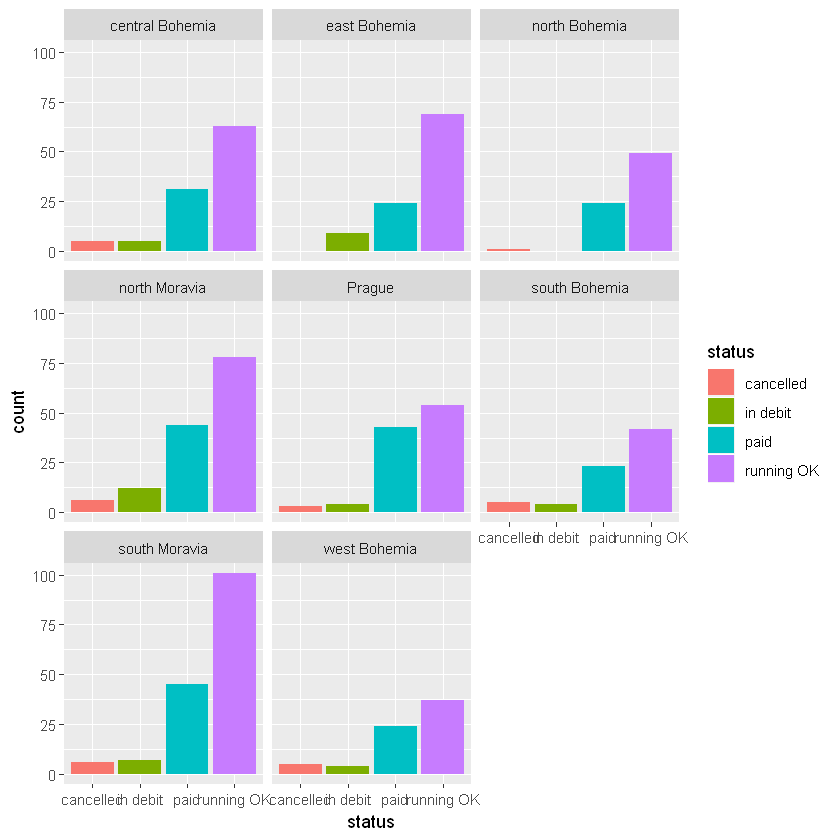

In [292]:
ggplot(df_loan,aes(x = status, fill = status))+
  geom_bar()+
  facet_wrap(~region.x)

Quando avaliamos o status da dívida por região podemos perceber que a região North Bohemia e East Bohemiam apresentam números de empréstimos cancelados e em atraso menores que as outras regiões, não podemos nos esquecer que essas regiões também apresentam um menor número de contas.

In [293]:
df_loan = df_loan %>% mutate('porc.parcela' = round(payments / montly_revenue,2))

Para aprofundarmos nossa análise criamos o parâmetro "porc.parcela" que representa a porcentagem da parcela na receita mensal de cada cliente

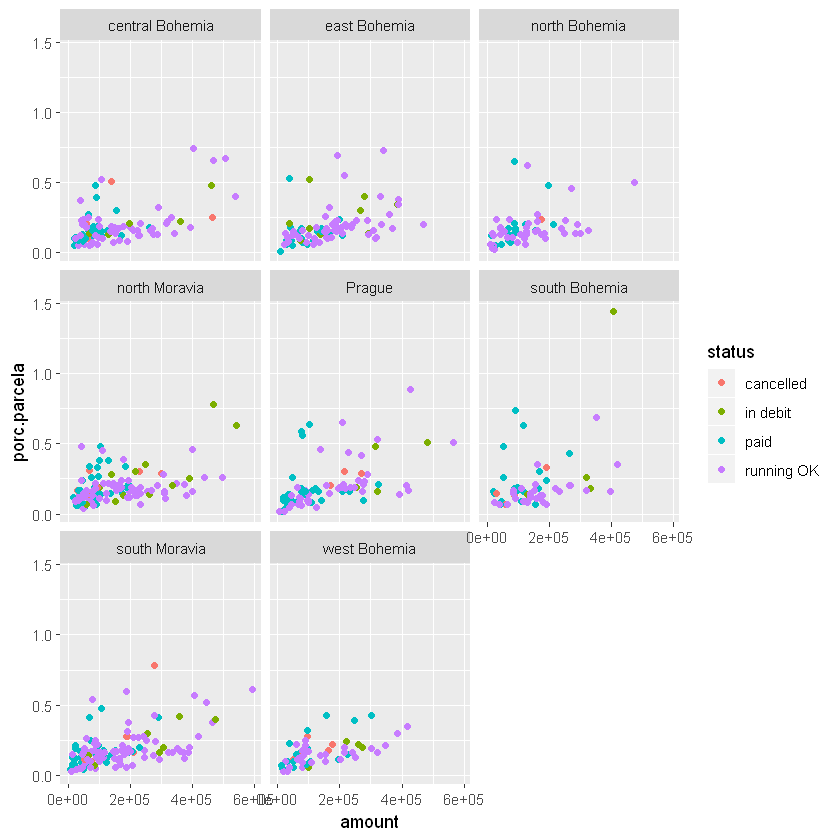

In [294]:
ggplot(df_loan, aes(x = amount, y = porc.parcela, color = status))+
  geom_point()+
  facet_wrap(~region.x)

Nesse gráfico é possível perceber a influência do tamanho da parcela no não pagamento de dívididas. Quanto maior a porcentagem de parcela maior a tendência para um não pagamento da dívida. Esse fator é relevante e faz sentido, haja vista que uma vez que o cliente tem uma porcentagem maior de renda comprometida aumentam os riscos de seus rendimentos não serem capazes de suprir emergências e até contas fixas.

In [295]:
average_salaries = df_loan %>% group_by(region.x) %>% summarise('average_salary' = mean(average_salary))

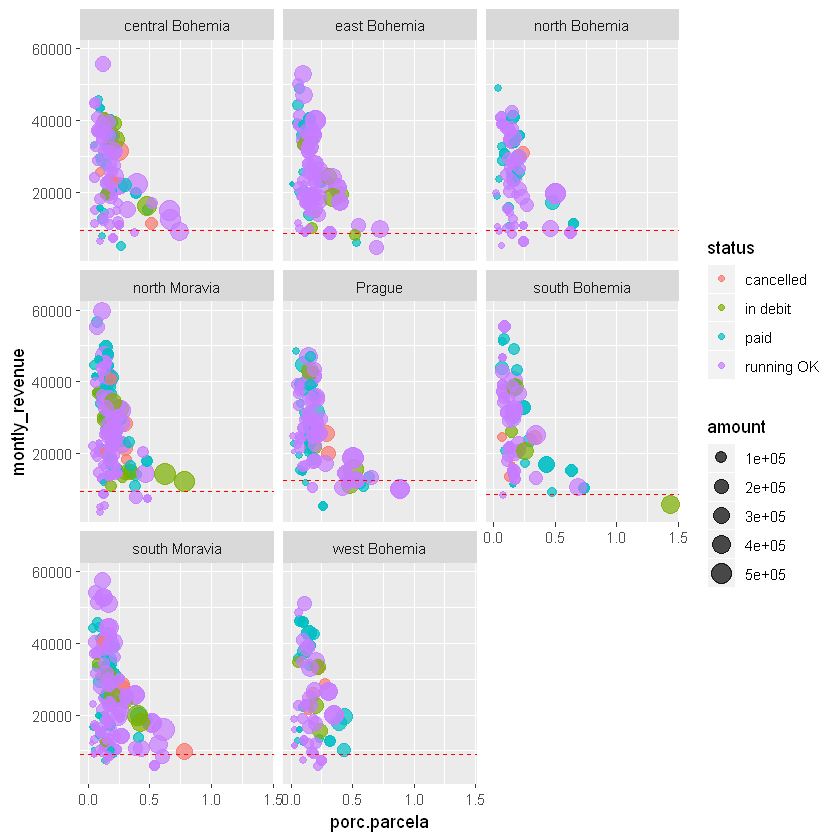

In [296]:
ggplot(df_loan, aes(x =porc.parcela , y = montly_revenue , color = status, size = amount))+
  geom_point(alpha = 0.7)+
  geom_hline(data = average_salaries, aes(yintercept = average_salary),color = 'red', linetype = 'dashed')+
  facet_wrap(~region.x)

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


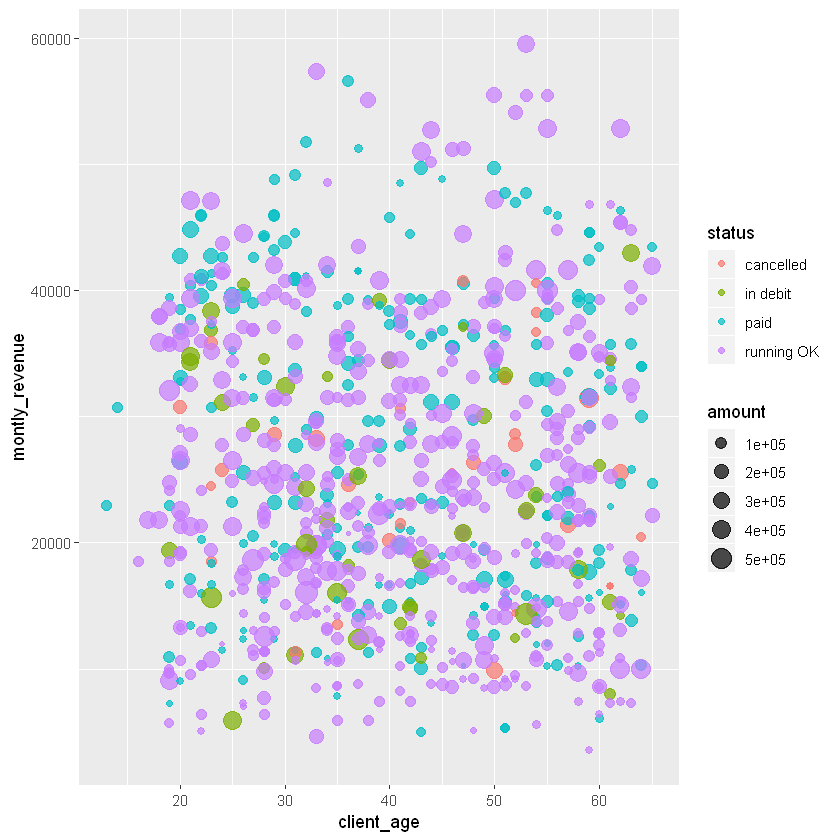

In [297]:
ggplot(df_loan,aes(x = client_age, y = montly_revenue, color = status, size = amount))+
  geom_point(alpha = 0.7)

In [298]:
df_loan = df_loan %>% mutate('porc.parcela' = round(payments/montly_revenue,2))

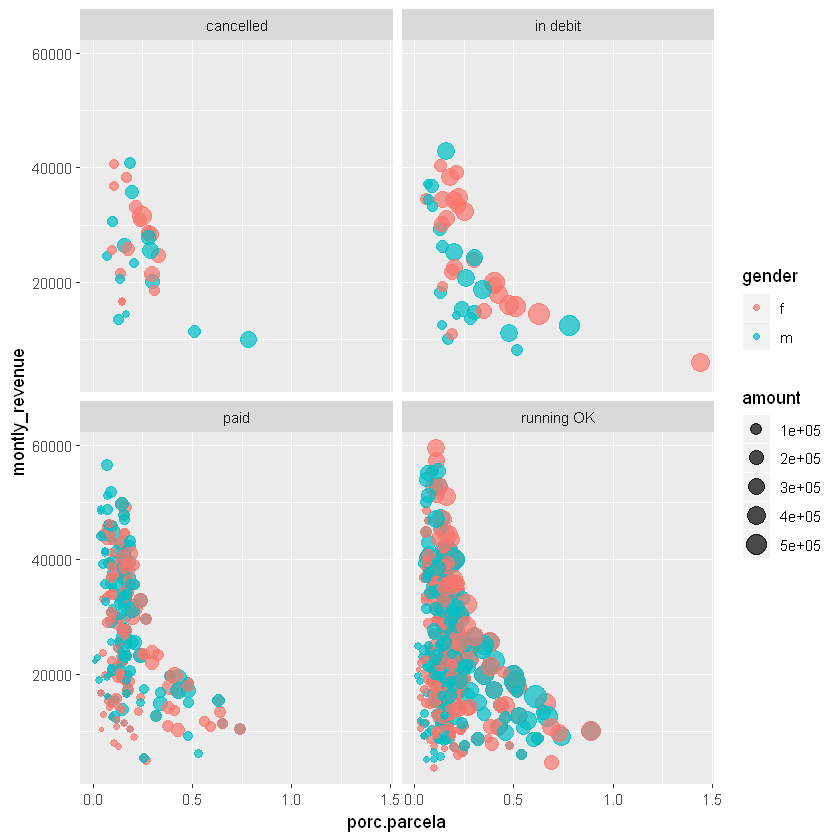

In [299]:
ggplot(df_loan, aes(x = porc.parcela, y=montly_revenue, size = amount, color = gender))+
  geom_point(alpha = 0.7)+
  facet_wrap(~status)

Don't know how to automatically pick scale for object of type difftime. Defaulting to continuous.


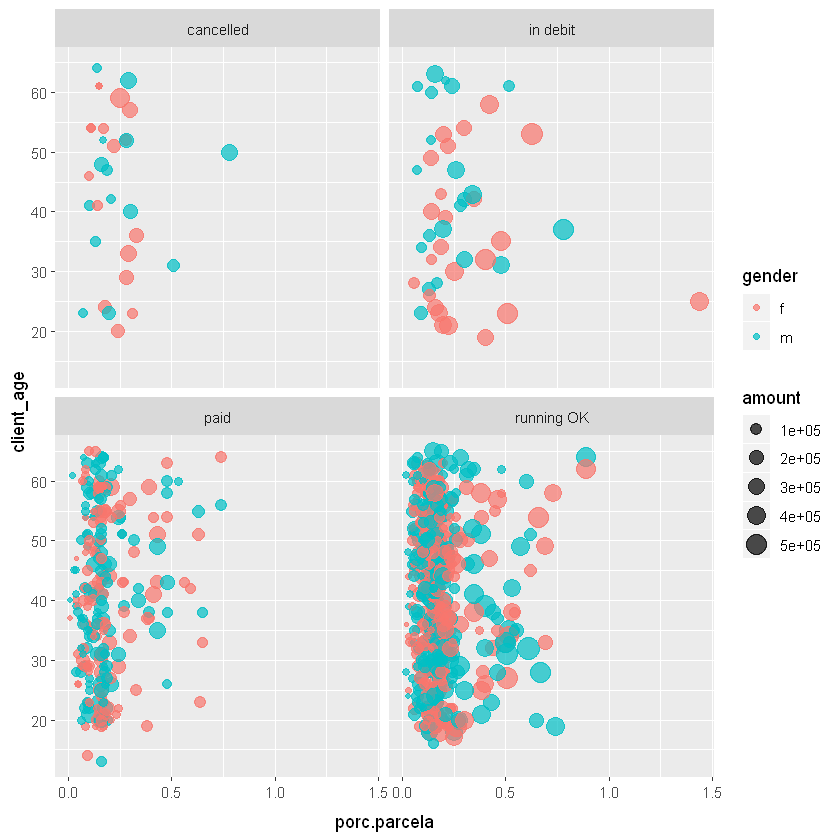

In [300]:
ggplot(df_loan, aes(x = porc.parcela, y=client_age, size = amount, color = gender))+
  geom_point(alpha = 0.7)+
  facet_wrap(~status)

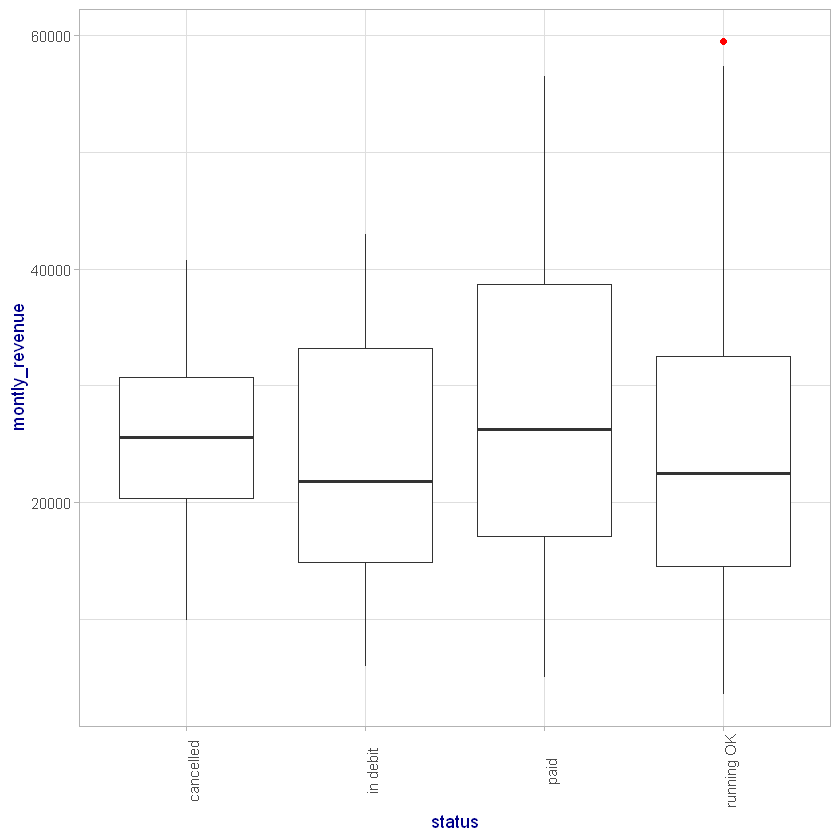

In [301]:
ggplot(df_loan, aes(x = status, y=montly_revenue))+
  geom_boxplot(outlier.color = 'red')+
  my_theme

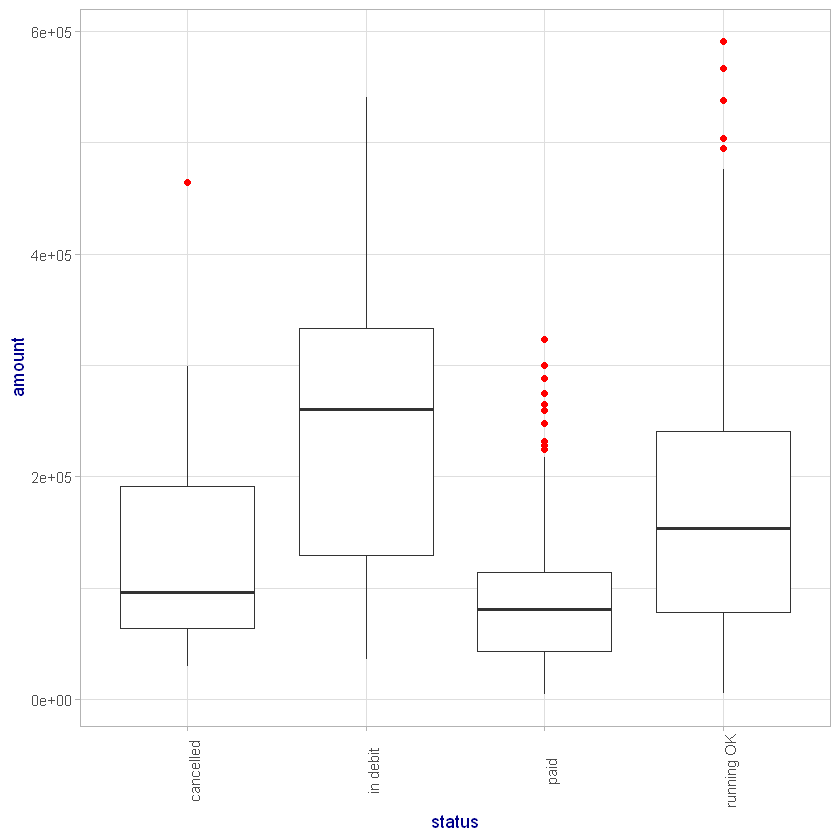

In [302]:
ggplot(df_loan, aes(x = status, y=amount))+
  geom_boxplot(outlier.color = 'red')+
  my_theme

Através do BoxPlot podemos perceber que os empréstimos com valores maiores em média ficam mais atrasados, então o valor do empréstimo também deve ser um fator relevante para decisão sobre o grau de risco de empréstimo.

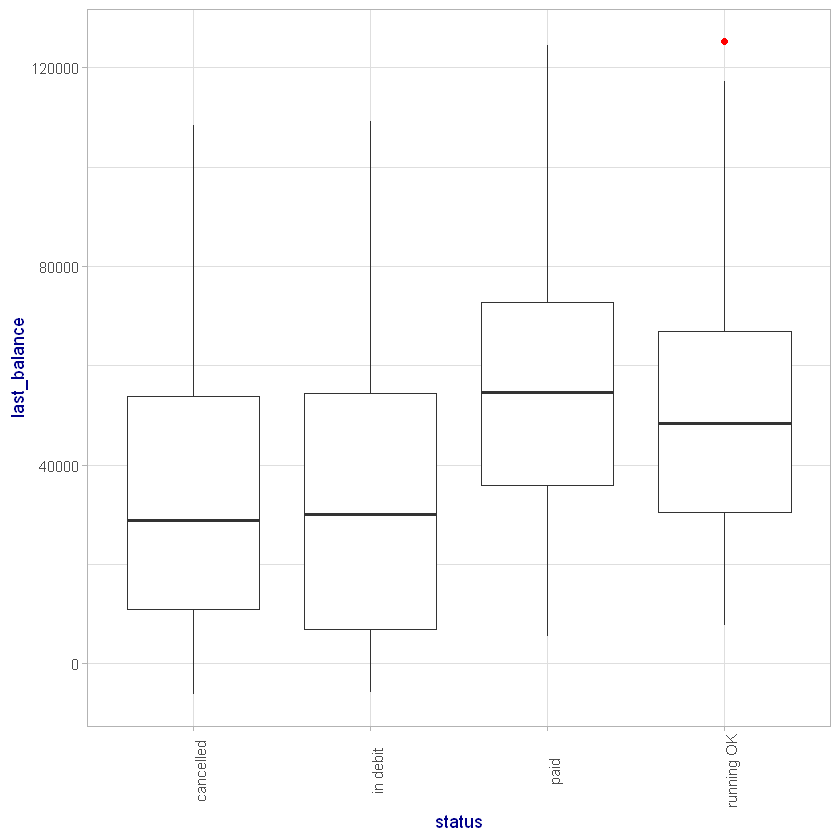

In [304]:
ggplot(df_loan, aes(x = status, y=last_balance))+
  geom_boxplot(outlier.color = 'red')+
  my_theme

## Agora vamos começar a fazer uma avaliação da dependencia das variáveis

In [305]:
###-----------Criando uma tabela padrao para avaliacao da dependecncia das variaveis.
st_loan <- df_loan


st_loan <- st_loan %>% mutate('Cod_in_debit' = (status == 'in debit')*1,
                              'Cod_running_OK' = (status == 'running OK')*1,
                              'Cod_paid' = (status == 'paid')*1) -> st_loan1

st_loan1 <- st_loan1 %>% mutate('status' = case_when(status == 'in debit' ~ 1,
                                                     status == 'running OK' ~ 2,
                                                     status == 'paid' ~ 3,
                                                     status == 'cancelled' ~ 0))

st_loan1 <- st_loan1 %>% mutate('gender' = case_when(gender == 'f' ~ 1,
                                                     gender == 'm' ~ 2))

st_loan1 <- st_loan1 %>% mutate('frequency' = case_when(frequency == 'weekly issuance' ~ 0,
                                                        frequency == 'monthly issuance' ~ 1,
                                                        frequency == 'issuance after transaction' ~ 2))

In [307]:
#Transformando as regiões em fatores de 1 à 8
#criando um vetor com as variáveis únicas de region.
reg = unique(st_loan1$region.x)
st_loan1$region.x <- factor(st_loan$region.x, levels = reg, labels = (1:length(reg))) 

In [308]:
#Criação dos modelos:
lm(data = st_loan1, formula = status ~ frequency ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ frequency, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2005 -0.1810 -0.1810  0.8190  0.8385 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.20055    0.05893  37.340   <2e-16 ***
frequency   -0.01954    0.05848  -0.334    0.738    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6958 on 825 degrees of freedom
Multiple R-squared:  0.0001354,	Adjusted R-squared:  -0.001077 
F-statistic: 0.1117 on 1 and 825 DF,  p-value: 0.7383


Como verificado o valor de pvalue é **alto 0.7383** o que demonstra que a variável **Frequency não apresenta** relação significante com o status de pagamento de empréstimo.

In [309]:
lm(data = st_loan1, formula = status ~ amount ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ amount, data = st_loan1)

Residuals:
     Min       1Q   Median       3Q      Max 
-2.39820 -0.30303 -0.07872  0.61429  1.11994 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.450e+00  3.845e-02  63.726   <2e-16 ***
amount      -1.762e-06  2.022e-07  -8.715   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6658 on 825 degrees of freedom
Multiple R-squared:  0.08431,	Adjusted R-squared:  0.0832 
F-statistic: 75.96 on 1 and 825 DF,  p-value: < 2.2e-16


Como verificado o valor de pvalue é **muito baixo 0.0000000** o que demonstra que a variável **Amount apresenta** relação significante com o status de pagamento de empréstimo.

In [311]:
lm(data = st_loan1, formula = status ~ duration ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ duration, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.5283 -0.1863 -0.0153  0.4717  1.1557 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.69935    0.05294   50.99   <2e-16 ***
duration    -0.01425    0.00132  -10.80   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6513 on 825 degrees of freedom
Multiple R-squared:  0.1239,	Adjusted R-squared:  0.1228 
F-statistic: 116.6 on 1 and 825 DF,  p-value: < 2.2e-16


Como verificado o valor de pvalue é **muito baixo 0.0000000** o que demonstra que a variável **Duration apresenta** relação significante com o status de pagamento de empréstimo.

In [313]:
lm(data = st_loan1, formula = status ~ average_salary ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ average_salary, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.3039 -0.1983 -0.1451  0.7706  0.8729 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    1.804e+00  1.736e-01  10.390   <2e-16 ***
average_salary 3.989e-05  1.810e-05   2.204   0.0278 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6938 on 825 degrees of freedom
Multiple R-squared:  0.005855,	Adjusted R-squared:  0.00465 
F-statistic: 4.859 on 1 and 825 DF,  p-value: 0.02778


Como verificado o valor de pvalue é **baixo 0.02** o que demonstra que a variável **Average Salary apresenta** relação significante com o status de pagamento de empréstimo.

In [314]:
lm(data = st_loan1, formula = status ~ montly_revenue ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ montly_revenue, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2815 -0.2223 -0.1281  0.7259  0.9477 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)    2.020e+00  5.741e-02  35.190  < 2e-16 ***
montly_revenue 6.410e-06  2.061e-06   3.111  0.00193 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6918 on 825 degrees of freedom
Multiple R-squared:  0.01159,	Adjusted R-squared:  0.01039 
F-statistic: 9.676 on 1 and 825 DF,  p-value: 0.001932


Como verificado o valor de pvalue é **muito baixo 0.001** o que demonstra que a variável **Montly Revenue apresenta** relação significante com o status de pagamento de empréstimo.

In [315]:
lm(data = st_loan1, formula = status ~ porc.parcela ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ porc.parcela, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.2514 -0.2234 -0.1842  0.7598  1.1242 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   2.29065    0.04066  56.342  < 2e-16 ***
porc.parcela -0.56056    0.17008  -3.296  0.00102 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6913 on 825 degrees of freedom
Multiple R-squared:  0.013,	Adjusted R-squared:  0.0118 
F-statistic: 10.86 on 1 and 825 DF,  p-value: 0.001023


Como verificado o valor de pvalue é muito baixo 0.001 o que demonstra que a variável porc. Parcela apresenta relação significante com o status de pagamento de empréstimo.

In [316]:
lm(data = st_loan1, formula = status ~ gender ) -> modelo
summary(modelo)


Call:
lm(formula = status ~ gender, data = st_loan1)

Residuals:
    Min      1Q  Median      3Q     Max 
-2.1927 -0.1927 -0.1727  0.8073  0.8273 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  2.15264    0.07631  28.208   <2e-16 ***
gender       0.02002    0.04839   0.414    0.679    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.6957 on 825 degrees of freedom
Multiple R-squared:  0.0002075,	Adjusted R-squared:  -0.001004 
F-statistic: 0.1712 on 1 and 825 DF,  p-value: 0.6792


Como verificado o valor de pvalue é muito alto 0.6792 o que demonstra que a variável sexo não apresenta relação significante com o status de pagamento de empréstimo.

In [318]:
##Criando uma matriz de correlação entre todas as variáveis para os pedidos de empréstimo
#install.packages('corrplot')

library(corrplot)
library(RColorBrewer)

st_loan2 <- st_loan1

st_loan2$date.x = (as.numeric(st_loan2$date.x))
st_loan2$firstNegativeDate = (as.numeric(st_loan2$firstNegativeDate))
st_loan2$LastNeagtiveDate = (as.numeric(st_loan2$LastNeagtiveDate))
st_loan2$negative = (as.numeric(st_loan2$negative))
st_loan2$account_age = (as.numeric(st_loan2$account_age))
st_loan2$client_age = (as.numeric(st_loan2$client_age))
st_loan2$first_trans = (as.numeric(st_loan2$first_trans))
st_loan2$region.x = (as.numeric(st_loan2$region.x))
st_loan2$firstNegativeDate = NULL
st_loan2$LastNeagtiveDate = NULL

In [321]:
summary(st_loan2)

    loan_id       account_id        date.x          amount      
 Min.   :4959   Min.   :    2   Min.   : 8586   Min.   :  4980  
 1st Qu.:5585   1st Qu.: 2988   1st Qu.: 9317   1st Qu.: 67536  
 Median :6190   Median : 5794   Median : 9891   Median :115992  
 Mean   :6181   Mean   : 5864   Mean   : 9764   Mean   :151802  
 3rd Qu.:6760   3rd Qu.: 8757   3rd Qu.:10206   3rd Qu.:210564  
 Max.   :7308   Max.   :11362   Max.   :10568   Max.   :590820  
                                                                
    duration        payments        status        frequency        region.x  
 Min.   :12.00   Min.   : 304   Min.   :0.000   Min.   :0.000   Min.   : NA  
 1st Qu.:24.00   1st Qu.:2496   1st Qu.:2.000   1st Qu.:1.000   1st Qu.: NA  
 Median :36.00   Median :3937   Median :2.000   Median :1.000   Median : NA  
 Mean   :36.26   Mean   :4231   Mean   :2.183   Mean   :0.919   Mean   :NaN  
 3rd Qu.:48.00   3rd Qu.:5916   3rd Qu.:3.000   3rd Qu.:1.000   3rd Qu.: NA  
 Max.   :60.

ERROR: Error in hclust(as.dist(1 - corr), method = hclust.method): NA/NaN/Inf em chamada de função externa (argumento 10)


In [327]:
st_loan2$region.x = NULL

In [328]:
M <-cor(st_loan2)

In [329]:
M

,loan_id,account_id,date.x,amount,duration,payments,status,frequency,average_salary,account_age,...,total_retiradas,total_credit,first_trans,n_negatives,negative,client_age,porc.parcela,Cod_in_debit,Cod_running_OK,Cod_paid
loan_id,1.00000000,0.99986132,-0.088619922,-0.028290221,0.028770295,-0.0552366148,0.10694372,-0.040570648,0.092216151,0.074315107,...,0.07514066,0.07521414,-0.0736084777,-0.072198834,-0.061833693,-0.127390689,-0.087615919,-0.05780773,-0.048574808,0.0972045933
account_id,0.99986132,1.00000000,-0.087345865,-0.028372231,0.028454082,-0.0550725251,0.10706540,-0.041985236,0.093046660,0.072997923,...,0.07433567,0.07441211,-0.0723031445,-0.072406370,-0.061352135,-0.127290352,-0.086852578,-0.05879794,-0.047710477,0.0968167702
date.x,-0.08861992,-0.08734587,1.000000000,0.077980328,0.071330327,0.0076103897,-0.25205406,0.011444605,-0.093992219,-0.933771863,...,-0.62548003,-0.62152041,0.9505130608,-0.057622572,0.003740289,0.054194353,0.107025440,0.03292641,0.559426643,-0.5263919419
amount,-0.02829022,-0.02837223,0.077980328,1.000000000,0.615839618,0.6830198080,-0.29035840,-0.060013810,0.002624963,-0.072943335,...,0.10719504,0.10648062,0.0646495684,0.129920943,0.091464011,-0.075643057,0.442386298,0.20421934,0.244615484,-0.3512254834
duration,0.02877029,0.02845408,0.071330327,0.615839618,1.000000000,-0.0424137360,-0.35193175,-0.056279796,-0.060507761,-0.078289667,...,-0.09973247,-0.09972087,0.0654080455,0.041850735,0.036994129,-0.058630098,0.007297832,0.13798636,0.513943327,-0.5613646462
payments,-0.05523661,-0.05507253,0.007610390,0.683019808,-0.042413736,1.0000000000,-0.06904033,-0.016813778,0.025837207,0.001578657,...,0.24786404,0.24695467,0.0006732053,0.111173528,0.076299933,-0.019554313,0.601316670,0.11315472,-0.126169387,0.0360943770
status,0.10694372,0.10706540,-0.252054060,-0.290358402,-0.351931752,-0.0690403273,1.00000000,-0.011634346,0.076520165,0.269781465,...,0.21434347,0.21916633,-0.2605515035,-0.393416574,-0.236016394,-0.012174403,-0.113997212,-0.40819628,-0.319193824,0.7920046324
frequency,-0.04057065,-0.04198524,0.011444605,-0.060013810,-0.056279796,-0.0168137777,-0.01163435,1.000000000,-0.024750025,-0.032237925,...,-0.10075153,-0.10140442,0.0276073328,0.001865508,0.021663190,0.016902088,0.066301889,0.02120348,0.005603270,-0.0132340306
average_salary,0.09221615,0.09304666,-0.093992219,0.002624963,-0.060507761,0.0258372068,0.07652016,-0.024750025,1.000000000,0.071778298,...,0.03815600,0.03621444,-0.0766574934,0.013112049,-0.013875289,-0.052133453,0.022306953,-0.02988548,-0.069081643,0.0919143207
account_age,0.07431511,0.07299792,-0.933771863,-0.072943335,-0.078289667,0.0015786569,0.26978146,-0.032237925,0.071778298,1.000000000,...,0.65594544,0.65234939,-0.9802899420,0.068102224,0.005443334,-0.062129562,-0.111985181,-0.04018314,-0.522803052,0.5105819398


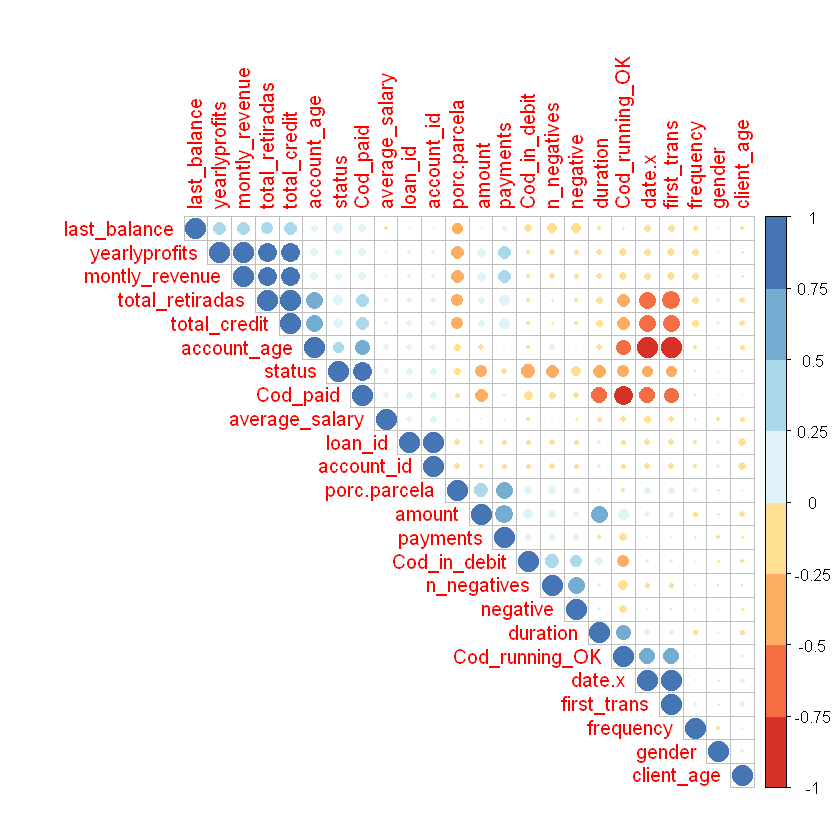

In [330]:
corrplot(M, type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

Utilizando uma matriz de correlação para avaliar a coluna status temos o seguinte resultado como as variáveis que mais tem influência.


- n_negatives
- valor do empréstimo
- is negative 
- duration
- account date
- porc. parcela

In [332]:
##-------- Tabela final
df_client
df_client = df_client %>% mutate('age' = round((today - birthdate)/360,0))

df_client$age = as.numeric(df_client$age)
df_client$birthdate = NULL
df_client$district_name = NULL

df <- df_client
df <- left_join(df, df_disp, by = 'client_id')
df <- left_join(df, df_account, by = 'account_id')

df$region.y = NULL
df$district_name = NULL

df2 <- select(df_card_final, client_id, account_id, card_type)
df <- left_join(df,df2, by = c('account_id' = 'account_id', 'client_id' = 'client_id'))
df2 <- select(df_card_final, client_id, account_id, card_type)

df2 <- select(df_loan, loan_id, account_id, duration, payments, status, porc.parcela, date.x)
df2 <- df2 %>% rename('loan_date' = date.x)

df2 <- df2 %>% mutate('status' = case_when(status == 'running OK' ~ 2,
                                           status == 'paid' ~ 1,
                                           status == 'in debit' ~ 3,
                                           status == 'cancelled' ~ 4))

df4 <- df2 %>% group_by(account_id) %>% summarise('duration' = mean(duration),
                                          'payments' = mean(payments),
                                          'status' = max(status),
                                          'porc.parcela' = mean(porc.parcela),
                                          'last_date' = max(loan_date))


df3 <- left_join(df, df4, by = 'account_id')
df3 <- left_join(df3, account_revenue, by = 'account_id')
df5 <- left_join(df3, last_status, by = 'account_id')

client_id,gender,birthdate,district_name,region
1,f,1970-12-13,Pisek,south Bohemia
2,m,1945-02-04,Hl.m. Praha,Prague
3,f,1940-10-09,Hl.m. Praha,Prague
4,m,1956-12-01,Kolin,central Bohemia
5,f,1960-07-03,Kolin,central Bohemia
6,m,1919-09-22,Pribram,central Bohemia
7,m,1929-01-25,Cesky Krumlov,south Bohemia
8,f,1938-02-21,Trutnov,east Bohemia
9,m,1935-10-16,Prostejov,south Moravia
10,m,1943-05-01,Hodonin,south Moravia


[1] 151801.5

[1] 115992

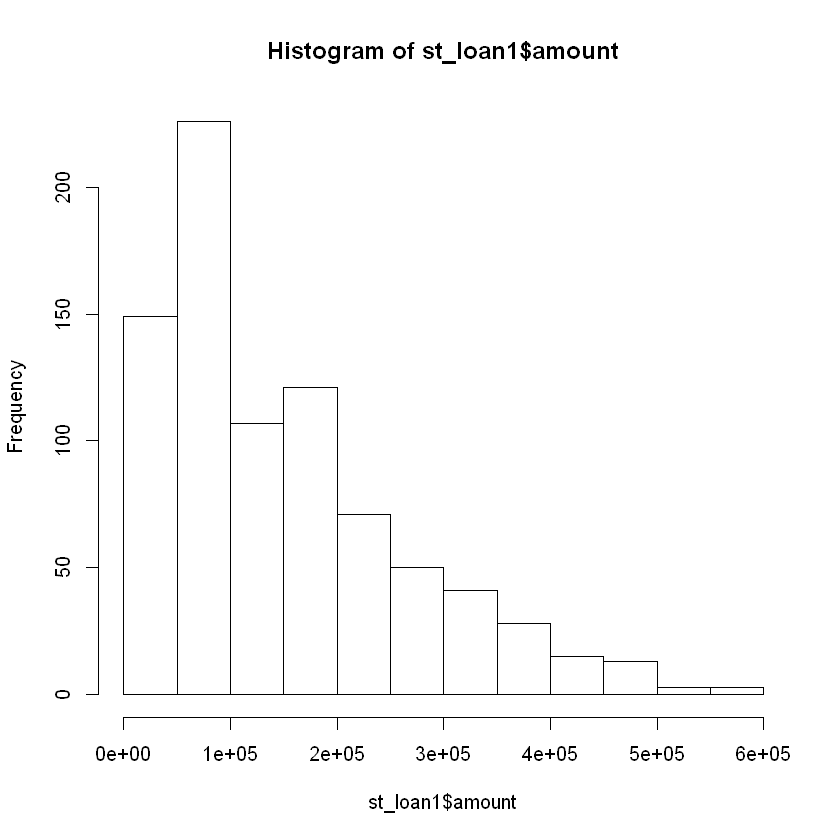

In [341]:
#Análise da relação entre amount e status do empréstimo
mean(st_loan1$amount)
median(st_loan1$amount)
hist(st_loan1$amount)


Call:
lm(formula = st_loan1$amount ~ st_loan1$status)

Residuals:
    Min      1Q  Median      3Q     Max 
-226771  -79391  -24169   54281  430283 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)    
(Intercept)       256219      12574  20.378   <2e-16 ***
st_loan1$status   -47841       5489  -8.715   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 109700 on 825 degrees of freedom
Multiple R-squared:  0.08431,	Adjusted R-squared:  0.0832 
F-statistic: 75.96 on 1 and 825 DF,  p-value: < 2.2e-16


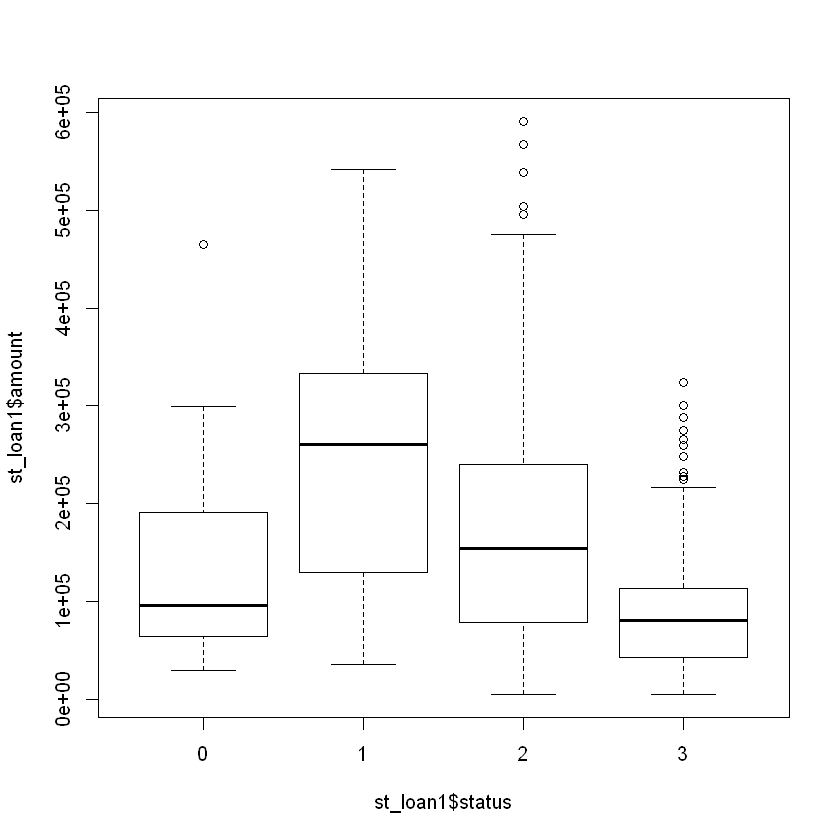

In [342]:
boxplot(st_loan1$amount ~ st_loan1$status)
lm(formula = st_loan1$amount ~ st_loan1$status)-> modelo2
summary(modelo2)

#'in debit' ~ 1,'running OK' ~ 2, 'paid' ~ 3, 'cancelled' ~ 0))
#mean 151.801,507mediana 115992 #p-value 2.2e-16

In [336]:
#mean 0.1927811,507mediana 0.16 #p-value 0,001


#verificar a quantidade de contas diferentes de que possuem algum emprestimo.
length(unique(st_loan1$account_id))

#quantidade de clientes com emprÃ©stimo OK
df_loan_sum_status <- st_loan1%>% 
  group_by(status) %>% 
  summarise(count = n_distinct(account_id))
df_loan_sum_status

[1] 682

status,count
0,31
1,45
2,403
3,203


[1] 0.1927811

[1] 0.16

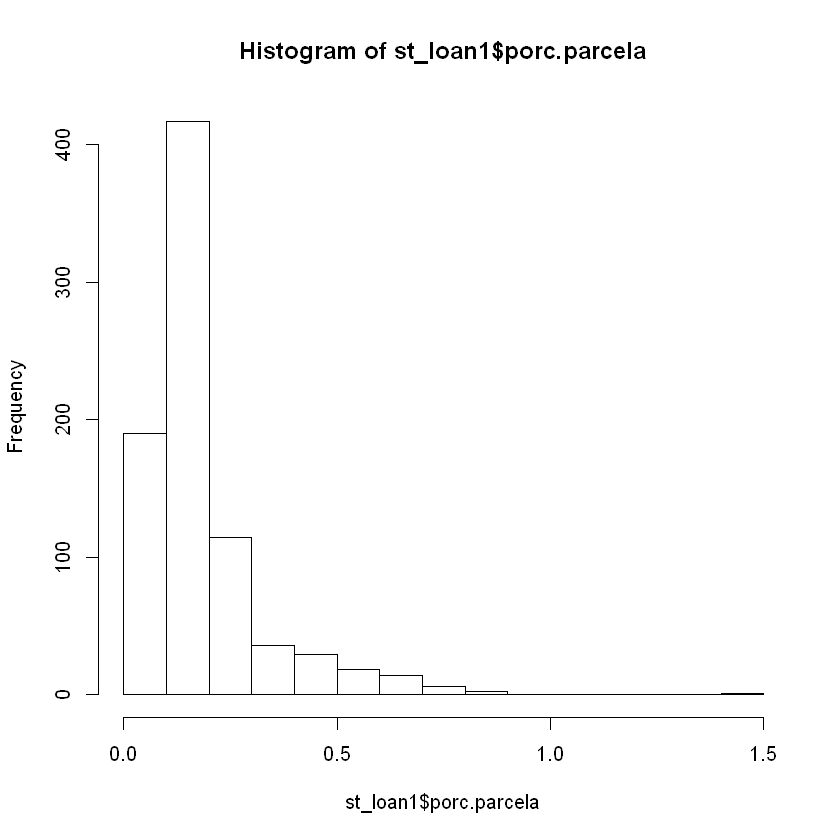

In [339]:

#Análise da relação entre porc. Parcela e o status do Empréstimo
mean(st_loan1$porc.parcela) 
median(st_loan1$porc.parcela) 
hist(st_loan1$porc.parcela)



Call:
lm(formula = st_loan1$porc.parcela ~ st_loan1$status)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.17701 -0.08020 -0.02701  0.01617  1.21980 

Coefficients:
                 Estimate Std. Error t value Pr(>|t|)    
(Intercept)      0.243380   0.016112  15.106  < 2e-16 ***
st_loan1$status -0.023183   0.007034  -3.296  0.00102 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1406 on 825 degrees of freedom
Multiple R-squared:  0.013,	Adjusted R-squared:  0.0118 
F-statistic: 10.86 on 1 and 825 DF,  p-value: 0.001023


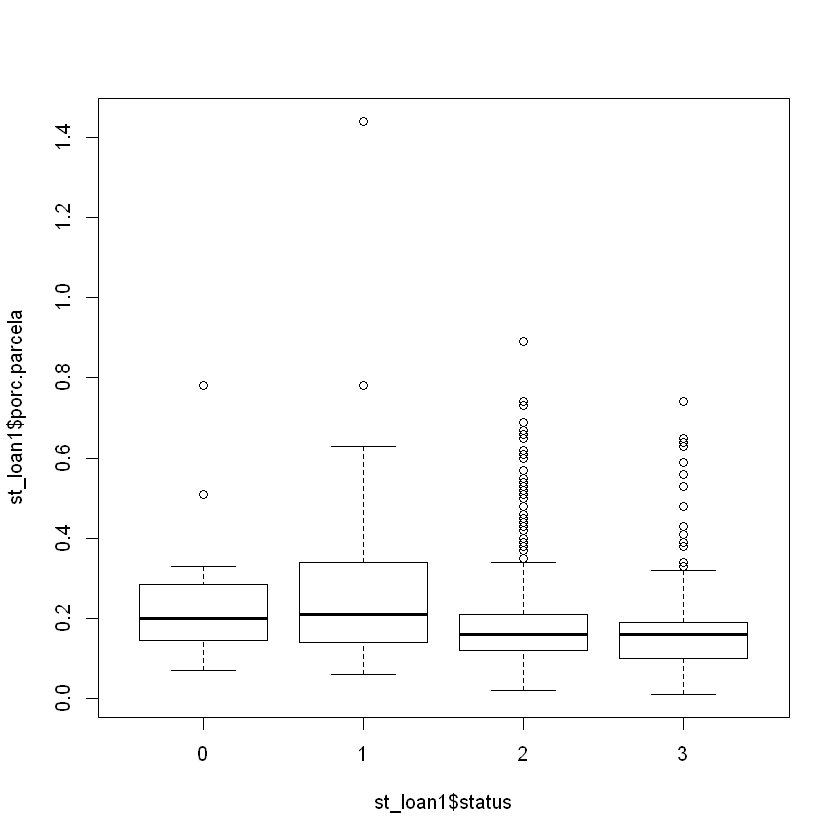

In [338]:
boxplot(st_loan1$porc.parcela ~ st_loan1$status)
lm(formula = st_loan1$porc.parcela ~ st_loan1$status)-> modelo3
summary(modelo3)